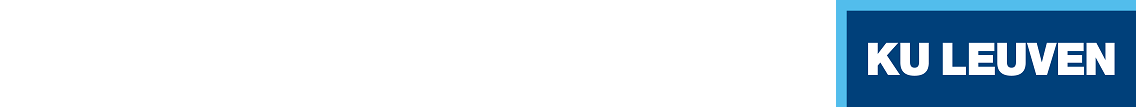

# Biometrics System Concepts
## Assignment 3: Face Recognition
<b>Name</b>: Soheila Hesaraki |
<b>Student-nr</b>: r-0866128 |
<b>Date</b>: May 25, 2023
---
Facial biometrics is among the most common biometric benchmarks. That is due to the easy deployment and implementation of such a system and the lack of requirement of physical interaction by the end-user. The top three application categories where facial recognition are mostly used are: 
* Security - law enforcement: e.g. to find missing children/disoriented adults, or to identify and track criminals  
* Health care: e.g. for detecting genetic diseases, pain management or monitoring response to medication. 
* Banking and retails: Since the beginning of the digital revolution, facial recognition has been picking up prominence over touch- and type-based interactions because of the convenience it offers without settling on the security of transactions. Facial Recognition softwares for banking usually have a liveness detection which keeps hackers from utilizing an image of the user for impersonation purposes. 

Any facial recognition system requires the implementation of the following steps:
<pre>
1. Face detection, to detect faces from a given image.
2. Feature extraction, to extract feature vector descriptors from the raw face image.
3. Face matching process, for verification or identification purposes.
</pre>

In this assignment, you will implement, test and report about a face recognition system based on Principal Components Analysis (Eigenfaces), Linear Discriminant Analysis (Fisherfaces), Local Binary Pattern (LBP) and deep learning. The first three procedures are representative of old-school computer vision techniques that are still in use and retain their merits. All four generated feature vector descriptors can be compared for verification/identification.

This document is structured as follows:
* [Ethics](#Ethics)
* [Importing and installing packages](#Importing-and-installing-packages)
* [I. Loading data](#I.-Loading-data)
    * Read caltech dataset
    * Inspect some images   
    
* [II. Face detection](#II.-Face-detection)
    * Detect faces
    * Print statistics of data
    * Visualise some faces
    
* [III. Feature-extraction](#III.-Feature-extraction)
    * Eigenfaces for face recognition
    * Fisherfaces for face recognition
    * LBP for face recognition
    * Deep metric learning
        
* [IV. Distance-based and classification-based scoring](#IV.-Distance-based-and-classification-based-scoring)
* [V. Evaluation](#V.-Evaluation)
    * Validation as verification system
    * Validation as identification system
    
* [VI. Tasks](#VI.-Tasks)
    * Mandatory tasks
    * Tasks of choice


** Note 1: In case you find yourself needing extra computational power you can make use of [google colab](https://colab.research.google.com/). However, implementing overly complicated routines is discouraged. **

**Note 2: large parts of this notebook are based on the [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock.**

## Ethics
The ethical and societal challenge posed by data protection is radically affected by the use of facial recognition technologies.

In Europe and the UK, the [General Data Protection Regulation](https://www.thalesgroup.com/en/markets/digital-identity-and-security/government/biometrics/biometric-data) (GDPR) provides a rigorous framework for these practices.

Any investigations into a citizen's private life or business travel habits are out of the question, and any such invasions of privacy carry severe penalties. 

Applicable from May 2018, the GDPR supports the principle of a harmonized European framework, in particular protecting the right to be forgotten and the giving of consent through clear affirmative action.






In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing and installing packages
Note: this exercise makes use of keras, which is now part of TensorFlow 2.0. It is easy to install using pip, have a look at the [installation guide](https://www.tensorflow.org/install) for more information. Note that you need Python Version 3.5 to 3.7 for this to run (not lower, not higher).

In [2]:
import numpy as np
import cv2
from pathlib import Path

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
%matplotlib inline

# the following package contains some handy routines for image manipulation
# they have been developed by Adrian Rosenbrock
# simply install this package in your environment using "conda install imutils"
# see https://www.pyimagesearch.com/opencv-tutorials-resources-guides/ for further info
import imutils

# the following packages are imported when needed throughout this notebook, 
# we are only listing them here so that you can install all necessary packages upfront.
# pandas
# sklearn
# enum
# scipy
# tensorflow.keras

## I. Loading data

[From OpenCV Docs](https://docs.opencv.org/3.4/da/d60/tutorial_face_main.html):

In order to test face recognition systems, we need databases of labeled face images. You can either create your own dataset (but that takes time) or, better, start with one of the available face databases, http://face-rec.org/databases/ gives you an up-to-date overview. Some interesting databases are:

* [AT&T Facedatabase](https://cam-orl.co.uk/facedatabase.html). Quoted from http://face-rec.org):
> The AT&T Facedatabase, sometimes also referred to as ORL (Olivetti Research Lab) Database of Faces or Olivetti faces, contains ten different images of each of 40 distinct subjects. For some subjects, the images were taken at different times, varying the lighting, facial expressions (open / closed eyes, smiling / not smiling) and facial details (glasses / no glasses). All the images were taken against a dark homogeneous background with the subjects in an upright, frontal position (with tolerance for some side movement).The AT&T Facedatabase is good for initial tests, but it's a fairly easy database. The Eigenfaces method already has a 97% recognition rate on it, so you won't see any great improvements with other algorithms.

This database can be accessed in a straightforward way through the [sklearn.datasets.fetch_olivetti_faces](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces) module. 
A preview of this database can be seen [here](https://git-disl.github.io/GTDLBench/datasets/att_face_dataset/) 

* [The CALTECH Faces dataset](http://www.vision.caltech.edu/html-files/archive.html) is a popular benchmark dataset for face recognition algorithms. Overall, the dataset consists of 450 images of approximately 27 unique people. Each subject was captured under various lighting conditions, background scenes, and facial expressions. Furthermore, bounding box coordinates are provided to crop the faces prior to recognition. A routine (load_caltech_faces)is provided to read the data. 

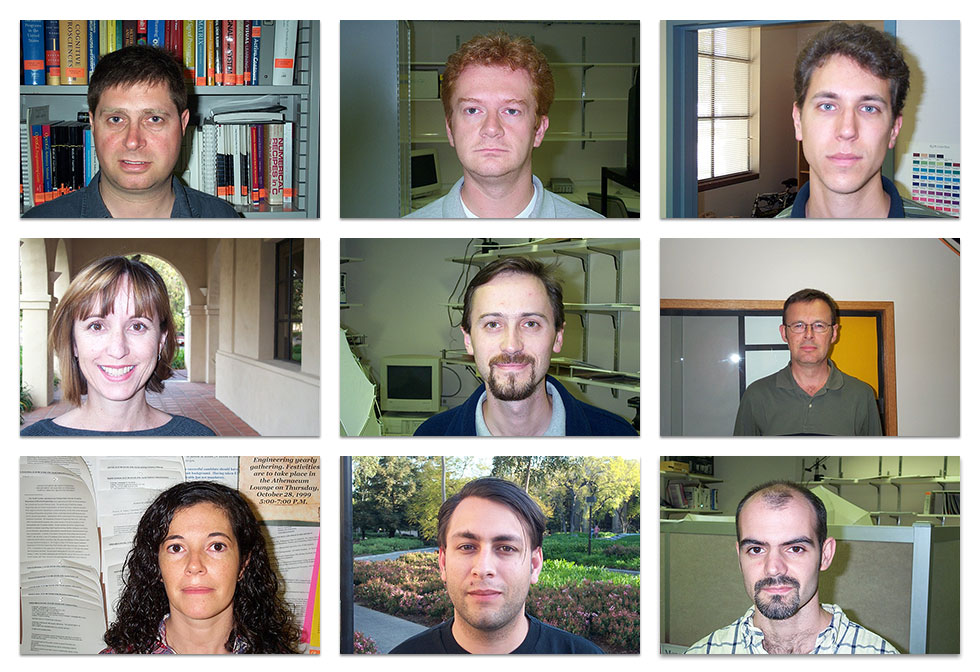

* [The Labeled Faces in the Wild (lfw)](http://vis-www.cs.umass.edu/lfw/). This dataset is a collection of more than 13000 JPEG pictures of famous people collected over the internet. Each face has been labeled with the name of the person pictured. 1680 of the people pictured have two or more distinct photos in the data set. These images are completely unconstrained (pose, illumination, expression, occlusion).  The only constraint on these faces is that they were detected by the Viola-Jones face detector. Each picture is centered on a single face. A loader [sklearn.datasets.fetch_lfw_people](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people) is provided by scikit-learn. 


### 1. Read caltech dataset
For this assignemnt we'll work with the CALTECH dataset because it contains raw images and is not very large. A copy of the dataset is available in the folder "CalTechFacesDirs".

The data are returned as a list object with the following components:
* data: (NxM) matrix of N flattened (linear dimension M) images
* images: (Nx(nxm)) matrix of N images of dimension nxm 
* target: N-dimensional vector of labels 

In [3]:
# size of each face after preprocessing
face_size=(47, 47)

In [4]:
import pandas as pd

def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name
     
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("/content/drive/MyDrive/Assignment3/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [5]:
# display data structure
display(data['images'][0].shape)

(592, 896)

(445, 2)


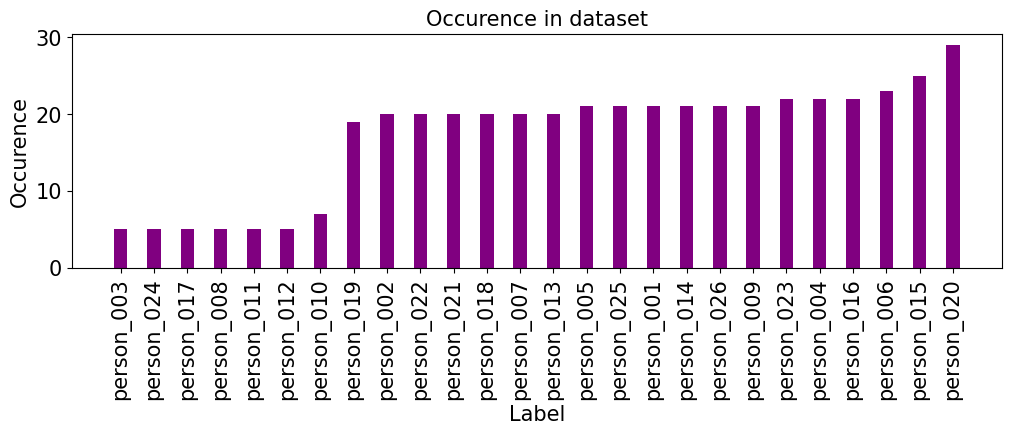

In [ ]:
data_df = pd.DataFrame(imgs, columns=['images', 'target'])
count = data_df['target'].value_counts(ascending=True)
label = count.index
values = count

fig = plt.figure(figsize = (12, 3))
plt.bar(label, values, color ='purple',
        width = 0.4)
print(data_df.shape)
plt.xlabel("Label", fontsize=15)
plt.xticks(rotation='vertical')
plt.ylabel("Occurence", fontsize=15)
plt.title("Occurence in dataset", fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.gcf().subplots_adjust(bottom=0.1)
plt.show()

### 2. Inspect some images

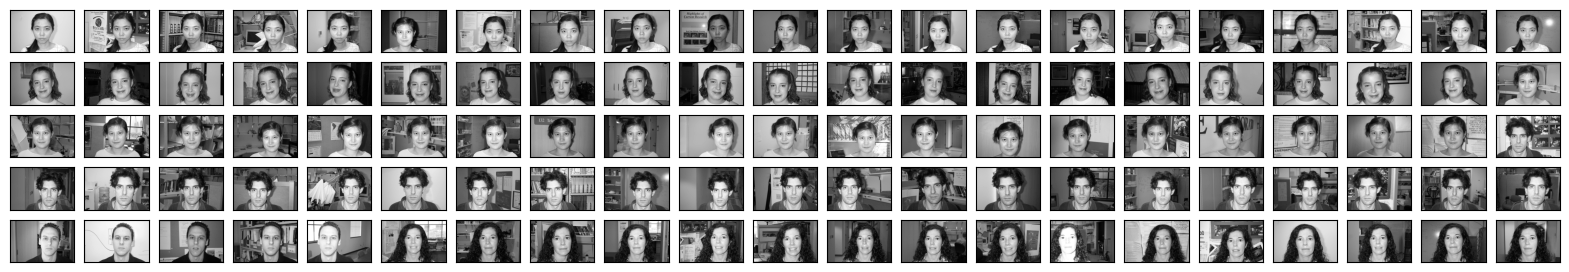

In [6]:
fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, data['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## II. Face detection


Even though the bounding box coordinates are stored in the <em>CalTechFacesDirs/ImageData.mat</em> file, we'll be computing them from scratch for demonstrative purposes. 

### 1. Detect faces
There are many different face detection algorithms, you can follow the [Learn OpenCV tutorial on Face Detection](https://www.learnopencv.com/face-detection-opencv-dlib-and-deep-learning-c-python/) for some (very coarse) background info for two "conventional" (HAAR-cascade, HOG) CV methods and two Deep Neural Net (Dlib) based (SSD, MMOD) methods.

* Some background on Haar, HOG and MMOD face detectors can be found in this [Guide to Face Detection in Python](https://towardsdatascience.com/a-guide-to-face-detection-in-python-3eab0f6b9fc1). 

* For MMOD specifically, see: [Max-Margin Object Detection by Davis E. King](http://arxiv.org/abs/1502.00046) and the comments at the beginning of the [dnn_mmod_ex.cpp code](https://github.com/davisking/dlib/blob/master/examples/dnn_mmod_ex.cpp).

* For further info on the Single-Shot-Multibox Detector, see [the arXiv publication](https://arxiv.org/abs/1512.02325).

In this assignment we'll be using HAAR, you can find more information about this technique on the [OpenCV website](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html).

In [7]:
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/Assignment3/models/haarcascade_frontalface_default.xml')

In [8]:
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

### 2. Print statistics of data

In [9]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() +1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209


### 3. Visualise some faces

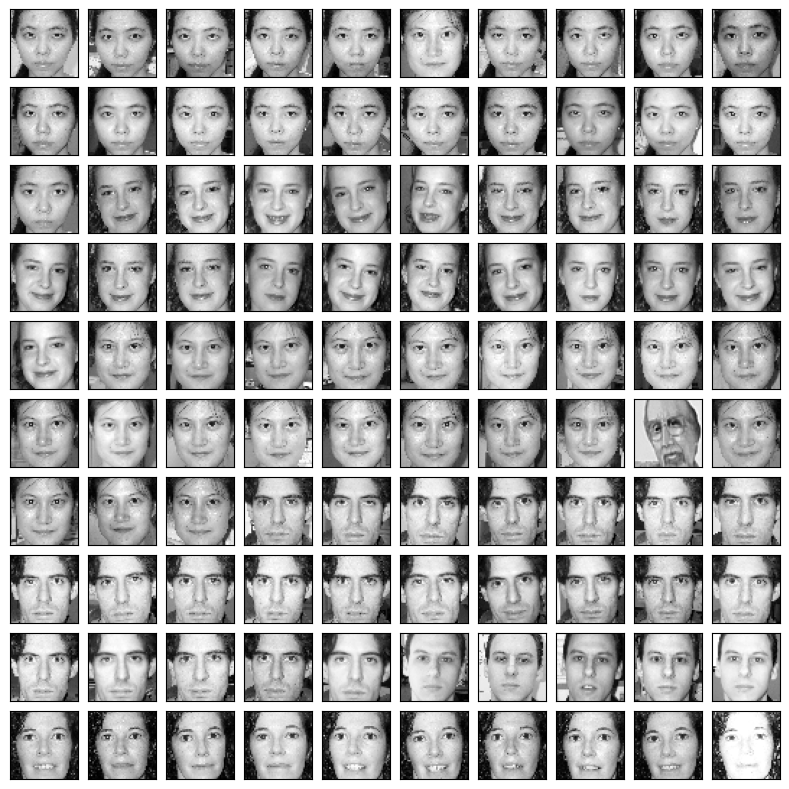

In [10]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## III. Feature extraction

Images tend to be large and can differ a lot in lighting, positioning, ... To combat this we'll extract features from each image using 4 different techniques. They all belong to the global/holistic feature representation approaches that map the image to a lower-dimensional subspace through linear and non-linear mapping. 

In [11]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

### 1. Eigenfaces for face recognition

From [PyImageSearch Gurus Course on Computer Vision](https://www.pyimagesearch.com/pyimagesearch-gurus/) by Adrian Rosebrock:
>In 1971 Goldstein et al. [Identification of human faces](https://ieeexplore.ieee.org/document/1450184) demonstrated that facial characteristics can be manually extracted, quantified and used for face recognition. The question then remained: could this be done in an automatic fashion? 

>It wasn’t until the 1987 paper by Kirby and Sirovich ([A Low-Dimensional Procedure for the Characterization of Human Faces](https://www.researchgate.net/publication/19588504_Low-Dimensional_Procedure_for_the_Characterization_of_Human_Faces)) that we were able to answer this question. This paper is considered to be a seminal work in the history of computer vision — and while other approaches have since been proposed that can outperform Eigenfaces, it’s still important that we take the time to understand and appreciate this algorithm. [Turk and Pentland](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwjmvqy6jqfhAhWFZFAKHb74DNgQFjAAegQIABAC&url=http%3A%2F%2Fwww.face-rec.org%2Falgorithms%2Fpca%2Fjcn.pdf&usg=AOvVaw2IlxVps8dldmeA01yQDa_I) built on this idea in the context of face recognition. 

>The Eigenfaces algorithm uses Principal Component Analysis to construct a low-dimensional representation of face images.

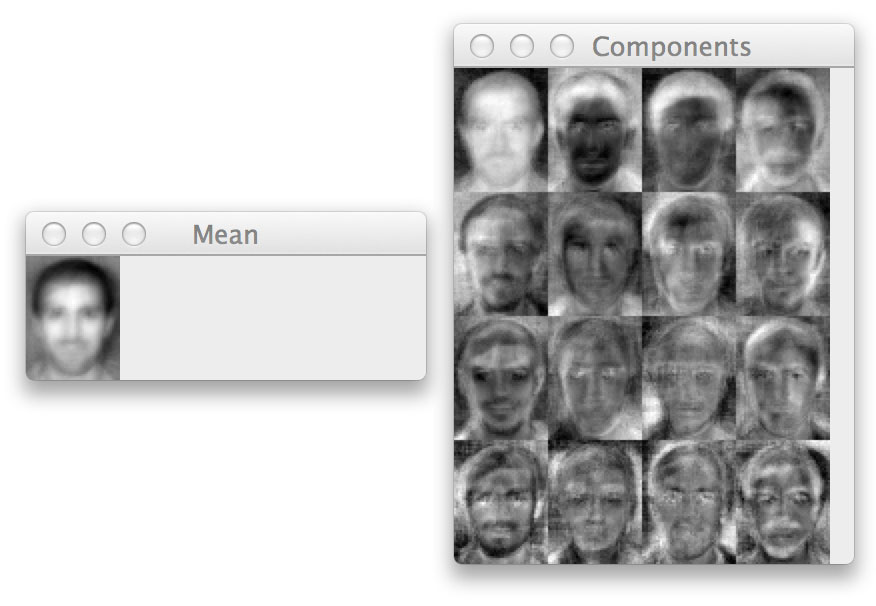

>This involves collecting a dataset of faces with multiple face images per person we want to identify — like having multiple training examples of an image class we would want to label in image classification. Given this dataset of face images, presumed to be the same width, height, and ideally — with their eyes and facial structures aligned at the same (x, y)-coordinates, we apply an eigenvalue decomposition of the dataset, keeping the eigenvectors with the largest corresponding eigenvalues.

>Given these eigenvectors, a face can then be represented as a linear combination of what Kirby and Sirovich call eigenfaces.

>Face identification can be performed by computing the Euclidean distance between the eigenface representations and treating the face identification as a k-Nearest Neighbor classification problem — however, we tend to commonly apply more advanced machine learning algorithms to the eigenface representations.

>Last, it’s important to note that the Eigenfaces algorithm is **not-specific to faces** — we can actually apply it to any arbitrary dataset containing objects of the same type that need to be compared, whether that may be bicycles, cans of soup, or ancient Aztec coins. The Eigenfaces algorithm can be modified to accommodate each of these identification tasks.

In [109]:
DESC = FeatureDescriptor.PCA

In [110]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components = min(num_components, min(n_samples, n_features))
    print("num_components {n}".format(n=num_components))
    desc = PCA(n_components=num_components, svd_solver='randomized', whiten=True).fit(faces.data)
    X_pca = desc.transform(faces.data)
    embedded_pca = X_pca
    
    dist_metric_pca = euclidean

num_components 25


### 2. Fisherfaces for face recognition

From [Scholarpaedia](http://www.scholarpedia.org/article/Fisherfaces):
> When the goal is classification rather than representation, PCA may not yield the most desirable results. In such cases, one wishes to find a subspace that maps the sample vectors of the same class in a single spot of the feature representation and those of different classes as far apart from each other as possible. The techniques derived to achieve this goal are known as discriminant analysis (DA).
The most known DA is Linear Discriminant Analysis (LDA), which can be derived from an idea suggested by R.A. Fisher in 1936. When LDA is used to find the subspace representation of a set of face images, the resulting basis vectors defining that space are known as [Fisherfaces](http://www.scholarpedia.org/article/Fisherfaces).

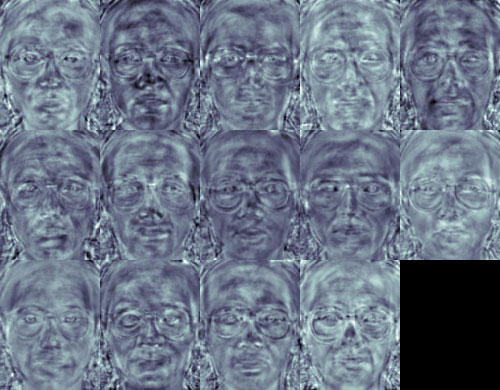

In [14]:
DESC = FeatureDescriptor.LDA

In [15]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components = min(num_components, min(n_classes - 1, n_features))
    desc = LinearDiscriminantAnalysis(n_components=num_components).fit(faces.data, faces.target)
    X_lda = desc.fit_transform(faces.data, faces.target)
    embedded_lda = X_lda
    
    dist_metric_lda = euclidean

### 3. LBP for face recognition

Local Binary Patterns, or LBPs for short, are a texture descriptor made popular by the work of Ojala et al. in their 2002 paper, [Multiresolution Grayscale and Rotation Invariant Texture Classification with Local Binary Patterns](https://ieeexplore.ieee.org/document/1017623) (although the concept of LBPs were introduced as early as 1993).

Unlike [Haralick texture features](http://haralick.org/journals/TexturalFeatures.pdf) that compute a global representation of texture based on the [Gray Level Co-occurrence Matrix](https://en.wikipedia.org/wiki/Co-occurrence_matrix), LBPs instead compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels. See [PyImageSearch](https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/) and [Scikit-Image](http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_local_binary_pattern.html) for further details on LBP.

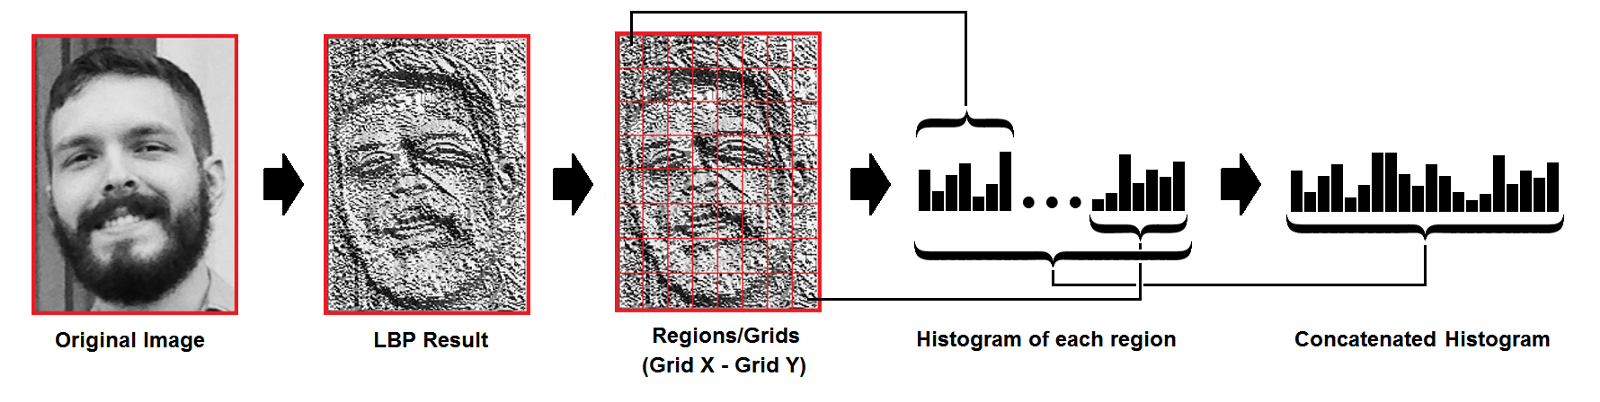

In [16]:
DESC = FeatureDescriptor.LBP

In [17]:
from drive.MyDrive.Assignment3.localmodules.local_binary_patterns import LBP

def chi_squared (histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp = desc.describe_list(faces.images[...,0])
    dist_metric_lbp = chi_squared

In [18]:
dist_metric_lbp

<function __main__.chi_squared(histA, histB, eps=1e-10)>

### 4. Deep metric learning
Similar to previous techniques, we can use deep learning to generate an enriched representation of faces that you can use in simple or more complicated classification algorithms. 
Instead of building networks that are trained end-to-end to perform face recognition, we will use deep metric learning. Metric learning based methods learn a projection of the input data on a low-dimensional vector, such that classification in that lower-dimensional space is much easier and can be performed using simple distance metrics. 

In the context of face recognition we can observe the following major Deep Learning based approaches since 2014.

1. The first approach was developed and presented in 2014 by researchers at Facebook and is called [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) . The major contributions where a CDNN to classify faces. In addition a 3D/2D alignment procedure is applied prior to classification. 
The CDNN is trained as a classifier on the SFC (Social Face Classification) dataset, which is a very large (4.4 million image of 4000 individuals) dataset. This setting is called supervised.  The challenge is whether this can also be generalizd to other datasets and subjects as well. By training it on the large collection of uncontrolled images, an embedded representation (the vector description prior to the classification layer) can be generated that is, allegedly, generalizable to other face recognition data. One can then use this representation as we have previously done for classical representations. 
By way of demonstration they tested it on the LFW dataset to achieve >0.95% verification accuracy. <br> 

2. The second approach was developed by researchers at Google.  An in-depth presentation of their FaceNet/OpenFace deep CNN's for metric embedding of faces is given by [Martin Krasser et al](http://krasserm.github.io/2018/02/07/deep-face-recognition/). Note that this method was trained on 200 million images of eight million identities. The main methodological point is that these networks are trained using a special loss-function: the triplet loss function. 
>This function is minimized when the distance between an anchor image $x_{ai}$ and a positive image $x_{pi}$ (same identity) in embedding space is smaller than the distance between that anchor image and a negative image $x_{ni}$ (different identity) by at least a margin $\alpha$. Model training aims to learn an embedding f(x) of image x such that the squared L2 distance between all faces of the same identity is small and the distance between a pair of faces from different identities is large. 







There is a very elegant Python implementations available of the FaceNet/OpenFace approach. It is nicely described in [this PyImageSearch tutorial](https://www.pyimagesearch.com/2018/06/18/face-recognition-with-opencv-python-and-deep-learning/). It explicitly includes the Dlib package with the [face_recognition modules](https://face-recognition.readthedocs.io/en/latest/index.html) for face detection and recognition. Especially the latter package provides a very convenient interface. 

From the [Dlib face_recognition.py](https://github.com/davisking/dlib/blob/master/python_examples/face_recognition.py) code, we get an application view of the embedding:

> This example shows how to use dlib's face recognition tool.  This tool maps an image of a human face to a 128 dimensional vector space where images of the same person are near to each other and images from different people are far apart.  Therefore, you can perform face recognition by mapping faces to the 128D space and then checking if their Euclidean distance is small enough. 

> When using a distance threshold of 0.6, the dlib model obtains an accuracy of 99.38% on the standard LFW face recognition benchmark, which is comparable to other state-of-the-art methods for face recognition as of February 2017. This accuracy means that, when presented with a pair of face images, the tool will correctly identify if the pair belongs to the same person or is from different people 99.38% of the time.

In the [DeepFace](https://www.cs.toronto.edu/~ranzato/publications/taigman_cvpr14.pdf) paper they also tested a [siamese network](https://en.wikipedia.org/wiki/Siamese_network) DNN architecture for generating embedded vector representations.  This consists of two copies of the same CNN (sharing their weights) that are applied to pairs of images. During training the distance between the embedded representations of the same individual is minimized, and the distances between embedded representations of different individuals is maximized. In the mean time, this work was extended, steadily increasing the performance. Siamese networks are an example of *One-shot Learning* where you tyically have very few samples per object or dynamically changing number of objects/subjects. While [this link](https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d) tests it on a non-face recognition task, it can be applied to face recognition as well.

The localmodules.siamese file contains the description of a shallow CNN model that is trained with [contrastive loss](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf).
This subnetwork is copied twice and the output of both siamese copies are then passed onto a vector euclidean distance (ED) calculation layer. The network gets as input pairs of imposter or genuine images with the associated label (genuine = 0, imposter = 1). You can make use of the output of the network or the output before the ED layer (embedded) in your validation.

Note: this part on Siamese networks is adapted from [Packt tutorial](https://hub.packtpub.com/face-recognition-using-siamese-networks-tutorial/), which seems to be a re-implementation from  [this Packt book on Neural Network Projects with Python](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781789138900)). See also [this Hackernoon tutorial](https://hackernoon.com/one-shot-learning-with-siamese-networks-in-pytorch-8ddaab10340e).

Note: you can change the CNN at your will, but beware that it might take additional training time.

In [19]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import drive.MyDrive.Assignment3.localmodules.siamese as siamese


encoder, model = siamese.create_siamese_model(imshape)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          894400      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

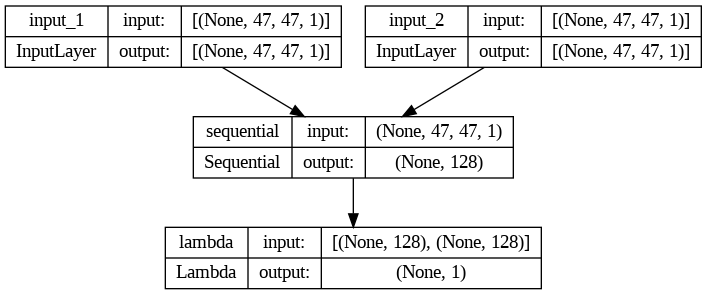

In [20]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes = True, show_layer_names = True)

Depending on the complexity of the Siamese network this might take a while. You can also change the number of epochs to improve the training (with the risk of overfitting). You will notice that a small number (<10) of epochs already gets you a decent performance.

In [21]:
DESC = FeatureDescriptor.DL

In [22]:
import drive.MyDrive.Assignment3.localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(faces.images, faces.target))
    rms = Adam()
    model.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_dl = encoder(faces.images.astype(np.float32)).numpy()

    dist_metric_dl = euclidean

Epoch 1/10
38/38 - 37s - loss: 0.0920 - accuracy: 0.7582 - val_loss: 0.0515 - val_accuracy: 0.8708 - 37s/epoch - 975ms/step
Epoch 2/10
38/38 - 38s - loss: 0.0369 - accuracy: 0.9350 - val_loss: 0.0358 - val_accuracy: 0.9323 - 38s/epoch - 995ms/step
Epoch 3/10
38/38 - 36s - loss: 0.0238 - accuracy: 0.9704 - val_loss: 0.0315 - val_accuracy: 0.9656 - 36s/epoch - 950ms/step
Epoch 4/10
38/38 - 37s - loss: 0.0178 - accuracy: 0.9877 - val_loss: 0.0220 - val_accuracy: 0.9812 - 37s/epoch - 971ms/step
Epoch 5/10
38/38 - 36s - loss: 0.0123 - accuracy: 0.9967 - val_loss: 0.0190 - val_accuracy: 0.9875 - 36s/epoch - 936ms/step
Epoch 6/10
38/38 - 40s - loss: 0.0088 - accuracy: 0.9984 - val_loss: 0.0155 - val_accuracy: 0.9875 - 40s/epoch - 1s/step
Epoch 7/10
38/38 - 42s - loss: 0.0070 - accuracy: 0.9992 - val_loss: 0.0156 - val_accuracy: 0.9875 - 42s/epoch - 1s/step
Epoch 8/10
38/38 - 37s - loss: 0.0055 - accuracy: 0.9992 - val_loss: 0.0125 - val_accuracy: 0.9906 - 37s/epoch - 969ms/step
Epoch 9/10
38/

## IV. Distance-based and classification-based scoring

Biometrics is based on generating pairwise matching scores. In it's simplest form, the score is computed based on the distance metrics (distance-based scoring). E.g. a simple pairwise comparision (L2-distance, e.g.) can be used. 

* In verification mode one compares this matching score to a decision threshold in a 1-to-1 setting.
* In identifcation mode one uses this matching score to rank the templates in the database and, possibly, thresholding it as well in a 1-to-N setting
 

On the other hand, some classification algorithms provide us with the classification scores (or probabilities), which are related to the likelihood that an image belongs to each subject in the dataset. These classification scores can be seen as an advanced classification-based matching score. 

* In verification mode one compares the soft scores (or probabilities) of the classification with a threshold to verify whether the person is who he claims to be.
* In identifcation mode one sorts the soft scores to propose the most similar people in the dataset.

To implement a classification-based system (optional task 3), the following steps are expected:
1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).
2. Run the classifier of your choice and generate the classification probabilities for each test image.
3. Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.
4. Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.

# **Q1. Compute distance-based pair-wise matching scores.**

Given the function <em>dist_metric</em> and the vector representations in variable <em>embedded</em>, compute the pairwise distances. Do this for PCA, LDA, LBP and a DL facial representations, given the code above.

In [23]:
import pandas as pd

def computePairwiseDistances(embedded, dist_func):
  
    N = embedded.shape[0]
    table = []
    
    for i in range(N):
        table_row = []
        
        for j in range(N):
            distance = dist_func(embedded[i], embedded[j])
            table_row.append(distance)
        
        table.append(table_row)
    
    columns = [str(i) for i in range(N)]
    matching_scores = pd.DataFrame(table, columns=columns, index=columns)
    
    return matching_scores


# Pairwise distances of PCA facial representation

In [24]:
matching_scores_pca = computePairwiseDistances(embedded_pca, dist_metric_pca)
matching_scores_pca

0         1         2         3         4         5         6  \
0    0.000000  8.920610  8.304070  4.775545  6.137484  9.086304  2.919949   
1    8.920610  0.000000  6.482358  8.275124  6.969713  9.220521  8.751441   
2    8.304070  6.482358  0.000000  7.976993  6.332424  7.800300  8.242795   
3    4.775545  8.275124  7.976993  0.000000  4.772513  9.151951  4.294162   
4    6.137484  6.969713  6.332424  4.772513  0.000000  8.072213  5.057886   
..        ...       ...       ...       ...       ...       ...       ...   
435  8.863663  9.262880  7.537455  9.061674  8.507876  6.962352  9.350380   
436  8.994574  8.083016  7.914184  9.325967  8.072558  5.819568  9.690464   
437  7.685564  9.239368  7.845600  7.571818  7.123699  7.969283  7.891494   
438  8.086434  9.589357  9.087098  8.818273  8.446744  8.359186  8.347370   
439  8.285192  8.955948  7.753132  8.857273  8.589463  7.103223  8.847584   

            7         8         9  ...       430       431       432  \
0    5.515762  7.698907  6.467548  ...  7.830783  8.641381  7.267912   
1    6.308643  7.533671  7.123637  ...  9.026551  8.881120  8.492455   
2    4.888116  3.716824  5.585542  ...  7.397170  7.309305  7.677687   
3    5.203201  8.333826  7.533617  ...  8.059590  8.491635  7.808227   
4    4.814106  6.478136  6.643388  ...  7.543460  7.774409  7.320874   
..        ...       ...       ...  ...       ...       ...       ...   
435  7.724659  7.059090  6.803064  ...  3.991262  3.315128  5.762723   
436  8.091126  7.172916  6.415671  ...  5.082742  4.593986  6.056133   
437  6.542149  7.022744  7.356427  ...  4.077501  6.023365  3.138505   
438  7.766820  8.197674  8.306504  ...  4.847826  6.910196  3.842037   
439  6.955518  7.266803  6.628610  ...  5.135846  4.638933  5.853676   

          433       434       435       436       437       438       439  
0    8.306045  8.342466  8.863663  8.994574  7.685564  8.086434  8.285192  
1    9.262233  8.923018  9.262880  8.083016  9.239368  9.589357  8.955948  
2    7.522244  7.942745  7.537455  7.914184  7.845600  9.087098  7.753132  
3    7.760864  8.389316  9.061674  9.325967  7.571818  8.818273  8.857273  
4    7.103938  7.994254  8.507876  8.072558  7.123699  8.446744  8.589463  
..        ...       ...       ...       ...       ...       ...       ...  
435  4.670014  4.651865  0.000000  4.950369  6.781372  7.239171  3.665335  
436  5.130777  5.654194  4.950369  0.000000  7.101950  8.125939  5.740719  
437  4.957626  6.036269  6.781372  7.101950  0.000000  4.443219  7.159902  
438  6.731491  6.790377  7.239171  8.125939  4.443219  0.000000  7.529875  
439  5.607408  3.921544  3.665335  5.740719  7.159902  7.529875  0.000000  

[440 rows x 440 columns]

# Pairwise distances of LDA facial representation

In [25]:
matching_scores_lda = computePairwiseDistances(embedded_lda, dist_metric_lda)
matching_scores_lda

0          1          2          3          4          5  \
0     0.000000   4.062245   5.914143   5.913294   8.488972  12.781859   
1     4.062245   0.000000   4.769494   4.802622   7.395612  12.782964   
2     5.914143   4.769494   0.000000   5.847731   6.012872  13.777274   
3     5.913294   4.802622   5.847731   0.000000   7.325139  13.538187   
4     8.488972   7.395612   6.012872   7.325139   0.000000  14.406290   
..         ...        ...        ...        ...        ...        ...   
435  21.198250  21.219736  22.219046  21.177742  21.644495  19.418950   
436  19.686405  19.220408  19.828584  19.759975  19.180115  16.964122   
437  20.235611  20.063848  20.884614  20.318637  20.532459  17.800844   
438  20.781586  20.470794  21.106208  20.398553  20.328580  18.223115   
439  19.959599  19.466217  20.264781  20.513449  20.008666  17.829289   

             6          7          8          9  ...        430        431  \
0     5.362226   4.627120   7.091281   8.412486  ...  23.732896  22.797136   
1     4.981223   4.336221   7.104820   7.508039  ...  23.227796  22.364544   
2     5.061408   4.887236   5.518575   8.275573  ...  23.215796  23.026798   
3     5.516492   5.294859   7.172755   8.550303  ...  22.881238  22.399963   
4     7.722418   7.265586   8.375236   9.014202  ...  22.416358  22.666885   
..         ...        ...        ...        ...  ...        ...        ...   
435  20.138239  20.942122  22.325736  17.457492  ...  10.115086   7.338513   
436  18.344607  19.870867  20.700726  15.023601  ...  13.075052  10.589556   
437  19.474527  19.972043  21.211062  16.028342  ...   9.305486   6.728387   
438  19.356376  20.299380  21.079565  16.450509  ...   9.214382   6.968346   
439  18.950100  19.851974  21.040753  16.316908  ...  11.253149   7.921116   

           432        433        434        435        436        437  \
0    20.162587  20.629865  22.801847  21.198250  19.686405  20.235611   
1    19.833760  20.215740  22.397977  21.219736  19.220408  20.063848   
2    20.282820  20.961533  22.790302  22.219046  19.828584  20.884614   
3    20.486104  20.734973  22.472957  21.177742  19.759975  20.318637   
4    19.761646  20.278639  22.255174  21.644495  19.180115  20.532459   
..         ...        ...        ...        ...        ...        ...   
435   7.512140   6.654065   9.161225   0.000000  10.465919   7.083855   
436  10.301313   9.346018  10.154712  10.465919   0.000000   9.207031   
437   6.726622   5.641171   8.293872   7.083855   9.207031   0.000000   
438   7.237059   5.606161   7.808562   6.488233   9.997207   6.214574   
439   8.434587   8.206275   9.507851   8.940138   9.070654   8.316925   

           438        439  
0    20.781586  19.959599  
1    20.470794  19.466217  
2    21.106208  20.264781  
3    20.398553  20.513449  
4    20.328580  20.008666  
..         ...        ...  
435   6.488233   8.940138  
436   9.997207   9.070654  
437   6.214574   8.316925  
438   0.000000   8.904037  
439   8.904037   0.000000  

[440 rows x 440 columns]

# Pairwise distances of LBP facial representation

In [26]:
matching_scores_lbp = computePairwiseDistances(embedded_lbp, dist_metric_lbp)
matching_scores_lbp

0         1         2         3         4         5         6  \
0    0.000000  5.190097  5.473133  5.470197  5.108794  7.114088  4.649987   
1    5.190097  0.000000  5.391799  4.999311  4.849400  6.850983  5.067893   
2    5.473133  5.391799  0.000000  5.720661  5.258175  6.684932  5.756236   
3    5.470197  4.999311  5.720661  0.000000  5.090648  7.446286  4.564630   
4    5.108794  4.849400  5.258175  5.090648  0.000000  7.317104  4.869536   
..        ...       ...       ...       ...       ...       ...       ...   
435  5.610743  6.004196  6.421768  5.678981  6.054141  6.574610  5.552466   
436  6.554594  6.595199  6.754812  6.348313  6.636824  6.464351  6.925835   
437  5.868242  5.665817  6.399918  5.997840  5.829987  7.061297  5.901919   
438  7.020465  7.336460  7.285298  7.239666  7.039988  7.549678  7.249476   
439  5.576879  5.962049  6.383026  6.112593  5.575872  6.540257  6.151025   

            7         8         9  ...       430       431       432  \
0    5.424898  6.051554  5.291766  ...  6.262591  5.828627  5.472153   
1    5.123921  5.523418  4.997985  ...  6.274815  6.845030  6.002742   
2    5.831137  6.079230  5.735916  ...  5.980707  6.552187  6.080412   
3    4.789289  5.672465  5.184324  ...  6.196236  6.737354  6.108908   
4    4.906707  5.989226  5.282117  ...  5.878870  6.381622  6.147505   
..        ...       ...       ...  ...       ...       ...       ...   
435  5.736242  6.548605  5.433755  ...  5.177908  5.292157  4.698978   
436  7.120931  6.892198  5.965459  ...  5.141768  5.651851  6.097337   
437  6.408732  7.743297  6.007936  ...  5.025967  6.568028  5.183534   
438  7.229192  8.236237  7.316969  ...  5.733238  6.096732  5.434289   
439  5.881153  6.824148  5.620232  ...  5.792377  5.703915  5.519757   

          433       434       435       436       437       438       439  
0    6.196675  5.878383  5.610743  6.554594  5.868242  7.020465  5.576879  
1    6.241324  6.138858  6.004196  6.595199  5.665817  7.336460  5.962049  
2    6.846212  6.553579  6.421768  6.754812  6.399918  7.285298  6.383026  
3    6.222599  6.783924  5.678981  6.348313  5.997840  7.239666  6.112593  
4    5.948158  5.681192  6.054141  6.636824  5.829987  7.039988  5.575872  
..        ...       ...       ...       ...       ...       ...       ...  
435  5.583667  5.239822  0.000000  5.261529  5.786809  6.123632  5.079852  
436  6.005178  5.830208  5.261529  0.000000  6.469432  6.638745  6.251682  
437  5.601867  6.002827  5.786809  6.469432  0.000000  6.453148  5.874724  
438  6.623646  5.873556  6.123632  6.638745  6.453148  0.000000  6.329385  
439  5.998043  5.365510  5.079852  6.251682  5.874724  6.329385  0.000000  

[440 rows x 440 columns]

# Pairwise distances of DL facial representation

In [27]:
matching_scores_dl = computePairwiseDistances(embedded_dl, dist_metric_dl)
matching_scores_dl

0           1           2           3           4           5  \
0      0.000000   61.742020   57.212994   13.409514   27.167536   48.183891   
1     61.742020    0.000000   22.431263   59.543564   43.912636   24.015799   
2     57.212994   22.431263    0.000000   57.894135   39.382599   26.780294   
3     13.409514   59.543564   57.894135    0.000000   23.313696   44.762169   
4     27.167536   43.912636   39.382599   23.313696    0.000000   27.210632   
..          ...         ...         ...         ...         ...         ...   
435  205.580566  172.575409  171.688965  206.715668  194.792130  181.569168   
436  195.329117  159.728607  159.245239  196.332611  183.876114  170.053833   
437  216.102493  183.423813  182.513138  217.592316  205.698883  192.220749   
438  202.051071  170.223511  169.913498  203.010513  191.608170  179.188126   
439  200.536789  166.333206  166.248901  201.479919  189.475296  175.390091   

              6           7           8           9  ...         430  \
0     44.699680   39.943672   45.063042   68.838768  ...  204.382248   
1     66.862068   34.731304   26.562017   59.567436  ...  170.729156   
2     65.773888   25.577263   19.777956   56.716606  ...  169.261703   
3     43.822777   40.535492   43.169476   68.482574  ...  205.796051   
4     45.863953   24.435379   23.458759   58.528969  ...  193.554749   
..          ...         ...         ...         ...  ...         ...   
435  209.292450  178.072327  177.714554  147.062408  ...   10.257698   
436  196.660294  167.122696  165.974960  139.101059  ...   22.167618   
437  219.367523  189.071655  188.781860  158.612167  ...   20.808146   
438  203.213608  175.922363  175.015793  145.561539  ...   24.308168   
439  204.181488  172.887314  172.227890  142.224579  ...   16.358267   

            431         432         433         434         435         436  \
0    212.492950  219.200699  215.628464  194.897476  205.580566  195.329117   
1    176.530838  188.338043  182.222946  160.136642  172.575409  159.728607   
2    175.845749  185.920349  181.641495  160.156876  171.688965  159.245239   
3    213.883698  220.986252  216.950043  195.573593  206.715668  196.332611   
4    201.427383  208.899567  205.001404  183.471252  194.792130  183.876114   
..          ...         ...         ...         ...         ...         ...   
435   20.087961   25.067526   20.697926   17.793423    0.000000   21.651394   
436   23.597778   42.727299   29.600786   22.981459   21.651394    0.000000   
437   19.515703   24.833603   13.139004   30.255539   18.496279   31.900761   
438   29.127817   36.895531   21.342579   26.061543   16.756582   22.888758   
439   22.487852   33.213486   21.390379   13.300255   12.673695   19.318546   

            437         438         439  
0    216.102493  202.051071  200.536789  
1    183.423813  170.223511  166.333206  
2    182.513138  169.913498  166.248901  
3    217.592316  203.010513  201.479919  
4    205.698883  191.608170  189.475296  
..          ...         ...         ...  
435   18.496279   16.756582   12.673695  
436   31.900761   22.888758   19.318546  
437    0.000000   23.778713   22.195498  
438   23.778713    0.000000   18.426296  
439   22.195498   18.426296    0.000000  

[440 rows x 440 columns]

Observing the matrix, it is evident that the diagonal consists entirely of 0 values. This is expected since the diagonal represents the self-distance of each image.

## V. Evaluation

In this section you can re-use the code you developed for validation in the previous assignments, and in particular assignment 1. 

### 1. Validation as verification system

# **Q2. Compute F1 and accuracy scores for variable (and optimal) thresholds**

* Calculate and plot F1 and accuracy scores for a range (min, max) of thresholds.
* Determine some optimal threshold (look up in classification literature). Justify your answer.

### 1-1 Ground truth matrix label

We have a ground truth label matrix that relates pictures to people. Each row and column in the matrix corresponds to a picture, and the value of an element indicates whether that picture belongs to the person associated with the row or column number.

To clarify, if the second element in row 1 and the third element in row 1 both have a value of 1, it means that the pictures depicted in those positions belong to person 1, as the row number corresponds to the person's identity.

As the matrix is symmetric, in that scenario, the second element in column 1 and the third element in column 1 both have a value of 1, which means that the pictures depicted in those positions belong to person 1, as the column number corresponds to the person's identity.

In [30]:
targets.shape

(440,)

In [31]:
targets

array([24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24,
       24, 24, 24, 24, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21,
       21, 21, 21, 21, 21, 21, 21, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25,
       25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       23, 23, 23, 23, 23, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20, 17, 17, 17, 17, 17, 17, 17, 17, 17,
       17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 16, 16, 16, 16, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 18, 18, 18, 18, 18,
       18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 14, 14, 14, 14,
       14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 15

In [28]:
ground_truth_matrix = np.zeros((440, 440))

for m in range(440):
  label_copy = np.ones((440,)) * targets[m]
  ground_truth_matrix[m, :] = (targets == label_copy).astype(int)

In [29]:
ground_truth_matrix

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

### 1-2 Matching Score Normalization

It is worth noting that after normalization symmetry property of the initial matrix should be kept. Thats why instead of normalizing per row or colomn, I used the min and max of whole matrix and normalized it using them

In [32]:
def normalize(matrix):
    min_val = np.min(np.min(matrix))
    max_val = np.max(np.max(matrix))
    
    normalized_matrix = (matrix - min_val) / (max_val - min_val)

    return normalized_matrix


In [33]:
normalized_matching_scores_pca = normalize(matching_scores_pca)
normalized_matching_scores_pca


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


0         1         2         3         4         5         6  \
0    0.000000  0.520409  0.484441  0.278595  0.358047  0.530075  0.170343   
1    0.520409  0.000000  0.378166  0.482752  0.406598  0.537905  0.510540   
2    0.484441  0.378166  0.000000  0.465360  0.369420  0.455052  0.480866   
3    0.278595  0.482752  0.465360  0.000000  0.278418  0.533905  0.250512   
4    0.358047  0.406598  0.369420  0.278418  0.000000  0.470915  0.295066   
..        ...       ...       ...       ...       ...       ...       ...   
435  0.517086  0.540376  0.439718  0.528638  0.496331  0.406168  0.545480   
436  0.524723  0.471545  0.461696  0.544056  0.470935  0.339501  0.565320   
437  0.448359  0.539004  0.457695  0.441723  0.415581  0.464910  0.460372   
438  0.471745  0.559422  0.530121  0.514438  0.492764  0.487656  0.486967   
439  0.483340  0.522470  0.452300  0.516714  0.501090  0.414386  0.516148   

            7         8         9  ...       430       431       432  \
0    0.321777  0.449137  0.377302  ...  0.456830  0.504119  0.423994   
1    0.368032  0.439498  0.415577  ...  0.526589  0.518105  0.495431   
2    0.285162  0.216831  0.325848  ...  0.431534  0.426409  0.447899   
3    0.303543  0.486177  0.439494  ...  0.470179  0.495383  0.455515   
4    0.280844  0.377920  0.387561  ...  0.440069  0.453542  0.427084   
..        ...       ...       ...  ...       ...       ...       ...   
435  0.450639  0.411812  0.396876  ...  0.232841  0.193397  0.336184   
436  0.472018  0.418452  0.374276  ...  0.296516  0.268003  0.353301   
437  0.381654  0.409691  0.429158  ...  0.237872  0.351390  0.183093   
438  0.453099  0.478234  0.484583  ...  0.282811  0.403126  0.224136   
439  0.405770  0.423929  0.386698  ...  0.299614  0.270625  0.341490   

          433       434       435       436       437       438       439  
0    0.484556  0.486681  0.517086  0.524723  0.448359  0.471745  0.483340  
1    0.540338  0.520549  0.540376  0.471545  0.539004  0.559422  0.522470  
2    0.438831  0.463362  0.439718  0.461696  0.457695  0.530121  0.452300  
3    0.452752  0.489414  0.528638  0.544056  0.441723  0.514438  0.516714  
4    0.414428  0.466367  0.496331  0.470935  0.415581  0.492764  0.501090  
..        ...       ...       ...       ...       ...       ...       ...  
435  0.272438  0.271379  0.000000  0.288794  0.395610  0.422317  0.213827  
436  0.299318  0.329853  0.288794  0.000000  0.414312  0.474049  0.334901  
437  0.289217  0.352143  0.395610  0.414312  0.000000  0.259208  0.417693  
438  0.392700  0.396136  0.422317  0.474049  0.259208  0.000000  0.439276  
439  0.327124  0.228774  0.213827  0.334901  0.417693  0.439276  0.000000  

[440 rows x 440 columns]

In [58]:
normalized_matching_scores_lda = normalize(matching_scores_lda)
normalized_matching_scores_lbp = normalize(matching_scores_lbp)
normalized_matching_scores_dl = normalize(matching_scores_dl)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:84: 

Similarity score would be :

similarity_score = 1 - normalized_matching_scores

And it indicates the similarity between pictures, the higher value, the more similar.

In [79]:
smilarity_score_pca = np.ones(normalized_matching_scores_pca.shape) - normalized_matching_scores_pca
smilarity_score_lda = np.ones(normalized_matching_scores_lda.shape) - normalized_matching_scores_lda
smilarity_score_lbp = np.ones(normalized_matching_scores_lbp.shape) - normalized_matching_scores_lbp
smilarity_score_dl =  np.ones(normalized_matching_scores_dl.shape) - normalized_matching_scores_dl

In [80]:
normalized_matching_scores_pca

0         1         2         3         4         5         6  \
0    0.000000  0.520409  0.484441  0.278595  0.358047  0.530075  0.170343   
1    0.520409  0.000000  0.378166  0.482752  0.406598  0.537905  0.510540   
2    0.484441  0.378166  0.000000  0.465360  0.369420  0.455052  0.480866   
3    0.278595  0.482752  0.465360  0.000000  0.278418  0.533905  0.250512   
4    0.358047  0.406598  0.369420  0.278418  0.000000  0.470915  0.295066   
..        ...       ...       ...       ...       ...       ...       ...   
435  0.517086  0.540376  0.439718  0.528638  0.496331  0.406168  0.545480   
436  0.524723  0.471545  0.461696  0.544056  0.470935  0.339501  0.565320   
437  0.448359  0.539004  0.457695  0.441723  0.415581  0.464910  0.460372   
438  0.471745  0.559422  0.530121  0.514438  0.492764  0.487656  0.486967   
439  0.483340  0.522470  0.452300  0.516714  0.501090  0.414386  0.516148   

            7         8         9  ...       430       431       432  \
0    0.321777  0.449137  0.377302  ...  0.456830  0.504119  0.423994   
1    0.368032  0.439498  0.415577  ...  0.526589  0.518105  0.495431   
2    0.285162  0.216831  0.325848  ...  0.431534  0.426409  0.447899   
3    0.303543  0.486177  0.439494  ...  0.470179  0.495383  0.455515   
4    0.280844  0.377920  0.387561  ...  0.440069  0.453542  0.427084   
..        ...       ...       ...  ...       ...       ...       ...   
435  0.450639  0.411812  0.396876  ...  0.232841  0.193397  0.336184   
436  0.472018  0.418452  0.374276  ...  0.296516  0.268003  0.353301   
437  0.381654  0.409691  0.429158  ...  0.237872  0.351390  0.183093   
438  0.453099  0.478234  0.484583  ...  0.282811  0.403126  0.224136   
439  0.405770  0.423929  0.386698  ...  0.299614  0.270625  0.341490   

          433       434       435       436       437       438       439  
0    0.484556  0.486681  0.517086  0.524723  0.448359  0.471745  0.483340  
1    0.540338  0.520549  0.540376  0.471545  0.539004  0.559422  0.522470  
2    0.438831  0.463362  0.439718  0.461696  0.457695  0.530121  0.452300  
3    0.452752  0.489414  0.528638  0.544056  0.441723  0.514438  0.516714  
4    0.414428  0.466367  0.496331  0.470935  0.415581  0.492764  0.501090  
..        ...       ...       ...       ...       ...       ...       ...  
435  0.272438  0.271379  0.000000  0.288794  0.395610  0.422317  0.213827  
436  0.299318  0.329853  0.288794  0.000000  0.414312  0.474049  0.334901  
437  0.289217  0.352143  0.395610  0.414312  0.000000  0.259208  0.417693  
438  0.392700  0.396136  0.422317  0.474049  0.259208  0.000000  0.439276  
439  0.327124  0.228774  0.213827  0.334901  0.417693  0.439276  0.000000  

[440 rows x 440 columns]

In [81]:
smilarity_score_pca

0         1         2         3         4         5         6  \
0    1.000000  0.479591  0.515559  0.721405  0.641953  0.469925  0.829657   
1    0.479591  1.000000  0.621834  0.517248  0.593402  0.462095  0.489460   
2    0.515559  0.621834  1.000000  0.534640  0.630580  0.544948  0.519134   
3    0.721405  0.517248  0.534640  1.000000  0.721582  0.466095  0.749488   
4    0.641953  0.593402  0.630580  0.721582  1.000000  0.529085  0.704934   
..        ...       ...       ...       ...       ...       ...       ...   
435  0.482914  0.459624  0.560282  0.471362  0.503669  0.593832  0.454520   
436  0.475277  0.528455  0.538304  0.455944  0.529065  0.660499  0.434680   
437  0.551641  0.460996  0.542305  0.558277  0.584419  0.535090  0.539628   
438  0.528255  0.440578  0.469879  0.485562  0.507236  0.512344  0.513033   
439  0.516660  0.477530  0.547700  0.483286  0.498910  0.585614  0.483852   

            7         8         9  ...       430       431       432  \
0    0.678223  0.550863  0.622698  ...  0.543170  0.495881  0.576006   
1    0.631968  0.560502  0.584423  ...  0.473411  0.481895  0.504569   
2    0.714838  0.783169  0.674152  ...  0.568466  0.573591  0.552101   
3    0.696457  0.513823  0.560506  ...  0.529821  0.504617  0.544485   
4    0.719156  0.622080  0.612439  ...  0.559931  0.546458  0.572916   
..        ...       ...       ...  ...       ...       ...       ...   
435  0.549361  0.588188  0.603124  ...  0.767159  0.806603  0.663816   
436  0.527982  0.581548  0.625724  ...  0.703484  0.731997  0.646699   
437  0.618346  0.590309  0.570842  ...  0.762128  0.648610  0.816907   
438  0.546901  0.521766  0.515417  ...  0.717189  0.596874  0.775864   
439  0.594230  0.576071  0.613302  ...  0.700386  0.729375  0.658510   

          433       434       435       436       437       438       439  
0    0.515444  0.513319  0.482914  0.475277  0.551641  0.528255  0.516660  
1    0.459662  0.479451  0.459624  0.528455  0.460996  0.440578  0.477530  
2    0.561169  0.536638  0.560282  0.538304  0.542305  0.469879  0.547700  
3    0.547248  0.510586  0.471362  0.455944  0.558277  0.485562  0.483286  
4    0.585572  0.533633  0.503669  0.529065  0.584419  0.507236  0.498910  
..        ...       ...       ...       ...       ...       ...       ...  
435  0.727562  0.728621  1.000000  0.711206  0.604390  0.577683  0.786173  
436  0.700682  0.670147  0.711206  1.000000  0.585688  0.525951  0.665099  
437  0.710783  0.647857  0.604390  0.585688  1.000000  0.740792  0.582307  
438  0.607300  0.603864  0.577683  0.525951  0.740792  1.000000  0.560724  
439  0.672876  0.771226  0.786173  0.665099  0.582307  0.560724  1.000000  

[440 rows x 440 columns]

By choosing a threshold value we can predict which picture belongs to which person. As an example, by setting threshold to 0.6, the predicted labels would be:

In [82]:
def predict_label(similarity_score, threshold):
  similarity_score = np.array(similarity_score)
  predicted_label = np.zeros(similarity_score.shape)

  for i in range(predicted_label.shape[0]):  
    for j in range(predicted_label.shape[1]):

        if similarity_score[i, j] > threshold:
          predicted_label[i, j] = 1
        else:
          predicted_label[i, j] = 0 
  return predicted_label

In [83]:
predicted_label_pca = predict_label(smilarity_score_pca, 0.5)
pd.DataFrame(predicted_label_pca)

0    1    2    3    4    5    6    7    8    9    ...  430  431  432  \
0    1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  ...  1.0  0.0  1.0   
1    0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  ...  0.0  0.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
435  0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
436  0.0  1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
437  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
438  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   
439  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  ...  1.0  1.0  1.0   

     433  434  435  436  437  438  439  
0    1.0  1.0  0.0  0.0  1.0  1.0  1.0  
1    0.0  0.0  0.0  1.0  0.0  0.0  0.0  
2    1.0  1.0  1.0  1.0  1.0  0.0  1.0  
3    1.0  1.0  0.0  0.0  1.0  0.0  0.0  
4    1.0  1.0  1.0  1.0  1.0  1.0  0.0  
..   ...  ...  ...  ...  ...  ...  ...  
435  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
436  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
437  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
438  1.0  1.0  1.0  1.0  1.0  1.0  1.0  
439  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

[440 rows x 440 columns]

### 1-3 Calculating F1-score and accuracy

No, by having the ground truth labels and predicted labels, we can calculate F1-score and accuracy

In [84]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_precision_recall_f1_accuracy(ground_truth, predicted):
    assert ground_truth.shape == predicted.shape

    # Reshape the matrices to create 1D arrays
    ground_truth_flat = ground_truth.reshape(-1)
    predicted_flat = predicted.reshape(-1)

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(ground_truth_flat, predicted_flat)
    recall = recall_score(ground_truth_flat, predicted_flat)
    f1 = f1_score(ground_truth_flat, predicted_flat)
    accuracy = accuracy_score(ground_truth_flat, predicted_flat)

    return precision, recall, f1, accuracy


In [85]:
thresholds = np.linspace(0,1,50)

f1_pca_arr, f1_lda_arr, f1_lbp_arr, f1_dl_arr  = [], [], [], []
acc_pca_arr, acc_lda_arr, acc_lbp_arr, acc_dl_arr = [], [], [], []
precision_pca_arr,precision_lda_arr, precision_lbp_arr, precision_dl_arr = [], [], [], []
recall_pca_arr, recall_lda_arr, recall_lbp_arr, recall_dl_arr = [], [], [], []

for threshold in thresholds:
  predicted_label_pca = predict_label(smilarity_score_pca, threshold)
  predicted_label_lda = predict_label(smilarity_score_lda, threshold)
  predicted_label_lbp = predict_label(smilarity_score_lbp, threshold)
  predicted_label_dl = predict_label(smilarity_score_dl, threshold)

  precision_pca, recall_pca, f1_pca, accuracy_pca = calculate_precision_recall_f1_accuracy(ground_truth_matrix, predicted_label_pca)
  precision_lda, recall_lda, f1_lda, accuracy_lda = calculate_precision_recall_f1_accuracy(ground_truth_matrix, predicted_label_lda)
  precision_lbp, recall_lbp, f1_lbp, accuracy_lbp = calculate_precision_recall_f1_accuracy(ground_truth_matrix, predicted_label_lbp)
  precision_dl, recall_dl, f1_dl, accuracy_dl = calculate_precision_recall_f1_accuracy(ground_truth_matrix, predicted_label_dl)

  f1_pca_arr.append(f1_pca)
  f1_lda_arr.append(f1_lda)
  f1_lbp_arr.append(f1_lbp)
  f1_dl_arr.append(f1_dl)

  acc_pca_arr.append(accuracy_pca)
  acc_lda_arr.append(accuracy_lda)
  acc_lbp_arr.append(accuracy_lbp)
  acc_dl_arr.append(accuracy_dl)

  precision_pca_arr.append(precision_pca)
  precision_lda_arr.append(precision_lda)
  precision_lbp_arr.append(precision_lbp)
  precision_dl_arr.append(precision_dl)

  recall_pca_arr.append(recall_pca)
  recall_lda_arr.append(recall_lda)
  recall_lbp_arr.append(recall_lbp)
  recall_dl_arr.append(recall_dl)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

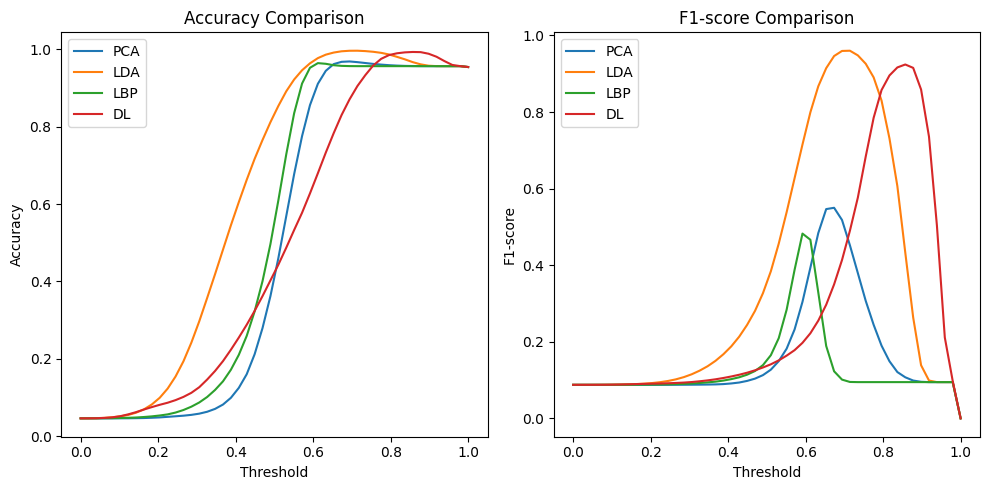

In [86]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy curves
ax1.plot(thresholds, acc_pca_arr, label='PCA')
ax1.plot(thresholds, acc_lda_arr, label='LDA')
ax1.plot(thresholds, acc_lbp_arr, label='LBP')
ax1.plot(thresholds, acc_dl_arr, label='DL')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.legend()

# Plot F1-score curves
ax2.plot(thresholds, f1_pca_arr, label='PCA')
ax2.plot(thresholds, f1_lda_arr, label='LDA')
ax2.plot(thresholds, f1_lbp_arr, label='LBP')
ax2.plot(thresholds, f1_dl_arr, label='DL')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1-score')
ax2.set_title('F1-score Comparison')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

# **Q3. Plot genuine and impostor scores**

When comparing the different feature extractions/facial representations, discuss the difference in the overlap between genuine and imposter scores.

In [131]:
def min_max_norm(df_col):
    return (np.max(df_col) - df_col) / (np.max(df_col) - np.min(df_col))

def compute_similarity_matrix(embedded, dist_metric, labels):
    data = []
    similarity_matrix = np.zeros((len(embedded), len(embedded)))
    for i, img1 in enumerate(embedded):
        for j, img2 in enumerate(embedded):
            score = dist_metric(img1, img2)
            if i != j:
                genuine = 1 if labels[i] == labels[j] else 0
                data.append([labels[i], labels[j], genuine, score])
            similarity_matrix[i][j] = score

    df = pd.DataFrame(data, columns=['p1', 'p2', 'genuine', 'score'])
    df['normalized_score'] = min_max_norm(df['score'].values)
    similarity_mat_norm = min_max_norm(similarity_matrix)
    return df, pd.DataFrame(similarity_mat_norm)


In [160]:
df_pca, similarity_mat_pca = compute_similarity_matrix(embedded_pca, dist_metric_pca, labels)
df_lda, similarity_mat_lda = compute_similarity_matrix(embedded_lda, dist_metric_lda, labels)
df_lbp, similarity_mat_lbp = compute_similarity_matrix(embedded_lbp, dist_metric_lbp, labels)
df_dl, similarity_mat_dl = compute_similarity_matrix(embedded_dl, dist_metric_dl, labels)

In [136]:
df_pca

p1          p2  genuine     score  normalized_score
0       person_025  person_025        1  5.812048          0.695224
1       person_025  person_025        1  5.759144          0.698737
2       person_025  person_025        1  3.622668          0.840613
3       person_025  person_025        1  5.235525          0.733508
4       person_025  person_025        1  7.414985          0.588778
...            ...         ...      ...       ...               ...
193155  person_002  person_002        1  2.288000          0.929243
193156  person_002  person_002        1  2.819479          0.893949
193157  person_002  person_002        1  4.817993          0.761235
193158  person_002  person_002        1  5.686276          0.703576
193159  person_002  person_002        1  5.996395          0.682982

[193160 rows x 5 columns]

In [137]:
genuine_df_pca = df_pca['normalized_score'][df_pca['genuine'] == 1]
imposter_df_pca = df_pca['normalized_score'][df_pca['genuine'] == 0]

print('number of genuine scores : ', len(genuine_df_pca))
print('number of imposter scores : ', len(imposter_df_pca))

number of genuine scores :  8420
number of imposter scores :  184740


In [138]:
genuine_df_lda = df_lda['normalized_score'][df_lda['genuine'] == 1]
imposter_df_lda = df_lda['normalized_score'][df_lda['genuine'] == 0]

genuine_df_lbp = df_lbp['normalized_score'][df_lbp['genuine'] == 1]
imposter_df_lbp = df_lbp['normalized_score'][df_lbp['genuine'] == 0]

genuine_df_dl = df_dl['normalized_score'][df_dl['genuine'] == 1]
imposter_df_dl = df_dl['normalized_score'][df_dl['genuine'] == 0]

In [139]:
def plot_score_distribution(ax, imposter, genuine, title):
    bins = np.linspace(0, 1, 150)
    ax.set_title("Raw scores " + title, fontsize=12)
    ax.hist(imposter,
            label='Impostors', density=True,
            color='C1', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.hist(genuine,
            label='Genuine', density=True,
            color='C0', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.legend(fontsize=10)
    ax.set_xlabel("Scores")

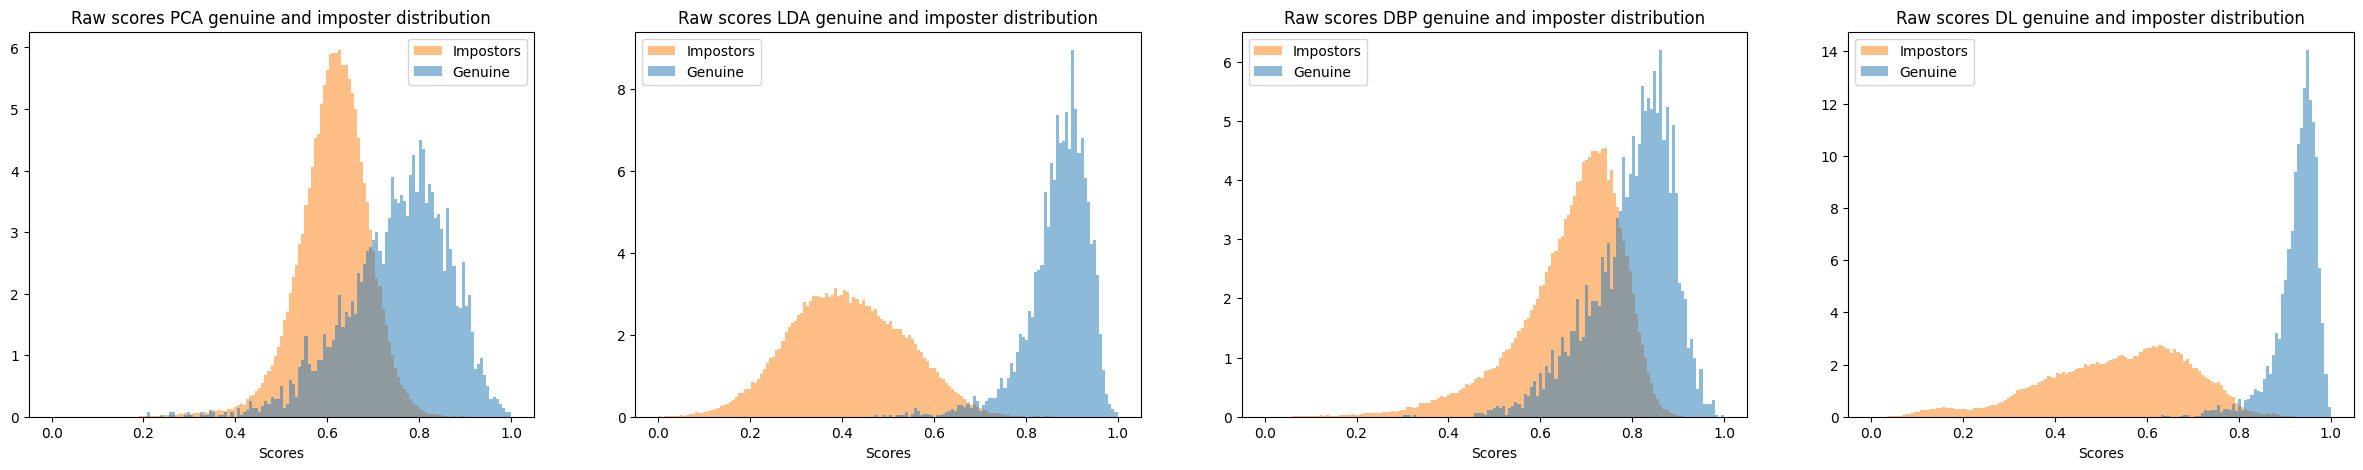

In [140]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))

plot_score_distribution(axes[0], imposter_df_pca, genuine_df_pca, "PCA genuine and imposter distribution")
plot_score_distribution(axes[1], imposter_df_lda, genuine_df_lda, "LDA genuine and imposter distribution")
plot_score_distribution(axes[2], imposter_df_lbp, genuine_df_lbp, "DBP genuine and imposter distribution")
plot_score_distribution(axes[3], imposter_df_dl, genuine_df_dl, "DL genuine and imposter distribution")

# **Q4. Perform a full-on verification assessment based on the scores obtained. Interpret the results.**

Hint: Calculate and plot the equal error rate. Plot the precision-recall curve and compute AUC and average precision. Interpret the results e.g. by explaining what aspect of the system performance is explored by each metric.

### 4-1 ROC score

In [141]:
y_true_pca, score_pca = df_pca['genuine'], df_pca['normalized_score']
y_true_lda, score_lda = df_lda['genuine'], df_lda['normalized_score']
y_true_lbp, score_lbp = df_lbp['genuine'], df_lbp['normalized_score']
y_true_dl,  score_dl =  df_dl['genuine'], df_dl['normalized_score']

In [145]:
from sklearn.metrics import roc_auc_score

roc_au_pca = roc_auc_score(y_true_pca, score_pca)
roc_au_lda = roc_auc_score(y_true_lda, score_lda)
roc_au_lbp = roc_auc_score(y_true_lbp, score_lbp)
roc_au_dl= roc_auc_score(y_true_dl, score_dl)

print('ROC score for PCA : ', round(roc_au_pca,4))
print('ROC score for LDA : ', round(roc_au_lda,4))
print('ROC score for LBP : ', round(roc_au_lbp,4))
print('ROC score for DL : ', round(roc_au_dl,4))

ROC score for PCA :  0.8538
ROC score for LDA :  0.9985
ROC score for LBP :  0.8401
ROC score for DL :  0.9977


### 4-2 EER (The equal error rate) thresholds

The Equal Error Rate (EER), which is the point on the ROC-curve where FAR(FMR) equals FRR (1-TAR). A lower EER value indicates better performance.

In [146]:
from sklearn.metrics import roc_curve

def compute_fpr_fnr_tpr_from_roc_curve(score, y_true):
    fpr, tpr, threshold = roc_curve(y_true, score, pos_label=None, sample_weight=None)
    fnr = 1 - tpr
    return fpr, fnr, tpr, threshold,

In [147]:
fpr_roc_pca, fnr_roc_pca, tpr_roc_pca, threshold_roc_pca = compute_fpr_fnr_tpr_from_roc_curve(score_pca, y_true_pca)
fpr_roc_lda, fnr_roc_lda, tpr_roc_lda, threshold_roc_lda = compute_fpr_fnr_tpr_from_roc_curve(score_lda, y_true_lda)
fpr_roc_lbp, fnr_roc_lbp, tpr_roc_lbp, threshold_roc_lbp = compute_fpr_fnr_tpr_from_roc_curve(score_lbp, y_true_lbp)
fpr_roc_dl, fnr_roc_dl, tpr_roc_dl, threshold_roc_dl = compute_fpr_fnr_tpr_from_roc_curve(score_dl, y_true_dl)

In [148]:
eer_threshold_roc_pca = threshold_roc_pca[np.nanargmin(np.absolute((fnr_roc_pca - fpr_roc_pca)))]
eer_threshold_roc_lda = threshold_roc_lda[np.nanargmin(np.absolute((fnr_roc_lda - fpr_roc_lda)))]
eer_threshold_roc_lbp = threshold_roc_lbp[np.nanargmin(np.absolute((fnr_roc_lbp - fpr_roc_lbp)))]
eer_threshold_roc_dl = threshold_roc_dl[np.nanargmin(np.absolute((fnr_roc_dl - fpr_roc_dl)))]
print('EER threshold for PCA : ', round(eer_threshold_roc_pca,4))
print('EER threshold for LDA : ', round(eer_threshold_roc_lda,4))
print('EER threshold for LBP : ', round(eer_threshold_roc_lbp,4))
print('EER threshold for DL : ', round(eer_threshold_roc_dl,4))

EER threshold for PCA :  0.6702
EER threshold for LDA :  0.6702
EER threshold for LBP :  0.7459
EER threshold for DL :  0.7901


In [149]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curve(fpr, tpr, ax, title_add=""):
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax)
    ax.set_title("Receiver Operating Characteristic (ROC) curves " + title_add)
    ax.set_ylim(0)

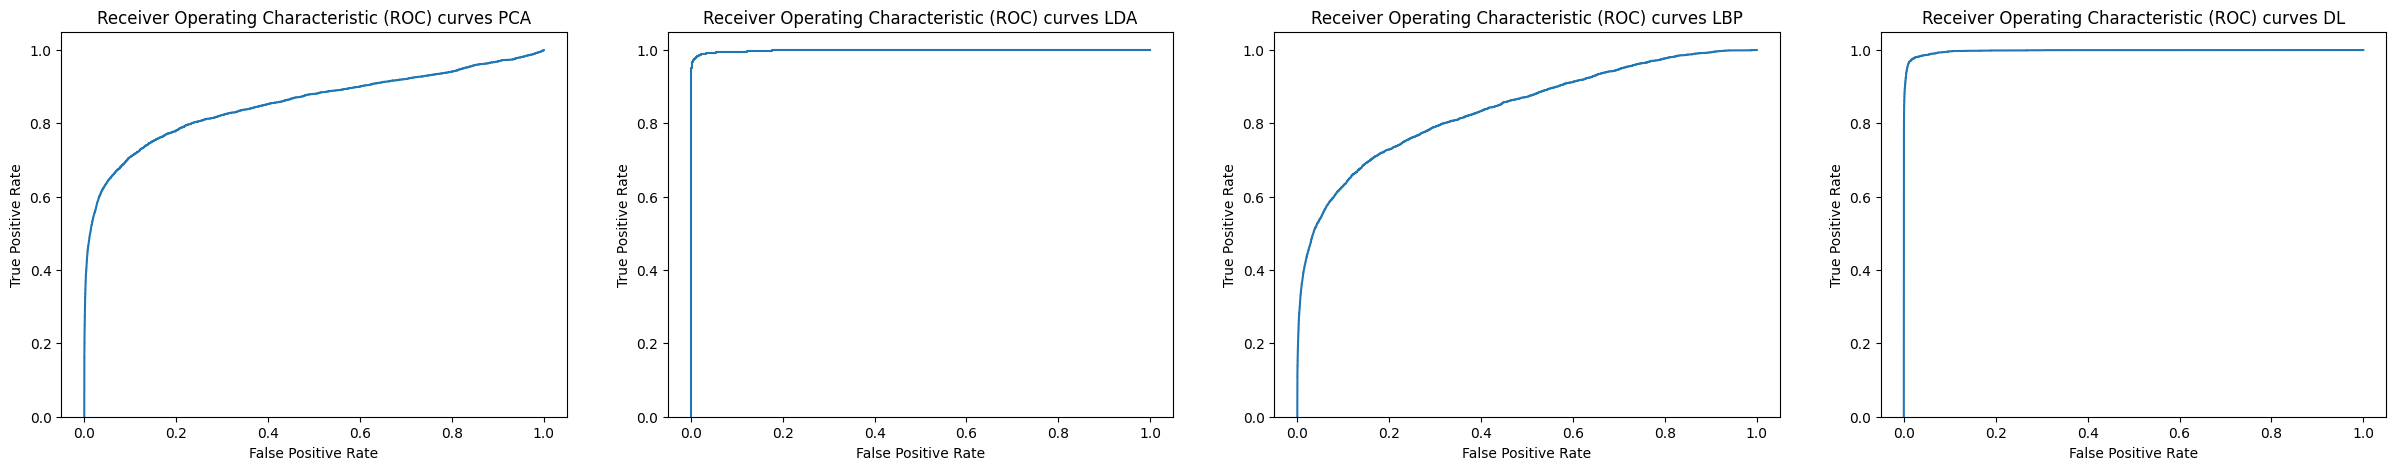

In [150]:
figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_roc_curve(fpr_roc_pca, tpr_roc_pca, axes[0], "PCA")
plot_roc_curve(fpr_roc_lda, tpr_roc_lda, axes[1], "LDA")
plot_roc_curve(fpr_roc_lbp, tpr_roc_lbp, axes[2],  "LBP")
plot_roc_curve(fpr_roc_dl, tpr_roc_dl, axes[3],  "DL")

### 4-3 precision-recall curve

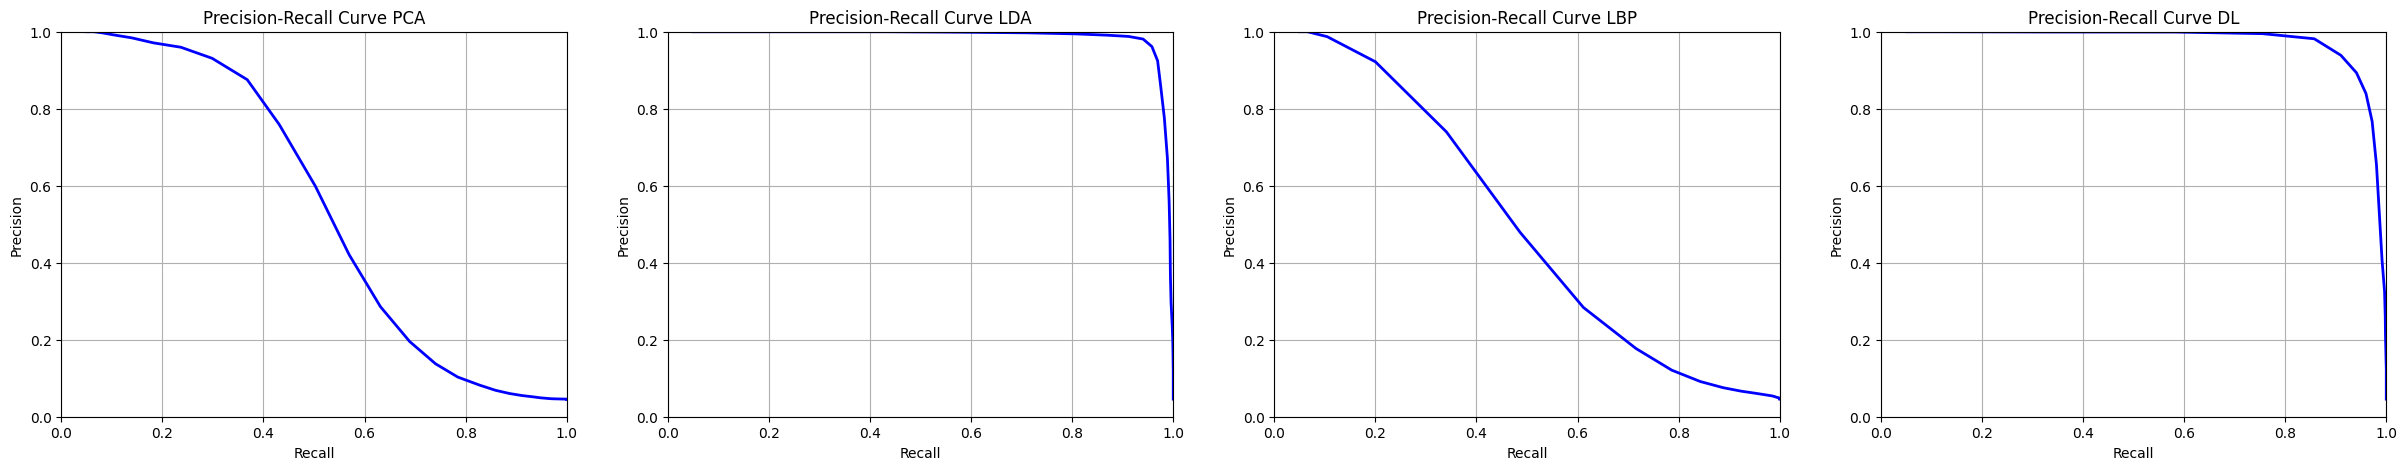

In [151]:
def plot_precision_recall_curve(recall, precision, ax, title_add=""):
    ax.plot(recall, precision, color='blue', lw=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve ' + title_add)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.grid(True)

figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_precision_recall_curve(recall_pca_arr[:-1], precision_pca_arr[:-1], axes[0], "PCA")
plot_precision_recall_curve(recall_lda_arr[:-1], precision_lda_arr[:-1], axes[1], "LDA")
plot_precision_recall_curve(recall_lbp_arr[:-1], precision_lbp_arr[:-1], axes[2],  "LBP")
plot_precision_recall_curve(recall_dl_arr[:-1], precision_dl_arr[:-1], axes[3],  "DL")

### 4-4 AUC

In [152]:
from sklearn.metrics import auc

def calculate_auc_precision_recall(precision, recall):
    sorted_indices = sorted(range(len(recall)), key=lambda k: recall[k])
    recall_sorted = [recall[i] for i in sorted_indices]
    precision_sorted = [precision[i] for i in sorted_indices]
    auc_score = auc(recall_sorted, precision_sorted)
    print(round(auc_score,4))
    return auc_score

In [153]:
auc_score_pca = calculate_auc_precision_recall(precision_pca_arr, recall_pca_arr)
auc_score_lda = calculate_auc_precision_recall(precision_lda_arr, recall_lda_arr)
auc_score_lbp = calculate_auc_precision_recall(precision_lbp_arr, recall_lbp_arr)
auc_score_dl = calculate_auc_precision_recall(precision_dl_arr, recall_dl_arr)

0.5274
0.9615
0.4752
0.9494


### 4-5 Average precision

In [154]:
from sklearn.metrics import average_precision_score

average_precision_pca = average_precision_score(ground_truth_matrix, smilarity_score_pca)
average_precision_lda = average_precision_score(ground_truth_matrix, smilarity_score_lda)
average_precision_lbp = average_precision_score(ground_truth_matrix, smilarity_score_lbp)
average_precision_dl = average_precision_score(ground_truth_matrix, smilarity_score_dl)

In [155]:
print('average precision with pca features:', round(average_precision_pca,4))
print('average precision with lda features:', round(average_precision_lda,4))
print('average precision with lbp features:', round(average_precision_lbp,4))
print('average precision with dl features:', round(average_precision_dl,4))

average precision with pca features: 0.6545
average precision with lda features: 0.9803
average precision with lbp features: 0.5841
average precision with dl features: 0.9745


# **2. Validation as identification system**

# **Q5. Validate the systems in an identification scenario.**

Hint: Generate a Cumulative Matching Curve. Calculate and compare rank-1 performance among the four feature extraction techniques.

In [156]:
def calculate_cmc(smilarity_score_pca, ground_truth_matrix):
    smilarity_score_pca = np.array(smilarity_score_pca)
    ground_truth_matrix = np.array(ground_truth_matrix)

    scores = smilarity_score_pca.flatten()
    labels = ground_truth_matrix.flatten()
    
    # Sort the scores and labels in descending order
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Calculate the number of genuine matches at each rank
    genuine_matches = np.cumsum(sorted_labels)

    # Calculate the rank-t identification rate R_t for t = 1, 2, ..., N
    identification_rates = (genuine_matches / np.sum(labels)) * 100

    return identification_rates

In [157]:
ranked_pca = calculate_cmc(smilarity_score_pca, ground_truth_matrix)
ranked_lda = calculate_cmc(smilarity_score_lda, ground_truth_matrix)
ranked_lbp = calculate_cmc(smilarity_score_lbp, ground_truth_matrix)
ranked_dl = calculate_cmc(smilarity_score_dl, ground_truth_matrix)

In [158]:
import seaborn as sns

def plot_cmc(df, axes, index):
    p = sns.lineplot(data=df, ax=axes)
    p.set(xlabel="Rank", ylabel="Recognition rate",
          title="Cumulative Matching Characteristic Curve for " + index)

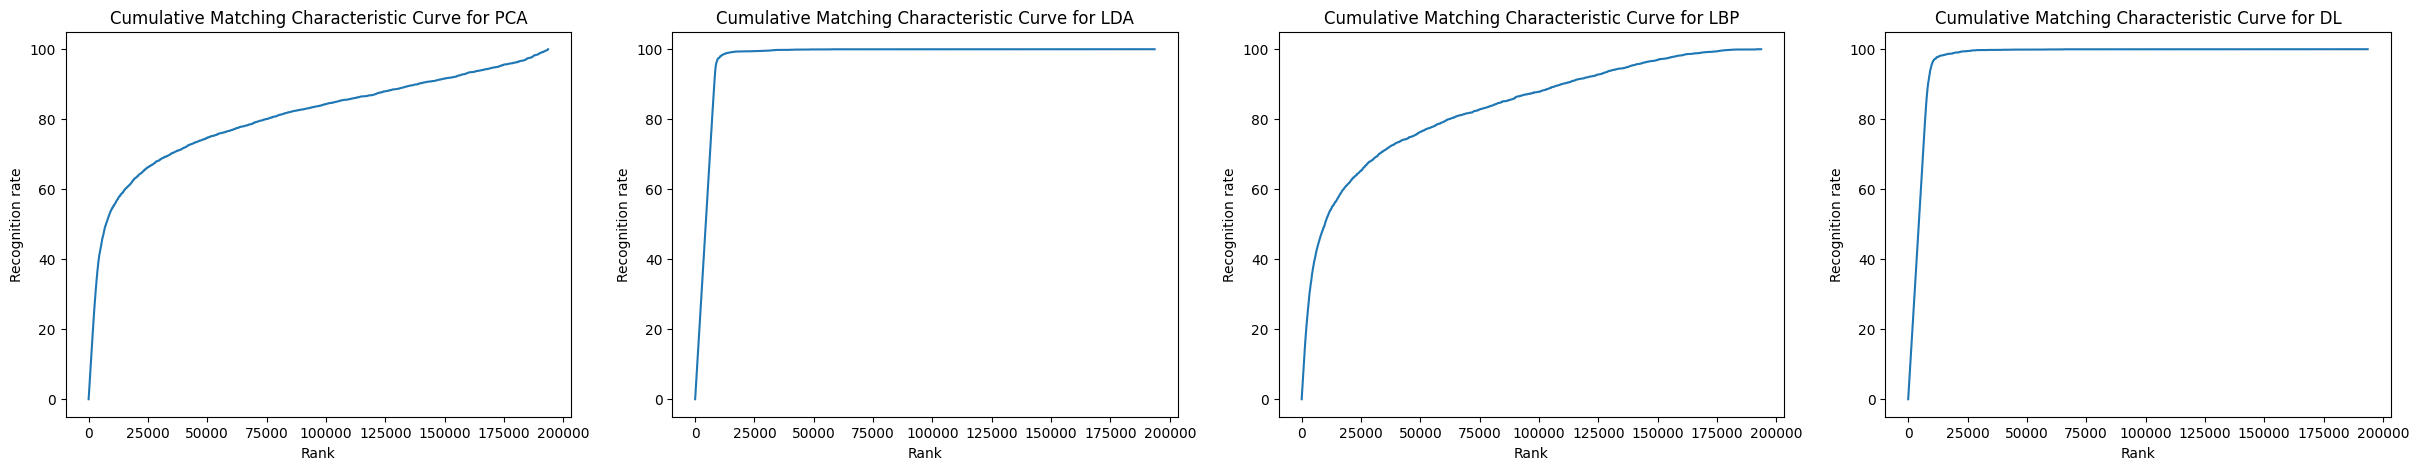

In [159]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
plot_cmc(ranked_pca, axes[0], "PCA")
plot_cmc(ranked_lda, axes[1], "LDA")
plot_cmc(ranked_lbp, axes[2], "LBP")
plot_cmc(ranked_dl, axes[3], "DL")

## **VI. Tasks**
All tasks should be accompanied by a text providing information on the technique, steps, and the reasoning behind choosing the techniques.


### 1. Mandatory tasks
<b>The student should do all of the tasks indicated below</b>: 
1. Execute all the tasks indicated in the document above
2. Compare the 4 feature representations (LBP, PCA, LDA, DL using Siamese Networks) using the implemented validation metrics in Questions 2-5, and report on the performance. Please make it clear where in your report the comparison is made for each question. 

### 2. Tasks of choice
<b>The student should choose a number of tasks equivalent to <u>at least 3pts</u> from the list below (pts are not related to the grades)</b>. 

1. Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)
2. Implement 2 different face detectors and compare all techniques to the ground truth bounding boxes provided in <em>CalTechFacesDirs/ImageData.mat</em>. Look up the literature for methods to compare different face detectors. (1pt.)
3. Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)
4. Experiment with the Siamese deep learning model by implementing a different loss function or a different distance calculation layer. (1pt.)
5. Pre-train your deep learning network on a different (larger) dataset and then fine-tune it with CALTECH and compare the results. (2pt.) 
6. Implement a different deep learning model* (2pt.)


e.g. performing task 4 and 5 is valid because their points sum up to 3. 

<em>Note: Indicate clearly which tasks you end up choosing and where we can find the implementations and/or results. </em>

[*] The implemented network has to be significantly different, adding some layers like batch normalisation, dropout, ... to the current network or increasing the kernel size, amount of filters and activation functions does not count.

# **2.1 Evaluate your system on the other two datasets (AT&T, LFW). Feel free to subsample datasets if they are too memory-consuming on your system. (1pt.)**

## **2-1-1. AT&T dataset**

In [7]:
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

def create_image_database(n_samples=400, n_classes=40, n_images_per_class=10, n_channels=1):
    db = fetch_olivetti_faces()
    # Select the desired number of images and classes
    selected_indices = np.concatenate([np.where(db.target == i)[0][:n_images_per_class] for i in range(n_classes)])
    selected_images = db.images[selected_indices]
    selected_targets = db.target[selected_indices]
    # Expand dimensions to have n_channels
    selected_images = np.expand_dims(selected_images, axis=3)
    db.images = selected_images
    db.target = selected_targets
    db.images = db.images[:n_samples]
    db.target = db.target[:n_samples]
    return db

def get_image_db_statistic(db):
    # extract number of samples and image dimensions (for later display)
    n_samples, h, w, n_channels = db.images.shape
    imshape = (h, w, n_channels)

    # count number of individuals
    n_classes = db.target.max() + 1

    n_features = db.data.shape[1]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_classes: %d" % n_classes)
    print("n_features: %d" % n_features)
    print("imshape: " + str(imshape))

    return imshape, n_samples, n_classes, n_features

In [9]:
db_att = create_image_database(n_samples=400, n_classes=40, n_images_per_class=10, n_channels=1)

imshape_att, n_samples_att, n_classes_att, n_features_att = get_image_db_statistic(db_att)

Total dataset size:
n_samples: 400
n_classes: 40
n_features: 4096
imshape: (64, 64, 1)


In [3]:
db_att = create_image_database(n_samples=400, n_classes=40, n_images_per_class=10, n_channels=1)
labels_att = []
for target in db_att.target:
    pre = "" if target > 8 else "0"
    labels_att.append("person_0" + pre + str(target+1))

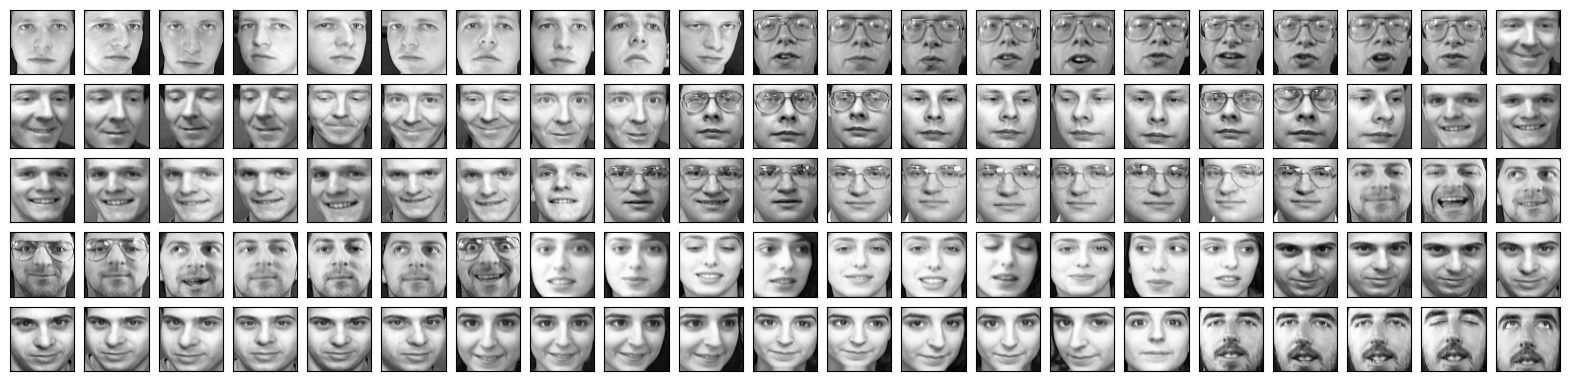

In [11]:
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, db_att['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

## **Feature extraction**

In [12]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

**Eigenfaces for face recognition: PCA**

In [13]:
DESC = FeatureDescriptor.PCA

In [14]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components_att = min(num_components, min(n_samples_att, n_features_att))
    print("num_components {n}".format(n=num_components_att))
    desc = PCA(n_components=num_components_att, svd_solver='randomized', whiten=True).fit(db_att.data)
    X_pca = desc.transform(db_att.data)
    embedded_pca_att = X_pca
    
    dist_metric_pca_att = euclidean

num_components 35


In [17]:
import pandas as pd

def min_max_norm(df_col):
    return (np.max(df_col) - df_col) / (np.max(df_col) - np.min(df_col))

def compute_similarity_matrix(embedded, dist_metric, labels):
    data = []
    similarity_matrix = np.zeros((len(embedded), len(embedded)))
    for i, img1 in enumerate(embedded):
        for j, img2 in enumerate(embedded):
            score = dist_metric(img1, img2)
            if i != j:
                genuine = 1 if labels[i] == labels[j] else 0
                data.append([labels[i], labels[j], genuine, score])
            similarity_matrix[i][j] = score

    df = pd.DataFrame(data, columns=['p1', 'p2', 'genuine', 'score'])
    df['normalized_score'] = min_max_norm(df['score'].values)
    similarity_mat_norm = min_max_norm(similarity_matrix)
    return df, pd.DataFrame(similarity_mat_norm)
    

In [48]:
print(len(labels_att))

400


In [31]:
embedded_pca_att.shape

(400, 35)

In [18]:
df_pca_att, similarity_mat_pca_att = compute_similarity_matrix(embedded_pca_att, dist_metric_pca_att, labels_att)

In [50]:
similarity_mat_pca_att

0         1         2         3         4         5         6    \
0    1.000000  0.442599  0.645413  0.496768  0.459755  0.403455  0.614800   
1    0.442599  1.000000  0.383975  0.347455  0.613908  0.240443  0.492421   
2    0.645413  0.383975  1.000000  0.425036  0.434645  0.334761  0.489902   
3    0.496768  0.347455  0.425036  1.000000  0.458307  0.606465  0.477062   
4    0.459755  0.613908  0.434645  0.458307  1.000000  0.349739  0.478335   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.473750  0.321114  0.406080  0.427004  0.400022  0.318653  0.469273   
396  0.489781  0.413644  0.447063  0.672487  0.469285  0.481777  0.508173   
397  0.416751  0.397941  0.424738  0.433977  0.516733  0.339866  0.431431   
398  0.462241  0.370625  0.416058  0.652420  0.451240  0.431460  0.490216   
399  0.432808  0.398896  0.383475  0.498408  0.425325  0.400117  0.476713   

          7         8         9    ...       390       391       392  \
0    0.658112  0.554041  0.434642  ...  0.461736  0.507459  0.450133   
1    0.385326  0.445235  0.685432  ...  0.452957  0.348802  0.381286   
2    0.581885  0.459722  0.368645  ...  0.457209  0.442288  0.440441   
3    0.498642  0.446983  0.422661  ...  0.454888  0.521405  0.507043   
4    0.511039  0.524850  0.600410  ...  0.572199  0.497009  0.565202   
..        ...       ...       ...  ...       ...       ...       ...   
395  0.468587  0.399423  0.304169  ...  0.558326  0.667620  0.552249   
396  0.475231  0.459294  0.408673  ...  0.527458  0.611795  0.568181   
397  0.457939  0.444057  0.373879  ...  0.782110  0.653405  0.716377   
398  0.476756  0.460703  0.375857  ...  0.480948  0.645105  0.571404   
399  0.396696  0.435523  0.365935  ...  0.558222  0.505433  0.491994   

          393       394       395       396       397       398       399  
0    0.422836  0.506166  0.473750  0.489781  0.416751  0.462241  0.432808  
1    0.371240  0.395031  0.321114  0.413644  0.397941  0.370625  0.398896  
2    0.372696  0.396715  0.406080  0.447063  0.424738  0.416058  0.383475  
3    0.482273  0.491188  0.427004  0.672487  0.433977  0.652420  0.498408  
4    0.407311  0.492021  0.400022  0.469285  0.516733  0.451240  0.425325  
..        ...       ...       ...       ...       ...       ...       ...  
395  0.505512  0.609244  1.000000  0.504935  0.650974  0.483595  0.500378  
396  0.651712  0.589551  0.504935  1.000000  0.554525  0.806470  0.677037  
397  0.545912  0.561804  0.650974  0.554525  1.000000  0.535302  0.542523  
398  0.545619  0.622065  0.483595  0.806470  0.535302  1.000000  0.560369  
399  0.867691  0.493260  0.500378  0.677037  0.542523  0.560369  1.000000  

[400 rows x 400 columns]

**Linear Discriminant Analysis (LDA)**

In [19]:
DESC = FeatureDescriptor.LDA

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components_att = min(num_components, min(n_classes_att - 1, n_features_att))
    desc = LinearDiscriminantAnalysis(n_components=num_components_att).fit(db_att.data, db_att.target)
    X_lda = desc.fit_transform(db_att.data, db_att.target)
    embedded_lda_att = X_lda
    
    dist_metric_lda_att = euclidean

In [21]:
df_lda_att, similarity_mat_lda_att = compute_similarity_matrix(embedded_lda_att, dist_metric_lda_att, labels_att)

In [56]:
similarity_mat_lda_att

0         1         2         3         4         5         6    \
0    1.000000  0.862921  0.858233  0.789167  0.834181  0.867465  0.846115   
1    0.862921  1.000000  0.855371  0.826842  0.867683  0.887267  0.876073   
2    0.858233  0.855371  1.000000  0.798399  0.847908  0.857696  0.848213   
3    0.789167  0.826842  0.798399  1.000000  0.809518  0.808282  0.791817   
4    0.834181  0.867683  0.847908  0.809518  1.000000  0.875710  0.822321   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.586704  0.580283  0.569597  0.660942  0.585807  0.598718  0.562634   
396  0.605993  0.598903  0.583225  0.678200  0.617374  0.607473  0.576813   
397  0.519389  0.524783  0.511657  0.612215  0.538244  0.545692  0.504887   
398  0.597010  0.603155  0.581318  0.669400  0.609270  0.625924  0.590376   
399  0.555809  0.565512  0.550655  0.632741  0.570270  0.575489  0.538075   

          7         8         9    ...       390       391       392  \
0    0.779714  0.837510  0.849754  ...  0.584895  0.583286  0.599577   
1    0.842270  0.863966  0.855936  ...  0.585218  0.568656  0.607691   
2    0.795429  0.835235  0.855240  ...  0.563588  0.550000  0.564981   
3    0.817767  0.828447  0.792249  ...  0.659021  0.635633  0.666720   
4    0.815324  0.842591  0.885235  ...  0.592203  0.582825  0.609083   
..        ...       ...       ...  ...       ...       ...       ...   
395  0.590811  0.601209  0.605150  ...  0.808470  0.774098  0.809188   
396  0.605638  0.617233  0.619218  ...  0.791376  0.815892  0.789636   
397  0.540226  0.556150  0.539466  ...  0.820212  0.802325  0.794747   
398  0.612526  0.633491  0.612957  ...  0.798101  0.798377  0.821990   
399  0.578995  0.591848  0.573832  ...  0.827968  0.771451  0.816096   

          393       394       395       396       397       398       399  
0    0.519825  0.575433  0.586704  0.605993  0.519389  0.597010  0.555809  
1    0.520814  0.589987  0.580283  0.598903  0.524783  0.603155  0.565512  
2    0.509694  0.563859  0.569597  0.583225  0.511657  0.581318  0.550655  
3    0.617672  0.670917  0.660942  0.678200  0.612215  0.669400  0.632741  
4    0.541742  0.601592  0.585807  0.617374  0.538244  0.609270  0.570270  
..        ...       ...       ...       ...       ...       ...       ...  
395  0.803594  0.821358  1.000000  0.802692  0.814609  0.780028  0.807697  
396  0.787240  0.777307  0.802692  1.000000  0.790931  0.764049  0.745053  
397  0.863423  0.810047  0.814609  0.790931  1.000000  0.803970  0.813998  
398  0.775429  0.769409  0.780028  0.764049  0.803970  1.000000  0.803551  
399  0.761178  0.783812  0.807697  0.745053  0.813998  0.803551  1.000000  

[400 rows x 400 columns]

**LBP**

In [22]:
DESC = FeatureDescriptor.LBP

In [23]:
from drive.MyDrive.Assignment3.localmodules.local_binary_patterns import LBP

def chi_squared (histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp_att = desc.describe_list(db_att.images[...,0])
    dist_metric_lbp_att = chi_squared

In [24]:
df_lbp_att, similarity_mat_lbp_att = compute_similarity_matrix(embedded_lbp_att, dist_metric_lbp_att, labels_att)

In [60]:
similarity_mat_lbp_att

0         1         2         3         4         5         6    \
0    1.000000  0.643260  0.753473  0.644652  0.651591  0.632848  0.732767   
1    0.643260  1.000000  0.700728  0.622523  0.685781  0.657999  0.641795   
2    0.753473  0.700728  1.000000  0.670753  0.662995  0.638682  0.697779   
3    0.644652  0.622523  0.670753  1.000000  0.579245  0.740659  0.681092   
4    0.651591  0.685781  0.662995  0.579245  1.000000  0.533538  0.667192   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.591551  0.450793  0.577027  0.558135  0.524454  0.410292  0.559265   
396  0.513179  0.375552  0.481888  0.624523  0.457903  0.438938  0.548629   
397  0.566499  0.487805  0.594515  0.541605  0.561316  0.392288  0.564659   
398  0.532617  0.411649  0.517099  0.669029  0.454464  0.510953  0.560560   
399  0.556370  0.416684  0.491494  0.575751  0.468951  0.441321  0.549338   

          7         8         9    ...       390       391       392  \
0    0.726038  0.647540  0.638990  ...  0.601638  0.549927  0.548948   
1    0.558215  0.547468  0.695752  ...  0.464205  0.300075  0.388009   
2    0.672515  0.609822  0.679174  ...  0.576752  0.502925  0.560078   
3    0.621919  0.580576  0.602926  ...  0.566022  0.558998  0.518074   
4    0.682347  0.628650  0.730121  ...  0.592386  0.454784  0.551311   
..        ...       ...       ...  ...       ...       ...       ...   
395  0.637655  0.519761  0.553456  ...  0.778487  0.721172  0.734034   
396  0.563931  0.487419  0.406640  ...  0.620377  0.721126  0.645800   
397  0.632905  0.527982  0.566362  ...  0.792306  0.649461  0.732029   
398  0.557535  0.490982  0.424104  ...  0.600846  0.666156  0.589025   
399  0.559302  0.476325  0.435206  ...  0.657274  0.690942  0.633288   

          393       394       395       396       397       398       399  
0    0.562315  0.528294  0.591551  0.513179  0.566499  0.532617  0.556370  
1    0.446304  0.302087  0.450793  0.375552  0.487805  0.411649  0.416684  
2    0.520498  0.493961  0.577027  0.481888  0.594515  0.517099  0.491494  
3    0.600917  0.526405  0.558135  0.624523  0.541605  0.669029  0.575751  
4    0.496374  0.421654  0.524454  0.457903  0.561316  0.454464  0.468951  
..        ...       ...       ...       ...       ...       ...       ...  
395  0.695879  0.711175  1.000000  0.652918  0.788531  0.637348  0.687038  
396  0.731561  0.729308  0.652918  1.000000  0.607447  0.800469  0.755722  
397  0.653311  0.627211  0.788531  0.607447  1.000000  0.581832  0.649133  
398  0.732484  0.685253  0.637348  0.800469  0.581832  1.000000  0.724796  
399  0.836300  0.662539  0.687038  0.755722  0.649133  0.724796  1.000000  

[400 rows x 400 columns]

**DL**

In [25]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import drive.MyDrive.Assignment3.localmodules.siamese as siamese


encoder_att, model_att = siamese.create_siamese_model(imshape_att)
model_att.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          1680832     ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

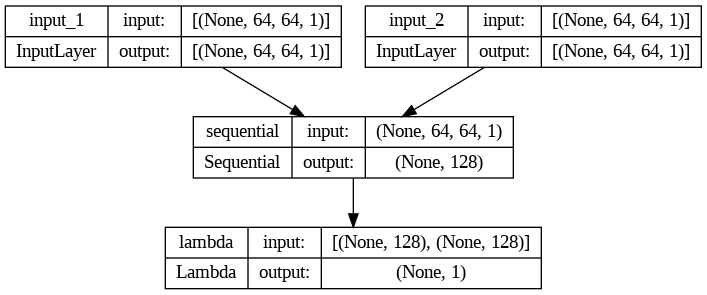

In [26]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model_att, to_file='model.png', show_shapes = True, show_layer_names = True)

In [27]:
DESC = FeatureDescriptor.DL

In [28]:
import drive.MyDrive.Assignment3.localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(db_att.images, db_att.target))
    rms = Adam()
    model_att.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model_att.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model_att.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_dl_att = encoder_att(db_att.images.astype(np.float32)).numpy()

    dist_metric_dl_att = euclidean

Epoch 1/10
38/38 - 82s - loss: 0.1604 - accuracy: 0.5954 - val_loss: 0.0783 - val_accuracy: 0.7563 - 82s/epoch - 2s/step
Epoch 2/10
38/38 - 77s - loss: 0.0795 - accuracy: 0.7516 - val_loss: 0.0650 - val_accuracy: 0.8438 - 77s/epoch - 2s/step
Epoch 3/10
38/38 - 75s - loss: 0.0612 - accuracy: 0.8289 - val_loss: 0.0569 - val_accuracy: 0.8552 - 75s/epoch - 2s/step
Epoch 4/10
38/38 - 79s - loss: 0.0480 - accuracy: 0.8890 - val_loss: 0.0497 - val_accuracy: 0.9052 - 79s/epoch - 2s/step
Epoch 5/10
38/38 - 81s - loss: 0.0423 - accuracy: 0.9095 - val_loss: 0.0421 - val_accuracy: 0.9260 - 81s/epoch - 2s/step
Epoch 6/10
38/38 - 88s - loss: 0.0340 - accuracy: 0.9474 - val_loss: 0.0379 - val_accuracy: 0.9385 - 88s/epoch - 2s/step
Epoch 7/10
38/38 - 75s - loss: 0.0304 - accuracy: 0.9531 - val_loss: 0.0338 - val_accuracy: 0.9510 - 75s/epoch - 2s/step
Epoch 8/10
38/38 - 76s - loss: 0.0269 - accuracy: 0.9688 - val_loss: 0.0313 - val_accuracy: 0.9542 - 76s/epoch - 2s/step
Epoch 9/10
38/38 - 76s - loss: 0

In [30]:
df_dl_att, similarity_mat_dl_att = compute_similarity_matrix(embedded_dl_att, dist_metric_dl_att, labels_att)

In [67]:
similarity_mat_dl_att

0         1         2         3         4         5         6    \
0    1.000000  0.866623  0.936071  0.693186  0.790890  0.808960  0.956741   
1    0.866623  1.000000  0.914962  0.768400  0.857543  0.864526  0.864134   
2    0.936071  0.914962  1.000000  0.720966  0.844456  0.822407  0.911081   
3    0.693186  0.768400  0.720966  1.000000  0.753778  0.855985  0.712382   
4    0.790890  0.857543  0.844456  0.753778  1.000000  0.777635  0.773369   
..        ...       ...       ...       ...       ...       ...       ...   
395  0.671110  0.754778  0.712025  0.817880  0.813991  0.763465  0.672422   
396  0.751962  0.818327  0.785717  0.852120  0.833372  0.841224  0.757543   
397  0.623771  0.723694  0.671721  0.796389  0.784756  0.724173  0.623983   
398  0.719619  0.773836  0.739599  0.886748  0.761320  0.854250  0.737202   
399  0.647969  0.757728  0.700958  0.806153  0.814288  0.744314  0.646469   

          7         8         9    ...       390       391       392  \
0    0.846928  0.879116  0.790401  ...  0.642521  0.720292  0.707006   
1    0.893991  0.888337  0.902710  ...  0.747081  0.792819  0.784261   
2    0.873431  0.880422  0.843018  ...  0.690404  0.758892  0.750565   
3    0.834345  0.788770  0.829834  ...  0.819094  0.827960  0.799516   
4    0.829457  0.799897  0.887315  ...  0.795990  0.841792  0.854157   
..        ...       ...       ...  ...       ...       ...       ...   
395  0.761534  0.747157  0.822180  ...  0.928403  0.939142  0.941641   
396  0.838919  0.835921  0.866121  ...  0.856945  0.946945  0.912359   
397  0.723823  0.697364  0.801853  ...  0.963583  0.881953  0.896217   
398  0.820878  0.824163  0.814420  ...  0.818252  0.879985  0.841456   
399  0.752878  0.715193  0.841977  ...  0.950956  0.869833  0.885172   

          393       394       395       396       397       398       399  
0    0.647282  0.739346  0.671110  0.751962  0.623771  0.719619  0.647969  
1    0.755723  0.810082  0.754778  0.818327  0.723694  0.773836  0.757728  
2    0.700508  0.781803  0.712025  0.785717  0.671721  0.739599  0.700958  
3    0.804612  0.796327  0.817880  0.852120  0.796389  0.886748  0.806153  
4    0.813295  0.866442  0.813991  0.833372  0.784756  0.761320  0.814288  
..        ...       ...       ...       ...       ...       ...       ...  
395  0.894053  0.907109  1.000000  0.894592  0.927226  0.850750  0.895479  
396  0.841764  0.929200  0.894592  1.000000  0.843196  0.915435  0.841002  
397  0.938753  0.862510  0.927226  0.843196  1.000000  0.801988  0.938536  
398  0.790979  0.848043  0.850750  0.915435  0.801988  1.000000  0.791383  
399  0.987943  0.860412  0.895479  0.841002  0.938536  0.791383  1.000000  

[400 rows x 400 columns]

## **Evaluation**

In [29]:
target_att = db_att.target

In [70]:
target_att = np.array(target_att)
target_att.shape

(400,)

In [39]:
ground_truth_matrix_att = np.zeros((400, 400))

for m in range(400):
  label_copy = np.ones((400,)) * target_att[m]
  ground_truth_matrix_att[m, :] = (target_att == label_copy).astype(int)

In [72]:
ground_truth_matrix_att

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

## **Calculating F1-score and accuracy**

In [73]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_precision_recall_f1_accuracy(ground_truth, predicted):
    assert ground_truth.shape == predicted.shape

    # Reshape the matrices to create 1D arrays
    ground_truth_flat = ground_truth.reshape(-1)
    predicted_flat = predicted.reshape(-1)

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(ground_truth_flat, predicted_flat)
    recall = recall_score(ground_truth_flat, predicted_flat)
    f1 = f1_score(ground_truth_flat, predicted_flat)
    accuracy = accuracy_score(ground_truth_flat, predicted_flat)

    return precision, recall, f1, accuracy

In [74]:
def predict_label(similarity_score, threshold):
  similarity_score = np.array(similarity_score)
  predicted_label = np.zeros(similarity_score.shape)

  for i in range(predicted_label.shape[0]):  
    for j in range(predicted_label.shape[1]):

        if similarity_score[i, j] > threshold:
          predicted_label[i, j] = 1
        else:
          predicted_label[i, j] = 0 
  return predicted_label

In [75]:
thresholds = np.linspace(0,1,50)

f1_pca_arr_att, f1_lda_arr_att, f1_lbp_arr_att, f1_dl_arr_att  = [], [], [], []
acc_pca_arr_att, acc_lda_arr_att, acc_lbp_arr_att, acc_dl_arr_att = [], [], [], []
precision_pca_arr_att,precision_lda_arr_att, precision_lbp_arr_att, precision_dl_arr_att = [], [], [], []
recall_pca_arr_att, recall_lda_arr_att, recall_lbp_arr_att, recall_dl_arr_att = [], [], [], []

for threshold in thresholds:
  predicted_label_pca_att = predict_label(similarity_mat_pca_att, threshold)
  predicted_label_lda_att = predict_label(similarity_mat_lda_att, threshold)
  predicted_label_lbp_att = predict_label(similarity_mat_lbp_att, threshold)
  predicted_label_dl_att = predict_label(similarity_mat_dl_att, threshold)

  precision_pca_att, recall_pca_att, f1_pca_att, accuracy_pca_att = calculate_precision_recall_f1_accuracy(ground_truth_matrix_att, predicted_label_pca_att)
  precision_lda_att, recall_lda_att, f1_lda_att, accuracy_lda_att = calculate_precision_recall_f1_accuracy(ground_truth_matrix_att, predicted_label_lda_att)
  precision_lbp_att, recall_lbp_att, f1_lbp_att, accuracy_lbp_att = calculate_precision_recall_f1_accuracy(ground_truth_matrix_att, predicted_label_lbp_att)
  precision_dl_att, recall_dl_att, f1_dl_att, accuracy_dl_att = calculate_precision_recall_f1_accuracy(ground_truth_matrix_att, predicted_label_dl_att)

  f1_pca_arr_att.append(f1_pca_att)
  f1_lda_arr_att.append(f1_lda_att)
  f1_lbp_arr_att.append(f1_lbp_att)
  f1_dl_arr_att.append(f1_dl_att)

  acc_pca_arr_att.append(accuracy_pca_att)
  acc_lda_arr_att.append(accuracy_lda_att)
  acc_lbp_arr_att.append(accuracy_lbp_att)
  acc_dl_arr_att.append(accuracy_dl_att)

  precision_pca_arr_att.append(precision_pca_att)
  precision_lda_arr_att.append(precision_lda_att)
  precision_lbp_arr_att.append(precision_lbp_att)
  precision_dl_arr_att.append(precision_dl_att)

  recall_pca_arr_att.append(recall_pca_att)
  recall_lda_arr_att.append(recall_lda_att)
  recall_lbp_arr_att.append(recall_lbp_att)
  recall_dl_arr_att.append(recall_dl_att)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

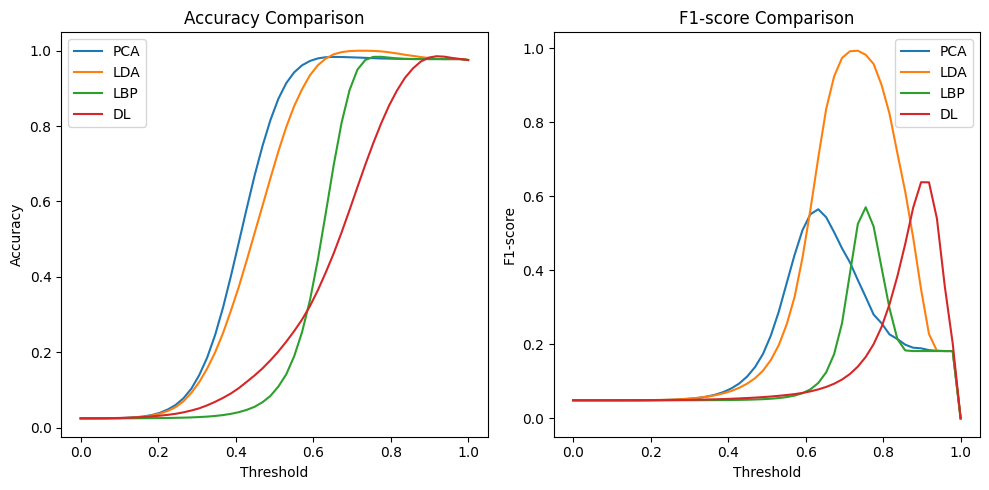

In [76]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy curves
ax1.plot(thresholds, acc_pca_arr_att, label='PCA')
ax1.plot(thresholds, acc_lda_arr_att, label='LDA')
ax1.plot(thresholds, acc_lbp_arr_att, label='LBP')
ax1.plot(thresholds, acc_dl_arr_att, label='DL')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.legend()

# Plot F1-score curves
ax2.plot(thresholds, f1_pca_arr_att, label='PCA')
ax2.plot(thresholds, f1_lda_arr_att, label='LDA')
ax2.plot(thresholds, f1_lbp_arr_att, label='LBP')
ax2.plot(thresholds, f1_dl_arr_att, label='DL')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1-score')
ax2.set_title('F1-score Comparison')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
def compute_similarity_dataframe(matching_scores, normalized_matching_scores, targets):
  data = []
  matching_scores_arr = np.array(matching_scores)
  normalized_matching_scores_arr = np.array(normalized_matching_scores)

  for i in range(len(targets)):
    for j in range(len(targets)):
      if i != j:
        genuine = 1 if targets[i] == targets[j] else 0
        data.append([targets[i], targets[j], genuine, matching_scores_arr[i,j], normalized_matching_scores_arr[i,j]])

  df = pd.DataFrame(data, columns=['person1', 'person2', 'genuine', 'score', 'normalized_score'])

  return df

In [77]:
df_pca_att

p1          p2  genuine     score  normalized_score
0       person_001  person_001        1  7.860043          0.470632
1       person_001  person_001        1  5.000115          0.686293
2       person_001  person_001        1  7.096193          0.528233
3       person_001  person_001        1  7.618118          0.488875
4       person_001  person_001        1  8.412022          0.429009
...            ...         ...      ...       ...               ...
159595  person_040  person_040        1  7.145650          0.524503
159596  person_040  person_040        1  7.045277          0.532072
159597  person_040  person_040        1  4.554167          0.719921
159598  person_040  person_040        1  6.450984          0.576886
159599  person_040  person_040        1  6.199328          0.595863

[159600 rows x 5 columns]

In [31]:
genuine_df_pca_att = df_pca_att['normalized_score'][df_pca_att['genuine'] == 1]
imposter_df_pca_att = df_pca_att['normalized_score'][df_pca_att['genuine'] == 0]

print('number of genuine scores : ', len(genuine_df_pca_att))
print('number of imposter scores : ', len(imposter_df_pca_att))

number of genuine scores :  3600
number of imposter scores :  156000


In [32]:
genuine_df_lda_att = df_lda_att['normalized_score'][df_lda_att['genuine'] == 1]
imposter_df_lda_att = df_lda_att['normalized_score'][df_lda_att['genuine'] == 0]

genuine_df_lbp_att = df_lbp_att['normalized_score'][df_lbp_att['genuine'] == 1]
imposter_df_lbp_att = df_lbp_att['normalized_score'][df_lbp_att['genuine'] == 0]

genuine_df_dl_att = df_dl_att['normalized_score'][df_dl_att['genuine'] == 1]
imposter_df_dl_att = df_dl_att['normalized_score'][df_dl_att['genuine'] == 0]

In [80]:
def plot_score_distribution(ax, imposter, genuine, title):
    bins = np.linspace(0, 1, 150)
    ax.set_title("Raw scores " + title, fontsize=12)
    ax.hist(imposter,
            label='Impostors', density=True,
            color='C1', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.hist(genuine,
            label='Genuine', density=True,
            color='C0', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.legend(fontsize=10)
    ax.set_xlabel("Scores")

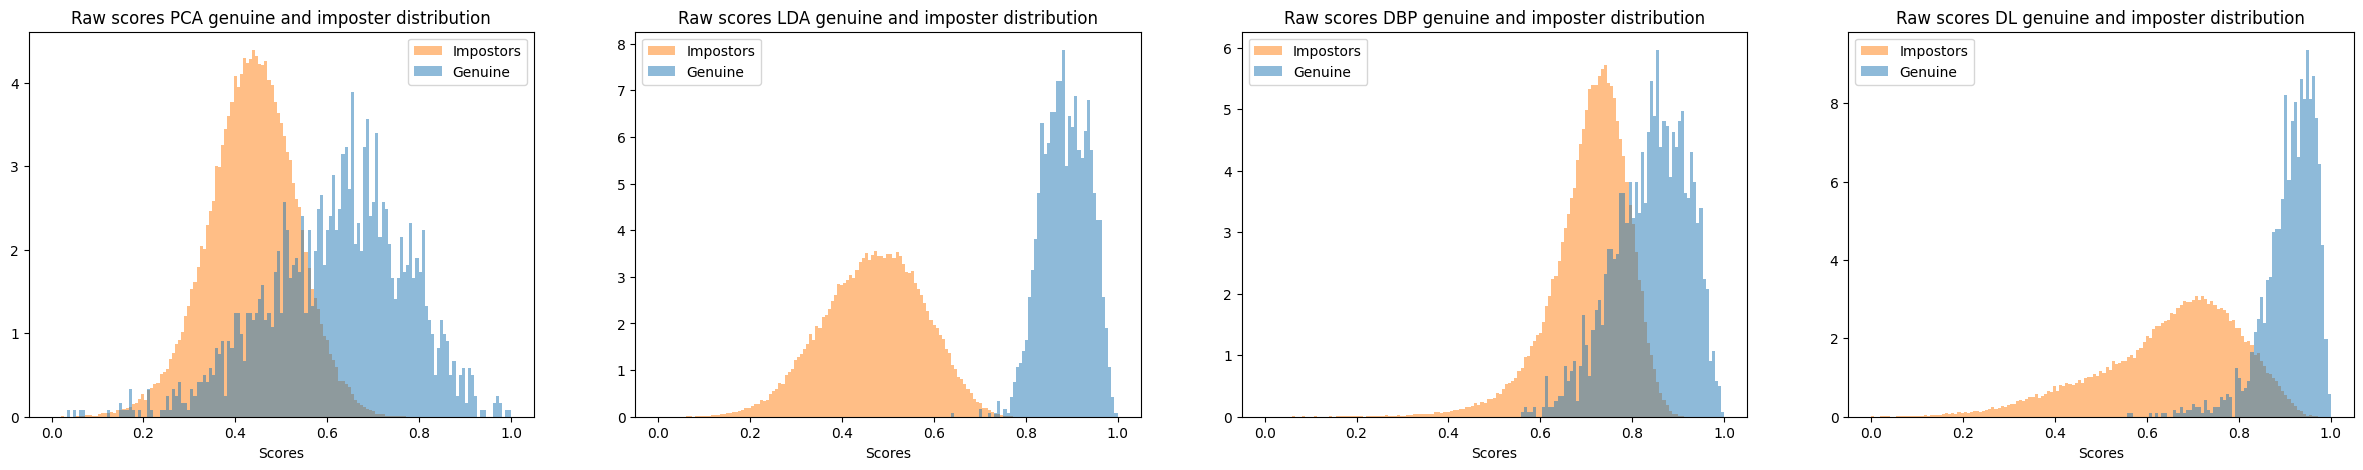

In [81]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))

plot_score_distribution(axes[0], imposter_df_pca_att, genuine_df_pca_att, "PCA genuine and imposter distribution")
plot_score_distribution(axes[1], imposter_df_lda_att, genuine_df_lda_att, "LDA genuine and imposter distribution")
plot_score_distribution(axes[2], imposter_df_lbp_att, genuine_df_lbp_att, "DBP genuine and imposter distribution")
plot_score_distribution(axes[3], imposter_df_dl_att, genuine_df_dl_att, "DL genuine and imposter distribution")

### **ROC-curve**

In [82]:
y_true_pca_att, score_pca_att = df_pca_att['genuine'], df_pca_att['normalized_score']
y_true_lda_att, score_lda_att = df_lda_att['genuine'], df_lda_att['normalized_score']
y_true_lbp_att, score_lbp_att = df_lbp_att['genuine'], df_lbp_att['normalized_score']
y_true_dl_att,  score_dl_att =  df_dl_att['genuine'], df_dl_att['normalized_score']

In [83]:
from sklearn.metrics import roc_auc_score

roc_au_pca_att = roc_auc_score(y_true_pca_att, score_pca_att)
roc_au_lda_att = roc_auc_score(y_true_lda_att, score_lda_att)
roc_au_lbp_att = roc_auc_score(y_true_lbp_att, score_lbp_att)
roc_au_dl_att = roc_auc_score(y_true_dl_att, score_dl_att)

print('ROC score for PCA : ', round(roc_au_pca_att,4))
print('ROC score for LDA : ', round(roc_au_lda_att,6))
print('ROC score for LBP : ', round(roc_au_lbp_att,4))
print('ROC score for DL : ', round(roc_au_dl_att,4))

ROC score for PCA :  0.8485
ROC score for LDA :  0.999963
ROC score for LBP :  0.878
ROC score for DL :  0.9697


### **EER**

In [84]:
from sklearn.metrics import roc_curve

def compute_fpr_fnr_tpr_from_roc_curve(score, y_true):
    fpr, tpr, threshold = roc_curve(y_true, score, pos_label=None, sample_weight=None)
    fnr = 1 - tpr
    return fpr, fnr, tpr, threshold

In [85]:
fpr_roc_pca_att, fnr_roc_pca_att, tpr_roc_pca_att, threshold_roc_pca_att = compute_fpr_fnr_tpr_from_roc_curve(score_pca_att, y_true_pca_att)
fpr_roc_lda_att, fnr_roc_lda_att, tpr_roc_lda_att, threshold_roc_lda_att = compute_fpr_fnr_tpr_from_roc_curve(score_lda_att, y_true_lda_att)
fpr_roc_lbp_att, fnr_roc_lbp_att, tpr_roc_lbp_att, threshold_roc_lbp_att = compute_fpr_fnr_tpr_from_roc_curve(score_lbp_att, y_true_lbp_att)
fpr_roc_dl_att, fnr_roc_dl_att, tpr_roc_dl_att, threshold_roc_dl_att = compute_fpr_fnr_tpr_from_roc_curve(score_dl_att, y_true_dl_att)

In [86]:
eer_threshold_roc_pca_att = threshold_roc_pca_att[np.nanargmin(np.absolute((fnr_roc_pca_att - fpr_roc_pca_att)))]
eer_threshold_roc_lda_att = threshold_roc_lda_att[np.nanargmin(np.absolute((fnr_roc_lda_att - fpr_roc_lda_att)))]
eer_threshold_roc_lbp_att = threshold_roc_lbp_att[np.nanargmin(np.absolute((fnr_roc_lbp_att - fpr_roc_lbp_att)))]
eer_threshold_roc_dl_att = threshold_roc_dl_att[np.nanargmin(np.absolute((fnr_roc_dl_att - fpr_roc_dl_att)))]
print('EER threshold for PCA : ', round(eer_threshold_roc_pca_att,4))
print('EER threshold for LDA : ', round(eer_threshold_roc_lda_att,4))
print('EER threshold for LBP : ', round(eer_threshold_roc_lbp_att,6))
print('EER threshold for DL : ', round(eer_threshold_roc_dl_att,4))

EER threshold for PCA :  0.5076
EER threshold for LDA :  0.7232
EER threshold for LBP :  0.773773
EER threshold for DL :  0.8358


### **Precision recall curve**

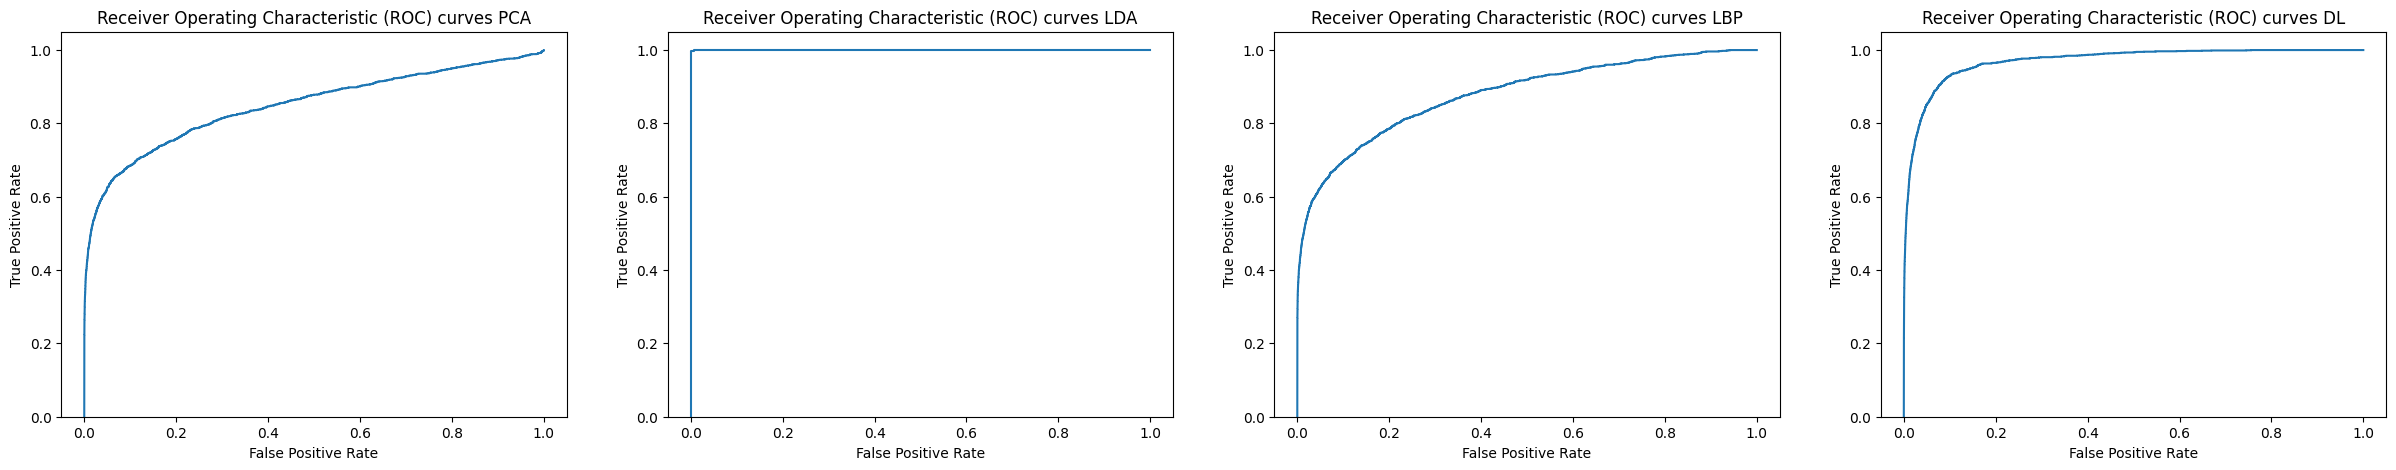

In [88]:
figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_roc_curve(fpr_roc_pca_att, tpr_roc_pca_att, axes[0], "PCA")
plot_roc_curve(fpr_roc_lda_att, tpr_roc_lda_att, axes[1], "LDA")
plot_roc_curve(fpr_roc_lbp_att, tpr_roc_lbp_att, axes[2],  "LBP")
plot_roc_curve(fpr_roc_dl_att, tpr_roc_dl_att, axes[3],  "DL")

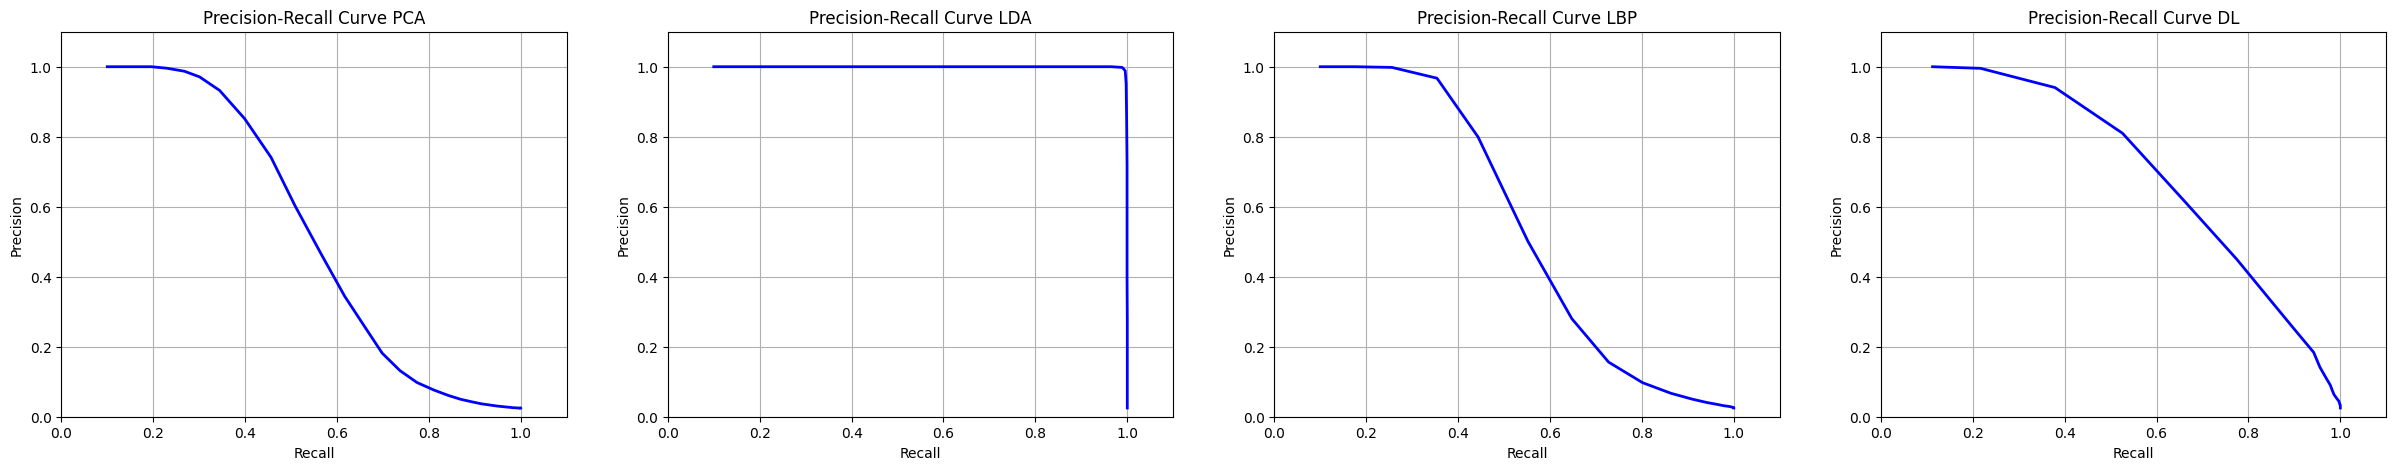

In [90]:
def plot_precision_recall_curve(recall, precision, ax, title_add=""):
    ax.plot(recall, precision, color='blue', lw=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve ' + title_add)
    ax.set_xlim([0.0, 1.1])
    ax.set_ylim([0.0, 1.1])
    ax.grid(True)

figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_precision_recall_curve(recall_pca_arr_att[:-1], precision_pca_arr_att[:-1], axes[0], "PCA")
plot_precision_recall_curve(recall_lda_arr_att[:-1], precision_lda_arr_att[:-1], axes[1], "LDA")
plot_precision_recall_curve(recall_lbp_arr_att[:-1], precision_lbp_arr_att[:-1], axes[2],  "LBP")
plot_precision_recall_curve(recall_dl_arr_att[:-1], precision_dl_arr_att[:-1], axes[3],  "DL")

### **AUC**

In [91]:
from sklearn.metrics import auc

def calculate_auc_precision_recall(precision, recall):
    sorted_indices = sorted(range(len(recall)), key=lambda k: recall[k])
    recall_sorted = [recall[i] for i in sorted_indices]
    precision_sorted = [precision[i] for i in sorted_indices]
    auc_score = auc(recall_sorted, precision_sorted)
    print(round(auc_score,4))
    return auc_score


In [92]:
auc_score_pca_att = calculate_auc_precision_recall(precision_pca_arr_att, recall_pca_arr_att)
auc_score_lda_att = calculate_auc_precision_recall(precision_lda_arr_att, recall_lda_arr_att)
auc_score_lbp_att = calculate_auc_precision_recall(precision_lbp_arr_att, recall_lbp_arr_att)
auc_score_dl_att = calculate_auc_precision_recall(precision_dl_arr_att, recall_dl_arr_att)

0.515
0.9491
0.5271
0.6618


In [94]:
from sklearn.metrics import average_precision_score

average_precision_pca_att = average_precision_score(ground_truth_matrix_att, similarity_mat_pca_att)
average_precision_lda_att = average_precision_score(ground_truth_matrix_att, similarity_mat_lda_att)
average_precision_lbp_att = average_precision_score(ground_truth_matrix_att, similarity_mat_lbp_att)
average_precision_dl_att = average_precision_score(ground_truth_matrix_att, similarity_mat_dl_att)

In [95]:
print('average precision with pca features:', round(average_precision_pca_att,4))
print('average precision with lda features:', round(average_precision_lda_att,4))
print('average precision with lbp features:', round(average_precision_lbp_att,4))
print('average precision with dl features:', round(average_precision_dl_att,4))

average precision with pca features: 0.6507
average precision with lda features: 0.9999
average precision with lbp features: 0.6774
average precision with dl features: 0.7602


### **Validation as identification system**

In [37]:
def calculate_cmc(smilarity_score_pca, ground_truth_matrix):
    smilarity_score_pca = np.array(smilarity_score_pca)
    ground_truth_matrix = np.array(ground_truth_matrix)

    scores = smilarity_score_pca.flatten()
    labels = ground_truth_matrix.flatten()
    
    # Sort the scores and labels in descending order
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Calculate the number of genuine matches at each rank
    genuine_matches = np.cumsum(sorted_labels)

    # Calculate the rank-t identification rate R_t for t = 1, 2, ..., N
    identification_rates = (genuine_matches / np.sum(labels)) * 100

    return identification_rates

In [40]:
ranked_pca_att = calculate_cmc(similarity_mat_pca_att, ground_truth_matrix_att)
ranked_lda_att = calculate_cmc(similarity_mat_lda_att, ground_truth_matrix_att)
ranked_lbp_att = calculate_cmc(similarity_mat_lbp_att, ground_truth_matrix_att)
ranked_dl_att = calculate_cmc(similarity_mat_dl_att, ground_truth_matrix_att)

In [34]:
import seaborn as sns

def plot_cmc(df, axes, index):
    p = sns.lineplot(data=df, ax=axes)
    p.set(xlabel="Rank", ylabel="Recognition rate",
          title="Cumulative Matching Characteristic Curve for " + index)

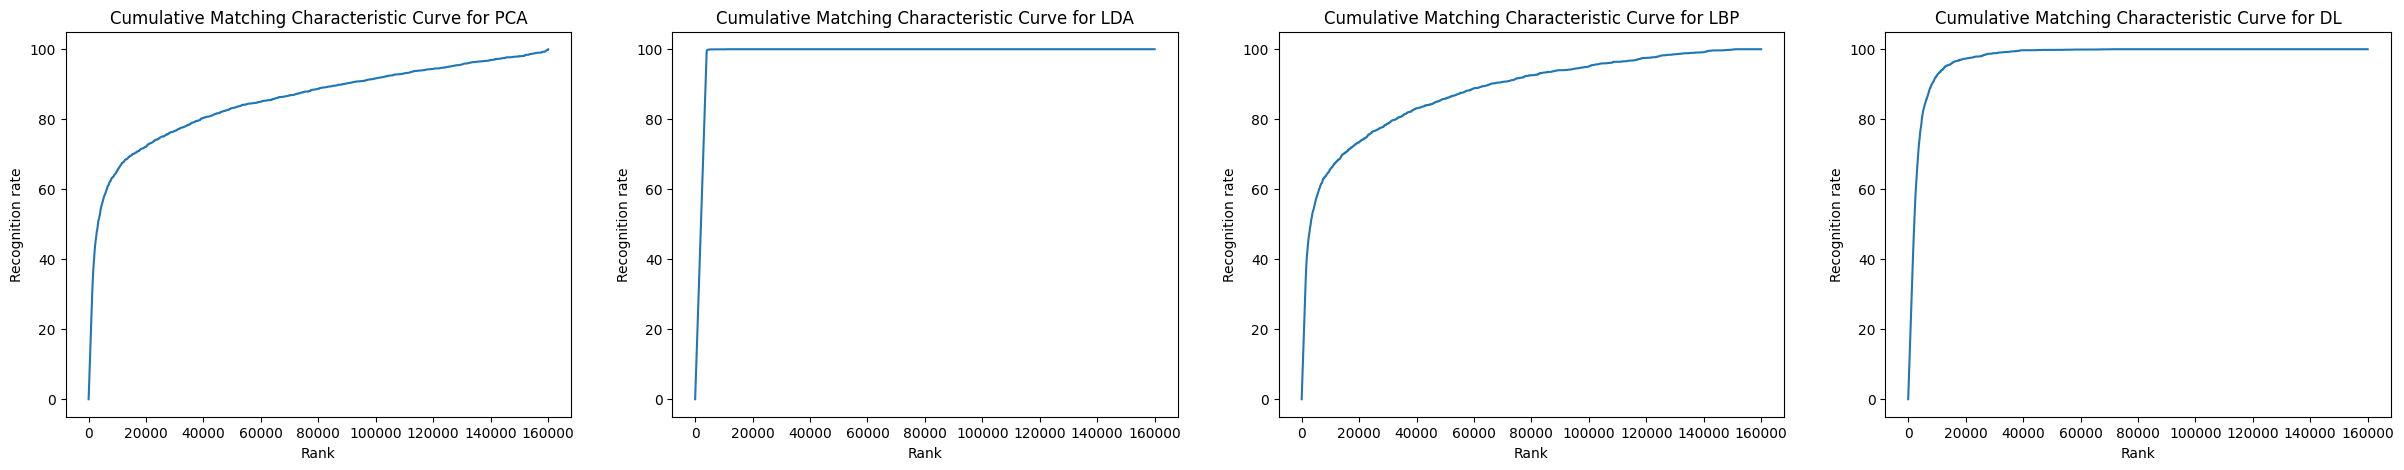

In [41]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
plot_cmc(ranked_pca_att, axes[0], "PCA")
plot_cmc(ranked_lda_att, axes[1], "LDA")
plot_cmc(ranked_lbp_att, axes[2], "LBP")
plot_cmc(ranked_dl_att, axes[3], "DL")

## **2-1-2. LFW dataset**

In [10]:
from sklearn.datasets import fetch_lfw_people
import numpy as np
from skimage.transform import resize

db_lfw = fetch_lfw_people( min_faces_per_person=40, slice_=(slice(78, 172), slice(78, 172)))
# Convert grayscale to RGB dimension
resized_images = np.array([resize(image, (47, 47)) for image in db_lfw.images])
resized_images = resized_images.astype(np.float32)

db_lfw.images = np.expand_dims(resized_images, axis=-1)
labels_lfw = []
for target in db_lfw.target:
    labels_lfw.append(db_lfw.target_names[target])

In [11]:
def get_image_db_statistic(db):
    # extract number of samples and image dimensions (for later display)
    n_samples, h, w, n_channels = db.images.shape
    imshape = (h, w, n_channels)

    # count number of individuals
    n_classes = db.target.max() + 1

    n_features = db.data.shape[1]

    print("Total dataset size:")
    print("n_samples: %d" % n_samples)
    print("n_classes: %d" % n_classes)
    print("n_features: %d" % n_features)
    print("imshape: " + str(imshape))

    return imshape, n_samples, n_classes, n_features

In [6]:
imshape_lfw, n_samples_lfw, n_classes_lfw, n_features_lfw = get_image_db_statistic(db_lfw)

Total dataset size:
n_samples: 1867
n_classes: 19
n_features: 2209
imshape: (47, 47, 1)


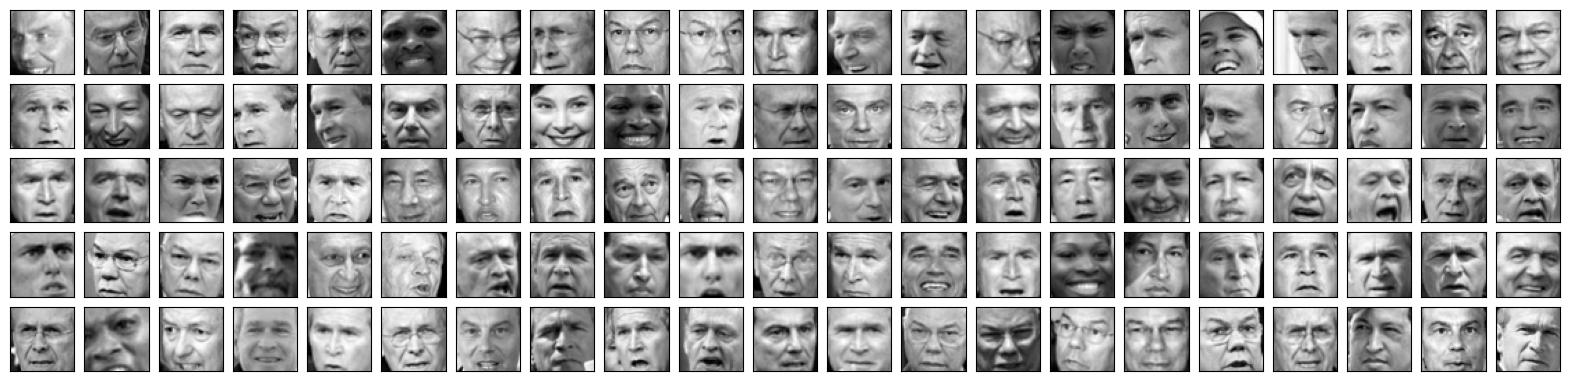

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure(figsize=(20, 20))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(5, 21), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, db_lfw['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### **Feature extraction**

In [17]:
from enum import Enum
from sklearn.model_selection import train_test_split

# split data for training and testing
holdout_split = lambda X,y: train_test_split(X, y, test_size=.25, shuffle = True, 
                                             stratify = y, random_state = 22)

class FeatureDescriptor(Enum):
    LBP = 1
    PCA = 2
    LDA = 3
    DL = 4

######################################
# select the technique you want to use
DESC = FeatureDescriptor.DL
######################################

# number of PCA/LDA components to retain
num_components = 35

**Eigenfaces for face recognition: PCA**

In [18]:
DESC = FeatureDescriptor.PCA

num_components_lfw =35

from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.PCA:
    # Compute a PCA (eigenfaces) on the face dataset
    num_components_lfw = min(num_components_lfw, min(n_samples_lfw, n_features_lfw))
    print("num_components {n}".format(n=num_components_lfw))
    desc_lfw = PCA(n_components=num_components_lfw, svd_solver='randomized', whiten=True).fit(db_lfw.data)
    X_pca_lfw = desc_lfw.transform(db_lfw.data)
    embedded_pca_lfw = X_pca_lfw
    
    dist_metric_pca_lfw = euclidean

num_components 35


In [22]:
import pandas as pd 

def min_max_norm(df_col):
    return (np.max(df_col) - df_col) / (np.max(df_col) - np.min(df_col))

def compute_similarity_matrix(embedded, dist_metric, labels):
    data = []
    similarity_matrix = np.zeros((len(embedded), len(embedded)))
    for i, img1 in enumerate(embedded):
        for j, img2 in enumerate(embedded):
            score = dist_metric(img1, img2)
            if i != j:
                genuine = 1 if labels[i] == labels[j] else 0
                data.append([labels[i], labels[j], genuine, score])
            similarity_matrix[i][j] = score

    df = pd.DataFrame(data, columns=['p1', 'p2', 'genuine', 'score'])
    df['normalized_score'] = min_max_norm(df['score'].values)
    similarity_mat_norm = min_max_norm(similarity_matrix)
    return df, pd.DataFrame(similarity_mat_norm)
    

In [24]:
df_pca_lfw, smilarity_score_pca_lfw = compute_similarity_matrix(embedded_pca_lfw, dist_metric_pca_lfw, labels_lfw)
smilarity_score_pca_lfw

0         1         2         3         4         5         6     \
0     1.000000  0.639126  0.701494  0.633496  0.632538  0.577340  0.665077   
1     0.639126  1.000000  0.696222  0.590277  0.601549  0.554148  0.627876   
2     0.701494  0.696222  1.000000  0.657446  0.630746  0.602196  0.652069   
3     0.633496  0.590277  0.657446  1.000000  0.554791  0.588144  0.625461   
4     0.632538  0.601549  0.630746  0.554791  1.000000  0.565136  0.588336   
...        ...       ...       ...       ...       ...       ...       ...   
1862  0.644134  0.625207  0.667997  0.642821  0.566811  0.566812  0.714850   
1863  0.714326  0.686056  0.705180  0.649789  0.600345  0.597222  0.726899   
1864  0.690878  0.684433  0.810673  0.649698  0.602615  0.563303  0.679337   
1865  0.584817  0.594137  0.625120  0.611456  0.488091  0.561539  0.578828   
1866  0.577906  0.526578  0.586833  0.585539  0.490728  0.479546  0.561242   

          7         8         9     ...      1857      1858      1859  \
0     0.629354  0.707673  0.722999  ...  0.546992  0.563316  0.596782   
1     0.650867  0.678873  0.662420  ...  0.546133  0.537326  0.635957   
2     0.681715  0.736208  0.754092  ...  0.602750  0.508262  0.691861   
3     0.621065  0.699800  0.646404  ...  0.674799  0.499497  0.622840   
4     0.501116  0.602620  0.629499  ...  0.530047  0.451921  0.571584   
...        ...       ...       ...  ...       ...       ...       ...   
1862  0.626689  0.661335  0.715148  ...  0.586394  0.555640  0.598849   
1863  0.649997  0.728957  0.704632  ...  0.610272  0.570716  0.669363   
1864  0.669039  0.721963  0.751305  ...  0.586954  0.513874  0.667585   
1865  0.582423  0.639353  0.680604  ...  0.534866  0.513438  0.551590   
1866  0.542190  0.583272  0.565298  ...  0.511146  0.432242  0.648849   

          1860      1861      1862      1863      1864      1865      1866  
0     0.660124  0.683166  0.644134  0.714326  0.690878  0.584817  0.577906  
1     0.595145  0.638340  0.625207  0.686056  0.684433  0.594137  0.526578  
2     0.644243  0.756056  0.667997  0.705180  0.810673  0.625120  0.586833  
3     0.615319  0.699091  0.642821  0.649789  0.649698  0.611456  0.585539  
4     0.636011  0.590255  0.566811  0.600345  0.602615  0.488091  0.490728  
...        ...       ...       ...       ...       ...       ...       ...  
1862  0.624584  0.710805  1.000000  0.631161  0.686617  0.612216  0.604708  
1863  0.643058  0.703472  0.631161  1.000000  0.701109  0.586680  0.599888  
1864  0.670308  0.717522  0.686617  0.701109  1.000000  0.588383  0.593884  
1865  0.602438  0.669283  0.612216  0.586680  0.588383  1.000000  0.551235  
1866  0.554613  0.594307  0.604708  0.599888  0.593884  0.551235  1.000000  

[1867 rows x 1867 columns]

### **Linear Discriminant Analysis (LDA)**

In [25]:
DESC = FeatureDescriptor.LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.spatial.distance import euclidean

if DESC == FeatureDescriptor.LDA:
    num_components_lfw = min(num_components_lfw, min(n_classes_lfw - 1, n_features_lfw))
    desc_lfw = LinearDiscriminantAnalysis(n_components=num_components_lfw).fit(db_lfw.data, db_lfw.target)
    X_lda_lfw = desc_lfw.fit_transform(db_lfw.data, db_lfw.target)
    embedded_lda_lfw = X_lda_lfw
    
    dist_metric_lda_lfw = euclidean

In [28]:
df_lda_lfw, smilarity_scores_lda_lfw = compute_similarity_matrix(embedded_lda_lfw, dist_metric_lda_lfw, labels_lfw)
smilarity_scores_lda_lfw

0         1         2         3         4         5         6     \
0     1.000000  0.843951  0.644444  0.667332  0.582585  0.420380  0.636022   
1     0.843951  1.000000  0.568500  0.586740  0.522658  0.370608  0.549988   
2     0.644444  0.568500  1.000000  0.593175  0.577615  0.462764  0.603665   
3     0.667332  0.586740  0.593175  1.000000  0.526063  0.421603  0.876003   
4     0.582585  0.522658  0.577615  0.526063  1.000000  0.369960  0.518099   
...        ...       ...       ...       ...       ...       ...       ...   
1862  0.456038  0.380998  0.355328  0.370573  0.320292  0.218466  0.332595   
1863  0.511822  0.448411  0.445731  0.439407  0.398176  0.257906  0.425666   
1864  0.694928  0.625354  0.877119  0.597343  0.567657  0.456519  0.610225   
1865  0.449598  0.431907  0.413990  0.419305  0.328859  0.264128  0.405789   
1866  0.382386  0.315614  0.283831  0.284731  0.243427  0.144362  0.240391   

          7         8         9     ...      1857      1858      1859  \
0     0.592222  0.613884  0.677530  ...  0.661087  0.421937  0.568006   
1     0.526247  0.531082  0.587829  ...  0.583400  0.367874  0.509706   
2     0.602651  0.586848  0.602026  ...  0.611953  0.458862  0.568141   
3     0.523493  0.902851  0.906182  ...  0.894223  0.400469  0.514501   
4     0.901797  0.520290  0.529164  ...  0.522422  0.367000  0.437583   
...        ...       ...       ...  ...       ...       ...       ...   
1862  0.355172  0.346030  0.378020  ...  0.355004  0.225083  0.369006   
1863  0.392043  0.413134  0.416715  ...  0.435984  0.258589  0.361445   
1864  0.597122  0.585968  0.614805  ...  0.616099  0.458148  0.586898   
1865  0.332090  0.405283  0.412813  ...  0.416242  0.273631  0.365776   
1866  0.276557  0.260968  0.287530  ...  0.267933  0.153673  0.288595   

          1860      1861      1862      1863      1864      1865      1866  
0     0.831145  0.618788  0.456038  0.511822  0.694928  0.449598  0.382386  
1     0.906187  0.576019  0.380998  0.448411  0.625354  0.431907  0.315614  
2     0.607371  0.597504  0.355328  0.445731  0.877119  0.413990  0.283831  
3     0.578848  0.555533  0.370573  0.439407  0.597343  0.419305  0.284731  
4     0.538423  0.454670  0.320292  0.398176  0.567657  0.328859  0.243427  
...        ...       ...       ...       ...       ...       ...       ...  
1862  0.383917  0.411674  1.000000  0.270840  0.396451  0.252801  0.844698  
1863  0.431708  0.388281  0.270840  1.000000  0.435753  0.340424  0.265109  
1864  0.664508  0.636259  0.396451  0.435753  1.000000  0.450968  0.323479  
1865  0.426961  0.423199  0.252801  0.340424  0.450968  1.000000  0.200559  
1866  0.312187  0.330587  0.844698  0.265109  0.323479  0.200559  1.000000  

[1867 rows x 1867 columns]

### **LBP**

In [29]:
DESC = FeatureDescriptor.LBP

from drive.MyDrive.Assignment3.localmodules.local_binary_patterns import LBP

def chi_squared (histA, histB, eps=1e-10):
    # compute the chi-squared distance
    d = 0.5 * np.sum(((histA - histB) ** 2) / (histA + histB + eps))
    # return the chi-squared distance
    return d

if DESC == FeatureDescriptor.LBP:
    desc_lfw = LBP(numPoints=8, radius=1, grid_x=7, grid_y=7)
    embedded_lbp_lfw = desc_lfw.describe_list(db_lfw.images[...,0])
    dist_metric_lbp_lfw = chi_squared

In [30]:
df_lbp_lfw, smilarity_scores_lbp_lfw = compute_similarity_matrix(embedded_lbp_lfw, dist_metric_lbp_lfw, labels_lfw)
smilarity_scores_lbp_lfw

0         1         2         3         4         5         6     \
0     1.000000  0.585636  0.582299  0.595674  0.603057  0.580760  0.644966   
1     0.585636  1.000000  0.599925  0.641299  0.613885  0.564418  0.593853   
2     0.582299  0.599925  1.000000  0.578666  0.590220  0.598974  0.572116   
3     0.595674  0.641299  0.578666  1.000000  0.588653  0.540284  0.578661   
4     0.603057  0.613885  0.590220  0.588653  1.000000  0.522103  0.577503   
...        ...       ...       ...       ...       ...       ...       ...   
1862  0.573286  0.516541  0.595993  0.546964  0.556273  0.570197  0.559852   
1863  0.592674  0.622408  0.611745  0.661523  0.661883  0.510556  0.613544   
1864  0.616888  0.612989  0.638712  0.613700  0.599025  0.563899  0.593051   
1865  0.618570  0.550829  0.622628  0.565104  0.564993  0.620695  0.558448   
1866  0.565915  0.487050  0.527412  0.526695  0.490491  0.537158  0.569165   

          7         8         9     ...      1857      1858      1859  \
0     0.604693  0.546141  0.598642  ...  0.582738  0.610946  0.628382   
1     0.630952  0.587510  0.634433  ...  0.559419  0.559373  0.594679   
2     0.606337  0.557396  0.618043  ...  0.574218  0.578933  0.597651   
3     0.619418  0.604915  0.623737  ...  0.582562  0.585940  0.607750   
4     0.597008  0.598332  0.635474  ...  0.558890  0.554919  0.624586   
...        ...       ...       ...  ...       ...       ...       ...   
1862  0.536281  0.506003  0.538306  ...  0.546505  0.558969  0.603905   
1863  0.597117  0.617885  0.671627  ...  0.516007  0.551987  0.615361   
1864  0.610880  0.562344  0.621835  ...  0.585779  0.603221  0.605753   
1865  0.641126  0.491989  0.563759  ...  0.613327  0.581433  0.567123   
1866  0.541926  0.475534  0.520658  ...  0.574407  0.596940  0.597782   

          1860      1861      1862      1863      1864      1865      1866  
0     0.585641  0.613779  0.573286  0.592674  0.616888  0.618570  0.565915  
1     0.554317  0.651699  0.516541  0.622408  0.612989  0.550829  0.487050  
2     0.581179  0.670948  0.595993  0.611745  0.638712  0.622628  0.527412  
3     0.544720  0.587034  0.546964  0.661523  0.613700  0.565104  0.526695  
4     0.533846  0.622225  0.556273  0.661883  0.599025  0.564993  0.490491  
...        ...       ...       ...       ...       ...       ...       ...  
1862  0.523385  0.592688  1.000000  0.561165  0.573095  0.561174  0.563454  
1863  0.569038  0.628905  0.561165  1.000000  0.655221  0.569346  0.498495  
1864  0.571137  0.592164  0.573095  0.655221  1.000000  0.607953  0.586023  
1865  0.534547  0.605258  0.561174  0.569346  0.607953  1.000000  0.578689  
1866  0.487409  0.524560  0.563454  0.498495  0.586023  0.578689  1.000000  

[1867 rows x 1867 columns]

### **DL**

In [31]:
# If you encounter problem importing the siamese model, consider using Google Colab.
import drive.MyDrive.Assignment3.localmodules.siamese as siamese


encoder_lfw, model_lfw = siamese.create_siamese_model(imshape_lfw)
model_lfw.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 47, 47, 1)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 128)          894400      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 lambda (Lambda)                (None, 1)            0           ['sequential[0][0]',         

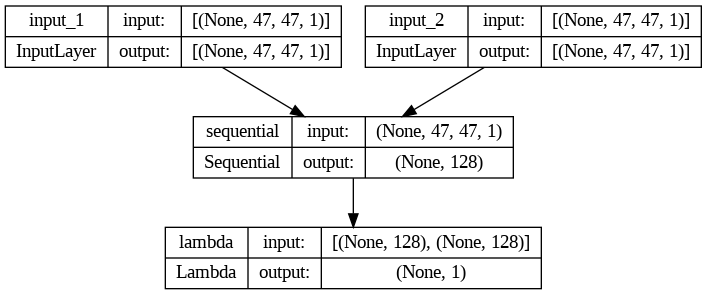

In [32]:
# To visualize your model structure:
from tensorflow.keras.utils import plot_model
plot_model(model_lfw, to_file='model.png', show_shapes = True, show_layer_names = True)

In [33]:
DESC = FeatureDescriptor.DL

import drive.MyDrive.Assignment3.localmodules.siamese as siamese
from tensorflow.keras.optimizers import RMSprop, Adam

from scipy.spatial.distance import euclidean
from sklearn.metrics import accuracy_score

if DESC == FeatureDescriptor.DL:
    x_train, x_test, y_train, y_test = holdout_split(*siamese.get_siamese_paired_data(db_lfw.images, db_lfw.target))
    rms = Adam()
    model_lfw.compile(
        loss=siamese.contrastive_loss, 
        optimizer=rms, 
        metrics = [siamese.accuracy],
        run_eagerly=True)

    epochs = 10
    model_lfw.fit([x_train[:, 0], x_train[:, 1]], y_train, 
              validation_split=0.2,
              batch_size=32, verbose=2, epochs=epochs)
    
    test_scores = model_lfw.predict([x_test[:, 0], x_test[:, 1]])
    test_acc = accuracy_score(y_test, test_scores > 0.5)
    print("Accuracy on the test set: {}".format(test_acc))
    embedded_dl_lfw = encoder_lfw(db_lfw.images.astype(np.float32)).numpy()

    dist_metric_dl_lfw = euclidean

Epoch 1/10
38/38 - 42s - loss: 0.1920 - accuracy: 0.5099 - val_loss: 0.1416 - val_accuracy: 0.5698 - 42s/epoch - 1s/step
Epoch 2/10
38/38 - 35s - loss: 0.1398 - accuracy: 0.5543 - val_loss: 0.1297 - val_accuracy: 0.5646 - 35s/epoch - 916ms/step
Epoch 3/10
38/38 - 37s - loss: 0.1339 - accuracy: 0.5707 - val_loss: 0.1260 - val_accuracy: 0.5927 - 37s/epoch - 966ms/step
Epoch 4/10
38/38 - 33s - loss: 0.1268 - accuracy: 0.5814 - val_loss: 0.1218 - val_accuracy: 0.6240 - 33s/epoch - 869ms/step
Epoch 5/10
38/38 - 35s - loss: 0.1213 - accuracy: 0.6020 - val_loss: 0.1253 - val_accuracy: 0.5948 - 35s/epoch - 923ms/step
Epoch 6/10
38/38 - 36s - loss: 0.1169 - accuracy: 0.6283 - val_loss: 0.1229 - val_accuracy: 0.5854 - 36s/epoch - 948ms/step
Epoch 7/10
38/38 - 34s - loss: 0.1142 - accuracy: 0.6431 - val_loss: 0.1166 - val_accuracy: 0.6083 - 34s/epoch - 882ms/step
Epoch 8/10
38/38 - 34s - loss: 0.1114 - accuracy: 0.6571 - val_loss: 0.1154 - val_accuracy: 0.6208 - 34s/epoch - 899ms/step
Epoch 9/10


In [34]:
df_dl_lfw, smilarity_scores_dl_lfw = compute_similarity_matrix(embedded_dl_lfw, dist_metric_dl_lfw, labels_lfw)
smilarity_scores_dl_lfw

0         1         2         3         4         5         6     \
0     1.000000  0.773189  0.862586  0.764117  0.705716  0.333904  0.823579   
1     0.773189  1.000000  0.852449  0.823331  0.869445  0.489617  0.891487   
2     0.862586  0.852449  1.000000  0.794256  0.757132  0.395369  0.843016   
3     0.764117  0.823331  0.794256  1.000000  0.756502  0.558373  0.820164   
4     0.705716  0.869445  0.757132  0.756502  1.000000  0.505192  0.843281   
...        ...       ...       ...       ...       ...       ...       ...   
1862  0.693628  0.818302  0.748736  0.878176  0.748760  0.603093  0.803477   
1863  0.898789  0.799739  0.851376  0.728380  0.755797  0.326972  0.847383   
1864  0.851632  0.753802  0.861953  0.673909  0.680517  0.263622  0.765199   
1865  0.771026  0.784060  0.833895  0.833987  0.675302  0.468568  0.771649   
1866  0.799349  0.623037  0.741249  0.591645  0.541063  0.159186  0.661976   

          7         8         9     ...      1857      1858      1859  \
0     0.880872  0.903028  0.869206  ...  0.597092  0.494111  0.763488   
1     0.867677  0.796159  0.863531  ...  0.762265  0.657755  0.606707   
2     0.907086  0.920299  0.935587  ...  0.634302  0.561541  0.717472   
3     0.806969  0.751864  0.810017  ...  0.709892  0.711036  0.546260   
4     0.804496  0.704803  0.771610  ...  0.848011  0.655535  0.542263   
...        ...       ...       ...  ...       ...       ...       ...   
1862  0.748112  0.701422  0.772824  ...  0.726300  0.768696  0.491028   
1863  0.887819  0.870023  0.854462  ...  0.638348  0.485453  0.758430   
1864  0.842185  0.906647  0.844487  ...  0.546457  0.434124  0.844958   
1865  0.780062  0.800552  0.823540  ...  0.599136  0.618861  0.598370   
1866  0.723856  0.817084  0.736169  ...  0.421306  0.324973  0.897709   

          1860      1861      1862      1863      1864      1865      1866  
0     0.855156  0.787437  0.693628  0.898789  0.851632  0.771026  0.799349  
1     0.747191  0.888467  0.818302  0.799739  0.753802  0.784060  0.623037  
2     0.869873  0.837094  0.748736  0.851376  0.861953  0.833895  0.741249  
3     0.689878  0.876458  0.878176  0.728380  0.673909  0.833987  0.591645  
4     0.659075  0.817160  0.748760  0.755797  0.680517  0.675302  0.541063  
...        ...       ...       ...       ...       ...       ...       ...  
1862  0.639751  0.878786  1.000000  0.677018  0.624742  0.816255  0.538442  
1863  0.829688  0.788505  0.677018  1.000000  0.860404  0.727034  0.765684  
1864  0.940269  0.719267  0.624742  0.860404  1.000000  0.716794  0.832962  
1865  0.746737  0.836373  0.816255  0.727034  0.716794  1.000000  0.659276  
1866  0.845936  0.622349  0.538442  0.765684  0.832962  0.659276  1.000000  

[1867 rows x 1867 columns]

### **Evaluation**

In [35]:
target_lfw = db_lfw.target

In [36]:
target_lfw = np.array(target_lfw)
target_lfw.shape

(1867,)

In [37]:
ground_truth_matrix_lfw = np.zeros((1867, 1867))

for m in range(1867):
  label_copy = np.ones((1867,)) * target_lfw[m]
  ground_truth_matrix_lfw[m, :] = (target_lfw == label_copy).astype(int)

### **F1-score and accuracy**

In [40]:
def predict_label(similarity_score, threshold):
  similarity_score = np.array(similarity_score)
  predicted_label = np.zeros(similarity_score.shape)

  for i in range(predicted_label.shape[0]):  
    for j in range(predicted_label.shape[1]):

        if similarity_score[i, j] > threshold:
          predicted_label[i, j] = 1
        else:
          predicted_label[i, j] = 0 
  return predicted_label

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_precision_recall_f1_accuracy(ground_truth, predicted):
    assert ground_truth.shape == predicted.shape

    # Reshape the matrices to create 1D arrays
    ground_truth_flat = ground_truth.reshape(-1)
    predicted_flat = predicted.reshape(-1)

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(ground_truth_flat, predicted_flat)
    recall = recall_score(ground_truth_flat, predicted_flat)
    f1 = f1_score(ground_truth_flat, predicted_flat)
    accuracy = accuracy_score(ground_truth_flat, predicted_flat)

    return precision, recall, f1, accuracy

In [44]:
thresholds = np.linspace(0,1,50)

f1_pca_arr_lfw, f1_lda_arr_lfw, f1_lbp_arr_lfw, f1_dl_arr_lfw  = [], [], [], []
acc_pca_arr_lfw, acc_lda_arr_lfw, acc_lbp_arr_lfw, acc_dl_arr_lfw = [], [], [], []
precision_pca_arr_lfw, precision_lda_arr_lfw, precision_lbp_arr_lfw, precision_dl_arr_lfw = [], [], [], []
recall_pca_arr_lfw, recall_lda_arr_lfw, recall_lbp_arr_lfw, recall_dl_arr_lfw = [], [], [], []

for threshold in thresholds:
  predicted_label_pca_lfw = predict_label(smilarity_score_pca_lfw, threshold)
  predicted_label_lda_lfw = predict_label(smilarity_scores_lda_lfw, threshold)
  predicted_label_lbp_lfw = predict_label(smilarity_scores_lbp_lfw, threshold)
  predicted_label_dl_lfw = predict_label(smilarity_scores_dl_lfw, threshold)

  precision_pca_lfw, recall_pca_lfw, f1_pca_lfw, accuracy_pca_lfw = calculate_precision_recall_f1_accuracy(ground_truth_matrix_lfw, predicted_label_pca_lfw)
  precision_lda_lfw, recall_lda_lfw, f1_lda_lfw, accuracy_lda_lfw = calculate_precision_recall_f1_accuracy(ground_truth_matrix_lfw, predicted_label_lda_lfw)
  precision_lbp_lfw, recall_lbp_lfw, f1_lbp_lfw, accuracy_lbp_lfw = calculate_precision_recall_f1_accuracy(ground_truth_matrix_lfw, predicted_label_lbp_lfw)
  precision_dl_lfw, recall_dl_lfw, f1_dl_lfw, accuracy_dl_lfw = calculate_precision_recall_f1_accuracy(ground_truth_matrix_lfw, predicted_label_dl_lfw)

  f1_pca_arr_lfw.append(f1_pca_lfw)
  f1_lda_arr_lfw.append(f1_lda_lfw)
  f1_lbp_arr_lfw.append(f1_lbp_lfw)
  f1_dl_arr_lfw.append(f1_dl_lfw)

  acc_pca_arr_lfw.append(accuracy_pca_lfw)
  acc_lda_arr_lfw.append(accuracy_lda_lfw)
  acc_lbp_arr_lfw.append(accuracy_lbp_lfw)
  acc_dl_arr_lfw.append(accuracy_dl_lfw)

  precision_pca_arr_lfw.append(precision_pca_lfw)
  precision_lda_arr_lfw.append(precision_lda_lfw)
  precision_lbp_arr_lfw.append(precision_lbp_lfw)
  precision_dl_arr_lfw.append(precision_dl_lfw)

  recall_pca_arr_lfw.append(recall_pca_lfw)
  recall_lda_arr_lfw.append(recall_lda_lfw)
  recall_lbp_arr_lfw.append(recall_lbp_lfw)
  recall_dl_arr_lfw.append(recall_dl_lfw)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

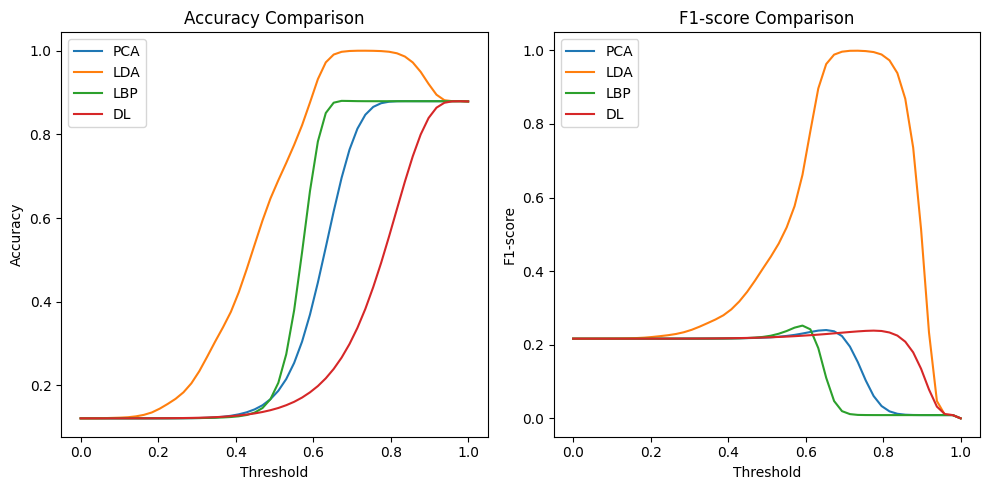

In [45]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot accuracy curves
ax1.plot(thresholds, acc_pca_arr_lfw, label='PCA')
ax1.plot(thresholds, acc_lda_arr_lfw, label='LDA')
ax1.plot(thresholds, acc_lbp_arr_lfw, label='LBP')
ax1.plot(thresholds, acc_dl_arr_lfw, label='DL')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')
ax1.set_title('Accuracy Comparison')
ax1.legend()

# Plot F1-score curves
ax2.plot(thresholds, f1_pca_arr_lfw, label='PCA')
ax2.plot(thresholds, f1_lda_arr_lfw, label='LDA')
ax2.plot(thresholds, f1_lbp_arr_lfw, label='LBP')
ax2.plot(thresholds, f1_dl_arr_lfw, label='DL')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1-score')
ax2.set_title('F1-score Comparison')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [46]:
genuine_df_pca_lfw = df_pca_lfw['normalized_score'][df_pca_lfw['genuine'] == 1]
imposter_df_pca_lfw = df_pca_lfw['normalized_score'][df_pca_lfw['genuine'] == 0]

genuine_df_lda_lfw = df_lda_lfw['normalized_score'][df_lda_lfw['genuine'] == 1]
imposter_df_lda_lfw = df_lda_lfw['normalized_score'][df_lda_lfw['genuine'] == 0]

genuine_df_lbp_lfw = df_lbp_lfw['normalized_score'][df_lbp_lfw['genuine'] == 1]
imposter_df_lbp_lfw = df_lbp_lfw['normalized_score'][df_lbp_lfw['genuine'] == 0]

genuine_df_dl_lfw = df_dl_lfw['normalized_score'][df_dl_lfw['genuine'] == 1]
imposter_df_dl_lfw = df_dl_lfw['normalized_score'][df_dl_lfw['genuine'] == 0]

In [48]:
def plot_score_distribution(ax, imposter, genuine, title):
    bins = np.linspace(0, 1, 150)
    ax.set_title("Raw scores " + title, fontsize=12)
    ax.hist(imposter,
            label='Impostors', density=True,
            color='C1', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.hist(genuine,
            label='Genuine', density=True,
            color='C0', alpha=0.5, bins=bins, range=(0, 0.5))
    ax.legend(fontsize=10)
    ax.set_xlabel("Scores")

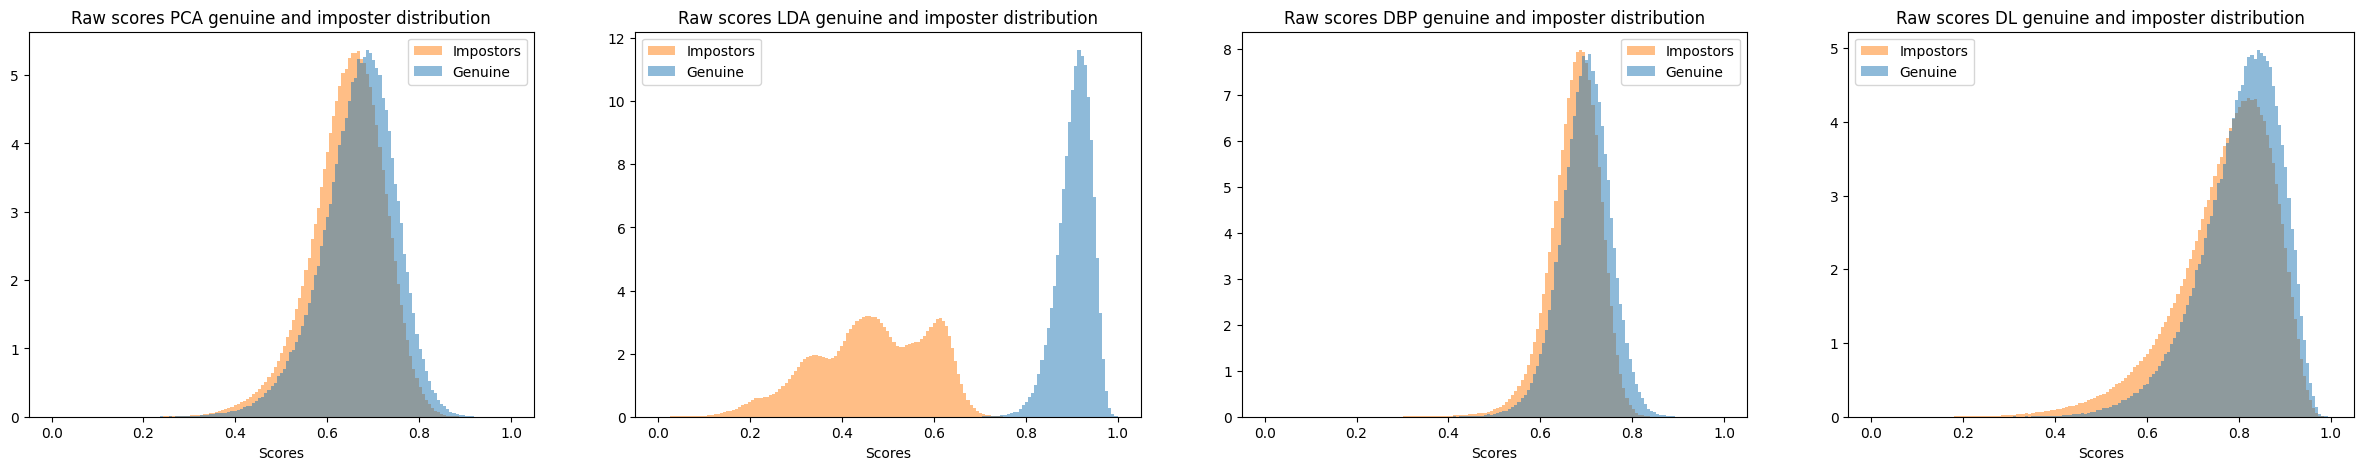

In [49]:
figure, axes = plt.subplots(1, 4, figsize=(30, 5))

plot_score_distribution(axes[0], imposter_df_pca_lfw, genuine_df_pca_lfw, "PCA genuine and imposter distribution")
plot_score_distribution(axes[1], imposter_df_lda_lfw, genuine_df_lda_lfw, "LDA genuine and imposter distribution")
plot_score_distribution(axes[2], imposter_df_lbp_lfw, genuine_df_lbp_lfw, "DBP genuine and imposter distribution")
plot_score_distribution(axes[3], imposter_df_dl_lfw, genuine_df_dl_lfw, "DL genuine and imposter distribution")

### **ROC Curve**

In [50]:
y_true_pca_lfw, score_pca_lfw = df_pca_lfw['genuine'], df_pca_lfw['normalized_score']
y_true_lda_lfw, score_lda_lfw = df_lda_lfw['genuine'], df_lda_lfw['normalized_score']
y_true_lbp_lfw, score_lbp_lfw = df_lbp_lfw['genuine'], df_lbp_lfw['normalized_score']
y_true_dl_lfw,  score_dl_lfw =  df_dl_lfw['genuine'], df_dl_lfw['normalized_score']

In [51]:
from sklearn.metrics import roc_auc_score

roc_au_pca_lfw = roc_auc_score(y_true_pca_lfw, score_pca_lfw)
roc_au_lda_lfw = roc_auc_score(y_true_lda_lfw, score_lda_lfw)
roc_au_lbp_lfw = roc_auc_score(y_true_lbp_lfw, score_lbp_lfw)
roc_au_dl_lfw = roc_auc_score(y_true_dl_lfw, score_dl_lfw)

print('ROC score for PCA : ', round(roc_au_pca_lfw,4))
print('ROC score for LDA : ', round(roc_au_lda_lfw,6))
print('ROC score for LBP : ', round(roc_au_lbp_lfw,4))
print('ROC score for DL : ', round(roc_au_dl_lfw,4))

ROC score for PCA :  0.5884
ROC score for LDA :  0.999993
ROC score for LBP :  0.6129
ROC score for DL :  0.5885


### **EER**

In [53]:
from sklearn.metrics import roc_curve

def compute_fpr_fnr_tpr_from_roc_curve(score, y_true):
    fpr, tpr, threshold = roc_curve(y_true, score, pos_label=None, sample_weight=None)
    fnr = 1 - tpr
    return fpr, fnr, tpr, threshold

In [54]:
fpr_roc_pca_lfw, fnr_roc_pca_lfw, tpr_roc_pca_lfw, threshold_roc_pca_lfw = compute_fpr_fnr_tpr_from_roc_curve(score_pca_lfw, y_true_pca_lfw)
fpr_roc_lda_lfw, fnr_roc_lda_lfw, tpr_roc_lda_lfw, threshold_roc_lda_lfw = compute_fpr_fnr_tpr_from_roc_curve(score_lda_lfw, y_true_lda_lfw)
fpr_roc_lbp_lfw, fnr_roc_lbp_lfw, tpr_roc_lbp_lfw, threshold_roc_lbp_lfw = compute_fpr_fnr_tpr_from_roc_curve(score_lbp_lfw, y_true_lbp_lfw)
fpr_roc_dl_lfw, fnr_roc_dl_lfw, tpr_roc_dl_lfw, threshold_roc_dl_lfw = compute_fpr_fnr_tpr_from_roc_curve(score_dl_lfw, y_true_dl_lfw)

In [55]:
eer_threshold_roc_pca_lfw = threshold_roc_pca_lfw[np.nanargmin(np.absolute((fnr_roc_pca_lfw - fpr_roc_pca_lfw)))]
eer_threshold_roc_lda_lfw = threshold_roc_lda_lfw[np.nanargmin(np.absolute((fnr_roc_lda_lfw - fpr_roc_lda_lfw)))]
eer_threshold_roc_lbp_lfw = threshold_roc_lbp_lfw[np.nanargmin(np.absolute((fnr_roc_lbp_lfw - fpr_roc_lbp_lfw)))]
eer_threshold_roc_dl_lfw = threshold_roc_dl_lfw[np.nanargmin(np.absolute((fnr_roc_dl_lfw - fpr_roc_dl_lfw)))]
print('EER threshold for PCA : ', round(eer_threshold_roc_pca_lfw,4))
print('EER threshold for LDA : ', round(eer_threshold_roc_lda_lfw,4))
print('EER threshold for LBP : ', round(eer_threshold_roc_lbp_lfw,6))
print('EER threshold for DL : ', round(eer_threshold_roc_dl_lfw,4))

EER threshold for PCA :  0.6617
EER threshold for LDA :  0.7265
EER threshold for LBP :  0.689737
EER threshold for DL :  0.8026


### **Precision-recall curve**

In [57]:
from sklearn.metrics import RocCurveDisplay

def plot_roc_curve(fpr, tpr, ax, title_add=""):
    display = RocCurveDisplay(fpr=fpr, tpr=tpr)
    display.plot(ax=ax)
    ax.set_title("Receiver Operating Characteristic (ROC) curves " + title_add)
    ax.set_ylim(0)

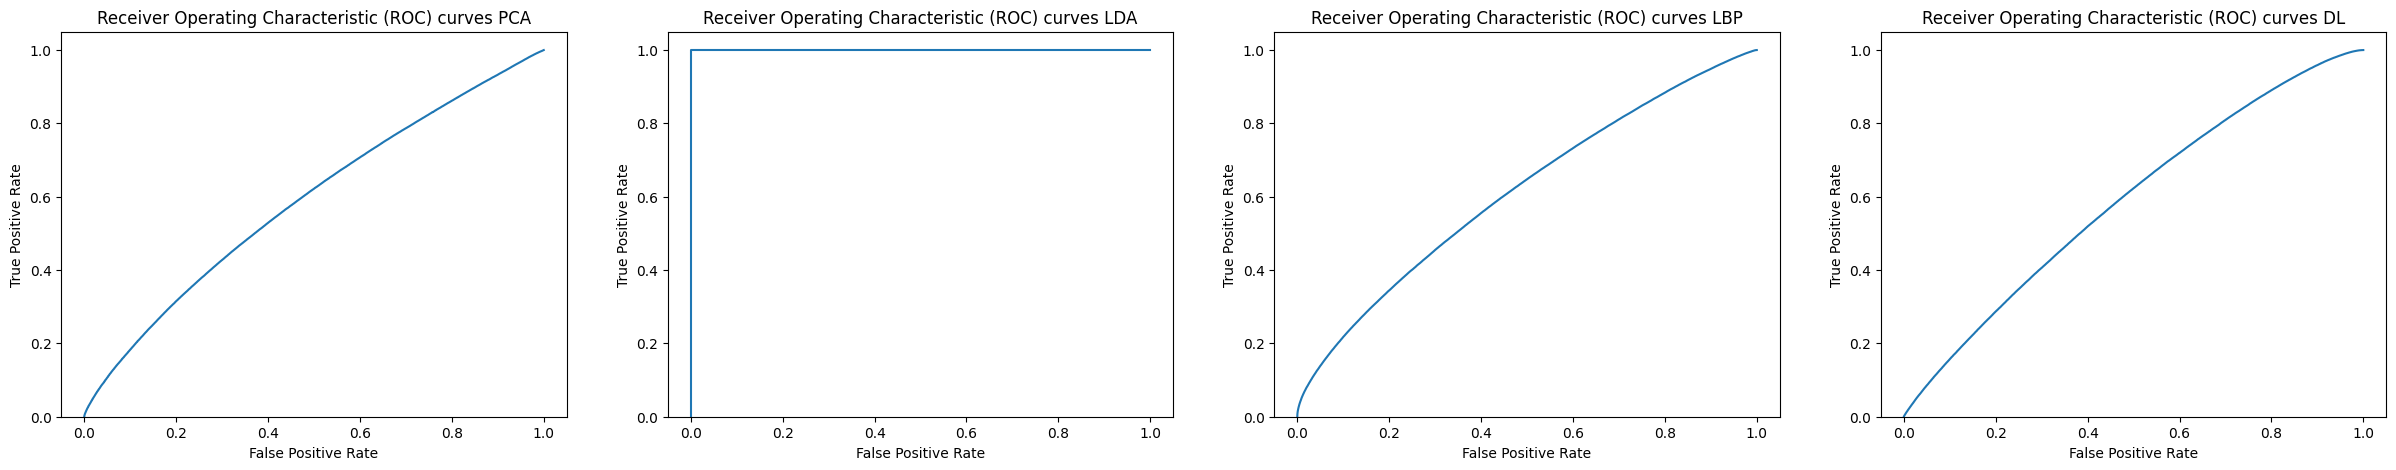

In [58]:
figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_roc_curve(fpr_roc_pca_lfw, tpr_roc_pca_lfw, axes[0], "PCA")
plot_roc_curve(fpr_roc_lda_lfw, tpr_roc_lda_lfw, axes[1], "LDA")
plot_roc_curve(fpr_roc_lbp_lfw, tpr_roc_lbp_lfw, axes[2],  "LBP")
plot_roc_curve(fpr_roc_dl_lfw, tpr_roc_dl_lfw, axes[3],  "DL")

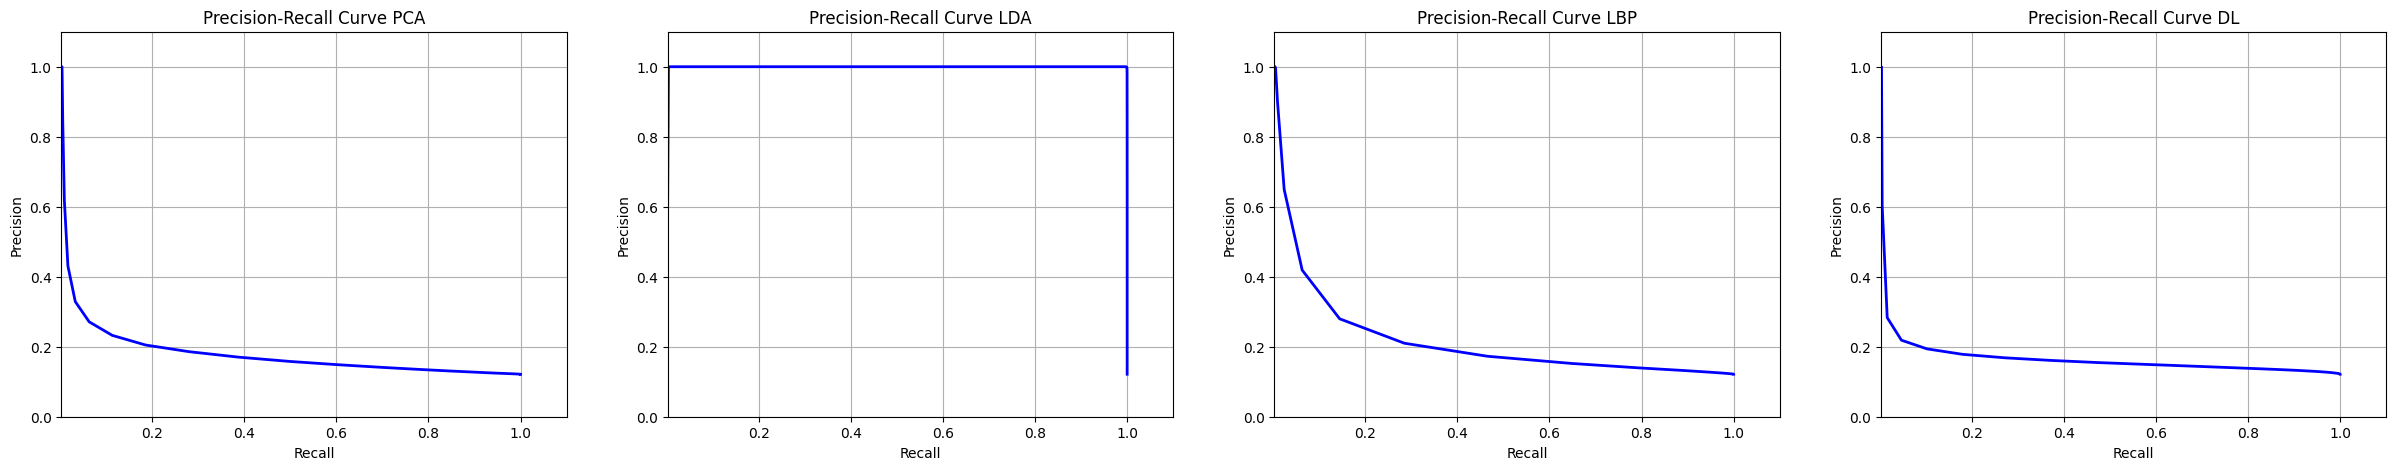

In [68]:
def plot_precision_recall_curve(recall, precision, ax, title_add=""):
    ax.plot(recall, precision, color='blue', lw=2)
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_title('Precision-Recall Curve ' + title_add)
    ax.set_xlim([0.003, 1.1])
    ax.set_ylim([0, 1.1])
    ax.grid(True)

figure, axes = plt.subplots(1,4, figsize=(30, 5))
plot_precision_recall_curve(recall_pca_arr_lfw[:-1], precision_pca_arr_lfw[:-1], axes[0], "PCA")
plot_precision_recall_curve(recall_lda_arr_lfw, precision_lda_arr_lfw, axes[1], "LDA")
plot_precision_recall_curve(recall_lbp_arr_lfw[:-1], precision_lbp_arr_lfw[:-1], axes[2],  "LBP")
plot_precision_recall_curve(recall_dl_arr_lfw[:-1], precision_dl_arr_lfw[:-1], axes[3],  "DL")

### **AUC**

In [76]:
from sklearn.metrics import auc

def calculate_auc_precision_recall(precision, recall):
    sorted_indices = sorted(range(len(recall)), key=lambda k: recall[k])
    recall_sorted = [recall[i] for i in sorted_indices]
    precision_sorted = [precision[i] for i in sorted_indices]
    auc_score = auc(recall_sorted, precision_sorted)
    print(round(auc_score,4))
    return auc_score

auc_score_pca_lfw = calculate_auc_precision_recall(precision_pca_arr_lfw, recall_pca_arr_lfw)
auc_score_lda_lfw = calculate_auc_precision_recall(precision_lda_arr_lfw, recall_lda_arr_lfw)
auc_score_lbp_lfw = calculate_auc_precision_recall(precision_lbp_arr_lfw, recall_lbp_arr_lfw)
auc_score_dl_lfw = calculate_auc_precision_recall(precision_dl_arr_lfw, recall_dl_arr_lfw)

0.179
0.9978
0.2149
0.1644


In [70]:
from sklearn.metrics import average_precision_score

average_precision_pca_lfw = average_precision_score(ground_truth_matrix_lfw, smilarity_score_pca_lfw)
average_precision_lda_lfw = average_precision_score(ground_truth_matrix_lfw, smilarity_scores_lda_lfw)
average_precision_lbp_lfw = average_precision_score(ground_truth_matrix_lfw, smilarity_scores_lbp_lfw)
average_precision_dl_lfw = average_precision_score(ground_truth_matrix_lfw, smilarity_scores_dl_lfw)

print('average precision with pca features:', round(average_precision_pca_lfw,4))
print('average precision with lda features:', round(average_precision_lda_lfw,4))
print('average precision with lbp features:', round(average_precision_lbp_lfw,4))
print('average precision with dl features:', round(average_precision_dl_lfw,4))

average precision with pca features: 0.2151
average precision with lda features: 0.9997
average precision with lbp features: 0.2411
average precision with dl features: 0.1912


### **Validation as identification system**

In [103]:
def calculate_cmc(smilarity_score_pca, ground_truth_matrix):
    smilarity_score_pca = np.array(smilarity_score_pca)
    ground_truth_matrix = np.array(ground_truth_matrix)

    scores = smilarity_score_pca.flatten()
    labels = ground_truth_matrix.flatten()
    
    # Sort the scores and labels in descending order
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Calculate the number of genuine matches at each rank
    genuine_matches = np.cumsum(sorted_labels)

    # Calculate the rank-t identification rate R_t for t = 1, 2, ..., N
    identification_rates = (genuine_matches / np.sum(labels)) * 100

    return identification_rates

In [104]:
ranked_pca_lfw = calculate_cmc(smilarity_score_pca_lfw,ground_truth_matrix_lfw)
ranked_lda_lfw = calculate_cmc(smilarity_scores_lda_lfw,ground_truth_matrix_lfw)
ranked_lbp_lfw = calculate_cmc(smilarity_scores_lbp_lfw,ground_truth_matrix_lfw)
ranked_dl_lfw = calculate_cmc(smilarity_scores_dl_lfw,ground_truth_matrix_lfw)

In [ ]:
import seaborn as sns

def plot_cmc(df, axes, index):
    p = sns.lineplot(data=df, ax=axes)
    p.set(xlabel="Rank", ylabel="Recognition rate",
          title="Cumulative Matching Characteristic Curve for " + index)
          
figure, axes = plt.subplots(1, 4, figsize=(30, 5))
plot_cmc(ranked_pca_lfw, axes[0], "PCA")
plot_cmc(ranked_lda_lfw, axes[1], "LDA")
plot_cmc(ranked_lbp_lfw, axes[2], "LBP")
plot_cmc(ranked_dl_lfw, axes[3], "DL")

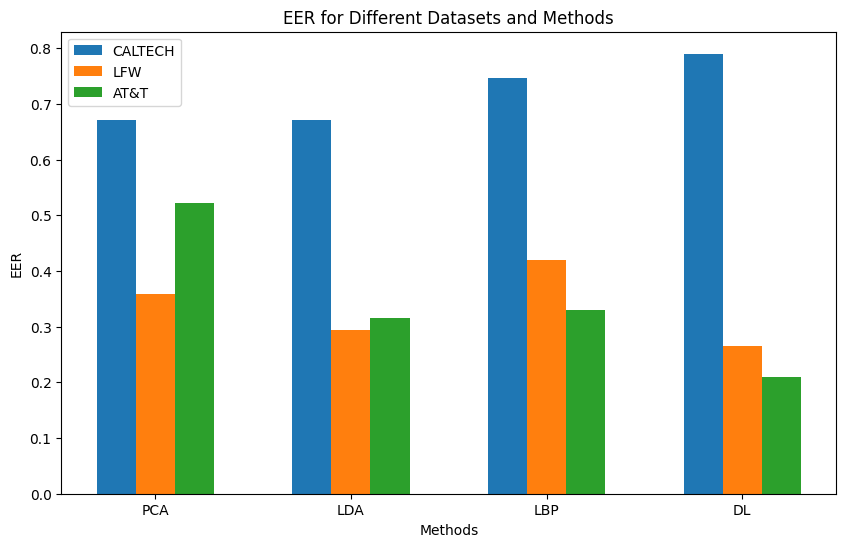

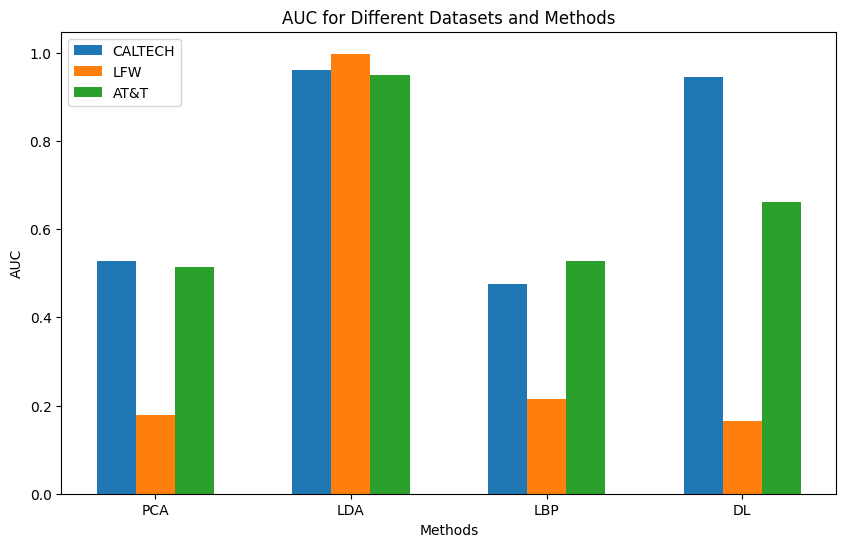

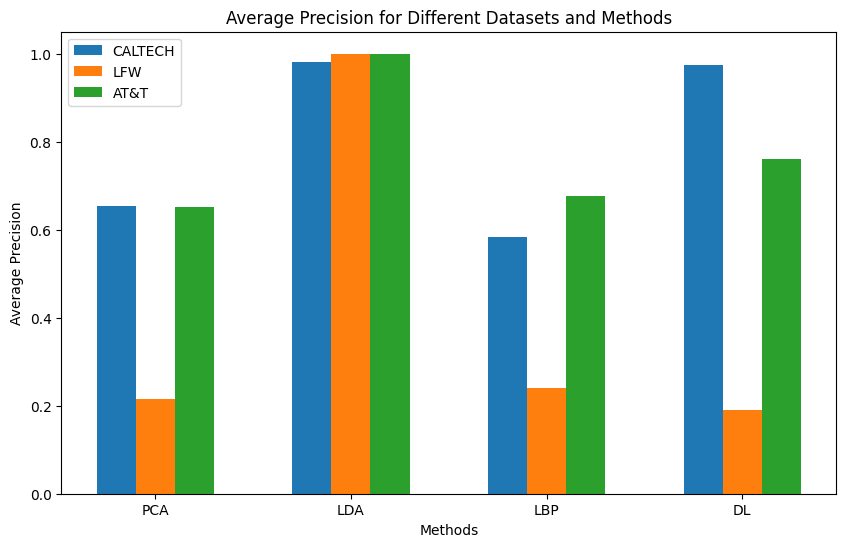

In [81]:
import numpy as np
import matplotlib.pyplot as plt

methods = ['PCA', 'LDA', 'LBP', 'DL']

# EER Threshold for CALTECH dataset
eer_threshold_caltech = np.array([0.6702, 0.6702, 0.7459, 0.7901])

# AUC for CALTECH dataset
auc_caltech = np.array([0.5271, 0.9615, 0.4752, 0.9453])

# Average Precision for CALTECH dataset
average_precision_caltech = np.array([0.6545, 0.9803, 0.5841, 0.9745])

# EER Threshold for LFW dataset
eer_threshold_lfw = np.array([0.3595, 0.2945, 0.420463, 0.2648])

# AUC for LFW dataset
auc_lfw = np.array([0.179, 0.9978, 0.2149, 0.1644])

# Average Precision for LFW dataset
average_precision_lfw = np.array([0.2151, 0.9997, 0.2411, 0.1912])

# EER Threshold for AT&T dataset
eer_threshold_att = np.array([0.5224, 0.3156, 0.32973, 0.2099])

# AUC for AT&T dataset
auc_att = np.array([0.515, 0.9491, 0.5271, 0.6618])

# Average Precision for AT&T dataset
average_precision_att = np.array([0.6507, 0.9999, 0.6774, 0.7602])

# Plotting the grouped bar plot
width = 0.2
x = np.arange(len(methods))

plt.figure(figsize=(10, 6))
plt.bar(x - width, eer_threshold_caltech, width, label='CALTECH')
plt.bar(x, eer_threshold_lfw, width, label='LFW')
plt.bar(x + width, eer_threshold_att, width, label='AT&T')
plt.xlabel('Methods')
plt.ylabel('EER')
plt.title('EER for Different Datasets and Methods')
plt.xticks(x, methods)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x - width, auc_caltech, width, label='CALTECH')
plt.bar(x, auc_lfw, width, label='LFW')
plt.bar(x + width, auc_att, width, label='AT&T')
plt.xlabel('Methods')
plt.ylabel('AUC')
plt.title('AUC for Different Datasets and Methods')
plt.xticks(x, methods)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(x - width, average_precision_caltech, width, label='CALTECH')
plt.bar(x, average_precision_lfw, width, label='LFW')
plt.bar(x + width, average_precision_att, width, label='AT&T')
plt.xlabel('Methods')
plt.ylabel('Average Precision')
plt.title('Average Precision for Different Datasets and Methods')
plt.xticks(x, methods)
plt.legend()
plt.show()


# **2.2 Implement a classification-based scoring method, using an advanced classifier of your choice. Evaluate this system in an identification and verification scenario. (Hint: Follow steps introduced in section IV. Distance-based and classification-based scoring) (2pt.)**

Support Vector Machine (SVM) scores can be utilized as a reliable matching score in biometric applications. SVMs are well-suited for classification tasks and provide decision scores that indicate the distance of an image from the decision boundary. These scores can be interpreted as the confidence or probability of the image belonging to a particular subject.

One reason why SVMs are a good choice for biometric recognition is their ability to handle high-dimensional feature spaces effectively. Biometric data, such as facial or fingerprint images, often consists of numerous features. SVMs employ a kernel function to map the input features into a higher-dimensional space, where they can be more easily separated by a hyperplane. This allows SVMs to capture complex relationships and patterns in the data, enhancing their performance in distinguishing between different subjects.

To implement a classification-based system with SVM, we will follow the steps below:

### **2-2-1. For each person in the dataset leave one image out (E.g. the first image in the dataset) for the testset. This means the size of the test set equals the number of individuals in the data (=n).**

I used CALTECH dataset that was used in the first part of the assignment

In [ ]:
import pandas as pd
from sklearn.utils import Bunch
from sklearn.preprocessing import LabelEncoder

In [ ]:
def read_img(imagePath):
    # load the image and convert it to grayscale
    gray = cv2.imread(str(imagePath), cv2.IMREAD_GRAYSCALE)

    # ROI, and resize it to a canonical size
    imagePathStem = str(imagePath.stem)
    k = int(imagePathStem[imagePathStem.rfind("_") + 1:][:4]) - 1
    

    return gray, imagePath.parent.name

In [ ]:
# grab in all the subdirs all the image paths associated with the faces
datasetPath = Path("/content/drive/MyDrive/Assignment3/CalTechFacesDirs")
imagePaths = datasetPath.glob("*/*.jpg")

# read image and label information
imgs = [read_img(imagePath) for imagePath in imagePaths]
data = pd.DataFrame(imgs, columns =['images', 'target']).to_dict('list')

# check if all images were found successfully 
# Please note that 5 images were removed from the original set, because 
# they wouldn't match the corresponding individual.
assert len(data['images']) == len(data['target']) == 445

In [ ]:
faceCascade = cv2.CascadeClassifier('/content/drive/MyDrive/Assignment3/models/haarcascade_frontalface_default.xml')
face_size=(47, 47)
feat_data, images, labels = [], [], []


for img, label in zip(data['images'], data['target']):
    faces = faceCascade.detectMultiScale(
        img,
        scaleFactor = 1.2,
        minNeighbors = 9,
        minSize = (30, 30),
        flags = cv2.CASCADE_SCALE_IMAGE
    )

    # iterate faces found in image
    for (x, y, w, h) in faces:
        new_img = img.copy()
        
        # extract ROI
        raw_face = new_img[y:y+h, x:x+w]

        # resize the face to the preferred size
        face = cv2.resize(raw_face, face_size)
        face_flatten = face.flatten()
        
        images.append(np.expand_dims(face, axis=-1)), feat_data.append(face_flatten), labels.append(label)

In [ ]:
# encode classes as integer value
label_encoder = LabelEncoder()
targets = label_encoder.fit_transform(labels)

faces = Bunch(data       = np.array(feat_data), 
              images     = np.array(images), 
              labels     = np.array(labels),
              target     = np.array(targets))

In [ ]:
import numpy as np
import pandas as pd

# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces.target.max() + 1

n_features = faces.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

# Initialize empty dictionaries to store the indices of samples in each class
class_indices = {}
train_indices = {}
test_indices = {}

# Iterate over each class and store the indices of samples belonging to that class
for class_label in range(n_classes):
    class_indices[class_label] = np.where(faces.target == class_label)[0]
    test_indices[class_label] = [class_indices[class_label][0]]
    train_indices[class_label] = class_indices[class_label][1:]

# Create a DataFrame to store the results
data = []
for class_label in range(n_classes):
    class_name = "Class %d" % class_label
    indices_str = str(class_indices[class_label])
    train_indices_str = str(train_indices[class_label])
    test_indices_str = str(test_indices[class_label])
    data.append([class_name, indices_str, train_indices_str, test_indices_str])

df_indices = pd.DataFrame(data, columns=["Class Name", "Indices", "Train Indices", "Test Indices"])

# Print the table
print(df_indices)


Total dataset size:
n_samples: 440
n_classes: 26
n_features: 2209
   Class Name                                            Indices  \
0     Class 0  [400 401 402 403 404 405 406 407 408 409 410 4...   
1     Class 1  [420 421 422 423 424 425 426 427 428 429 430 4...   
2     Class 2                              [395 396 397 398 399]   
3     Class 3  [372 373 374 375 376 377 378 379 380 381 382 3...   
4     Class 4  [329 330 331 332 333 334 335 336 337 338 339 3...   
5     Class 5  [349 350 351 352 353 354 355 356 357 358 359 3...   
6     Class 6  [309 310 311 312 313 314 315 316 317 318 319 3...   
7     Class 7                                  [305 306 307 308]   
8     Class 8  [271 272 273 274 275 276 277 278 279 280 281 2...   
9     Class 9                      [292 293 294 295 296 297 298]   
10   Class 10                          [299 300 301 302 303 304]   
11   Class 11                              [266 267 268 269 270]   
12   Class 12  [248 249 250 251 252 253 254 255 25

In [ ]:
from sklearn.utils import Bunch

train_indices_arr = np.concatenate([np.asarray(indices) for indices in train_indices.values()])
test_indices_arr = np.concatenate([np.asarray(indices) for indices in test_indices.values()])


faces_train = Bunch(data=faces.data[train_indices_arr],
                    images=faces.images[train_indices_arr],
                    labels=faces.labels[train_indices_arr],
                    target=faces.target[train_indices_arr])

faces_test = Bunch(data=faces.data[test_indices_arr],
                   images=faces.images[test_indices_arr],
                   labels=faces.labels[test_indices_arr],
                   target=faces.target[test_indices_arr])


In [ ]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces_test.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces_test.target.max() +1

n_features = faces_test.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 26
n_classes: 26
n_features: 2209


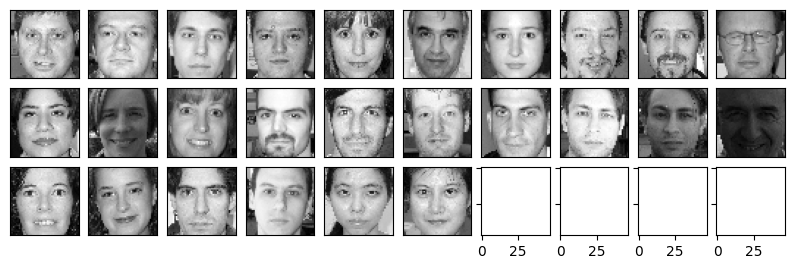

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(3, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces_test['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [ ]:
# extract number of samples and image dimensions (for later display)
n_samples, h, w, n_channels = faces_train.images.shape
imshape = (h, w, n_channels)

# count number of individuals
n_classes = faces_train.target.max() +1

n_features = faces_train.data.shape[1]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_classes: %d" % n_classes)
print("n_features: %d" % n_features)

Total dataset size:
n_samples: 414
n_classes: 26
n_features: 2209


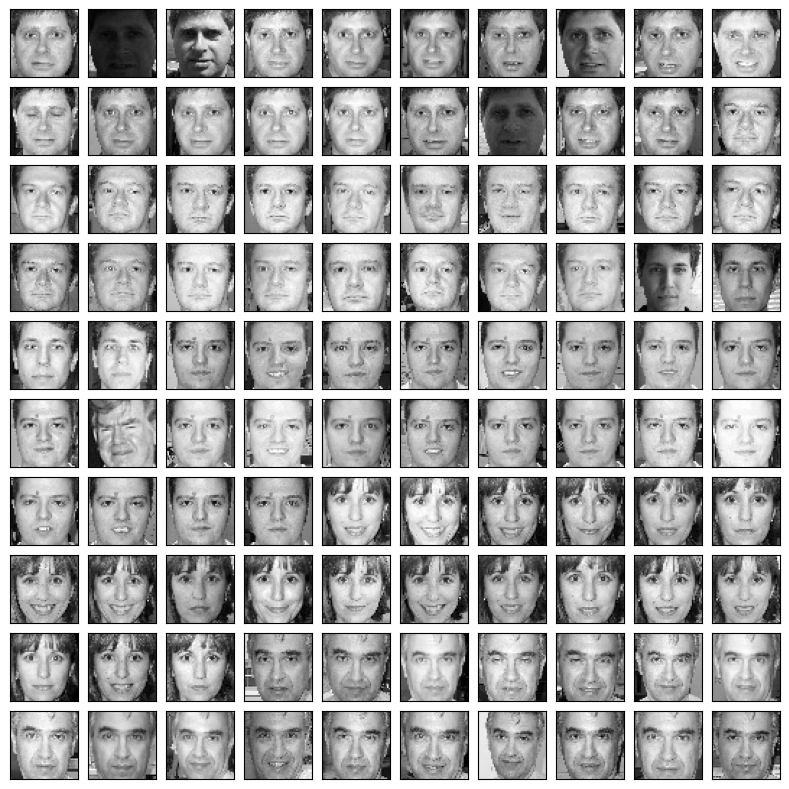

In [ ]:
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,
                 nrows_ncols=(10, 10), 
                 axes_pad=0.1,
                 )

for ax, im in zip(grid, faces_train['images']):
    # Iterating over the grid returns the Axes.
    ax.imshow(np.mean(im, -1), cmap = 'gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### **2-2-2 Run the classifier of your choice and generate the classification probabilities for each test image.**

In [ ]:
from sklearn.svm import SVC

# Create an SVM classifier
classifier = SVC(probability=True)

# Fit the classifier using the training data
classifier.fit(faces_train.data, faces_train.target)

# Generate classification probabilities for the test data
proba_test = classifier.predict_proba(faces_test.data)


In [ ]:
import pandas as pd

# Create a list to store the results
results = []

# Iterate over each test image
for i in range(len(faces_test.data)):
    image_index = test_indices_arr[i]
    true_class = faces_test.target[i]
    class_probabilities = proba_test[i]
    predicted_class = class_probabilities.argmax()

    # Append the results to the list
    results.append([image_index, true_class, predicted_class])

# Create a DataFrame from the results list
df_results = pd.DataFrame(results, columns=['Image Index', 'True Class', 'Predicted Class'])

# Print the DataFrame
print(df_results)


    Image Index  True Class  Predicted Class
0           400           0                0
1           420           1                1
2           395           2               18
3           372           3                3
4           329           4                4
5           349           5               19
6           309           6                6
7           305           7                3
8           271           8                8
9           292           9                9
10          299          10               10
11          266          11               19
12          248          12               12
13          161          13                5
14          200          14               14
15          225          15               15
16          131          16               15
17          110          17               18
18          182          18               18
19          135          19               18
20           90          20               20
21        

### **2-2-3 Build your n by n similarity matrix, in which each row corresponds to a test image and each column corresponds to an individual in the dataset.**

In [ ]:
proba_test.shape

(26, 26)

In [ ]:
import pandas as pd

def similarity_matrix(proba_test):
  
    proba_test_arr = np.array(proba_test)
    table = []
    
    for i in range(len(faces_test.data)):
        table_row = []
        
        for j in range(len(faces_test.data)):
            table_row.append(proba_test_arr[i,j])
        
        table.append(table_row)
    
    columns = [str(i) for i in range(len(faces_test.data))]
    index = [str(i) for i in range(len(faces_test.data))]
    similarity_matrix = pd.DataFrame(table, columns=columns, index=index)
    
    return similarity_matrix


In [ ]:
similarity_score_svm = similarity_matrix(proba_test)
similarity_score_svm

0         1         2         3         4         5         6  \
0   0.458423  0.017776  0.025788  0.043304  0.013410  0.017437  0.017880   
1   0.041099  0.309246  0.017985  0.073427  0.013860  0.027814  0.026452   
2   0.052816  0.057446  0.027868  0.087946  0.009754  0.021673  0.027180   
3   0.044397  0.022632  0.022251  0.356385  0.005873  0.036647  0.030170   
4   0.019496  0.006499  0.009480  0.012292  0.647302  0.011127  0.020958   
5   0.030306  0.011880  0.032105  0.057573  0.006357  0.141442  0.008421   
6   0.029918  0.040053  0.020303  0.065109  0.008717  0.014351  0.283091   
7   0.025552  0.020482  0.026928  0.210868  0.007866  0.084770  0.011142   
8   0.040209  0.013402  0.023418  0.038275  0.004639  0.023927  0.011457   
9   0.021313  0.013193  0.019275  0.037105  0.006891  0.028982  0.018140   
10  0.044521  0.024382  0.029853  0.047167  0.022663  0.019888  0.077404   
11  0.051399  0.003303  0.021139  0.021206  0.012338  0.017220  0.014424   
12  0.035558  0.011505  0.012029  0.027475  0.047964  0.012730  0.019305   
13  0.022849  0.056258  0.025647  0.066424  0.005791  0.141382  0.013805   
14  0.025846  0.016848  0.014596  0.021941  0.004936  0.008411  0.014400   
15  0.039210  0.017645  0.021052  0.034670  0.007327  0.035028  0.033241   
16  0.059079  0.085712  0.034157  0.072767  0.010081  0.074154  0.013249   
17  0.060735  0.020743  0.028486  0.058897  0.011992  0.023327  0.032626   
18  0.094821  0.003362  0.023897  0.025564  0.006059  0.029493  0.011670   
19  0.154722  0.002202  0.024711  0.010827  0.004898  0.007806  0.006803   
20  0.023182  0.009943  0.013473  0.016923  0.009890  0.005715  0.064632   
21  0.036861  0.005822  0.008799  0.024559  0.008406  0.015265  0.032109   
22  0.017516  0.010827  0.015836  0.020121  0.004417  0.010712  0.010927   
23  0.056697  0.019192  0.034416  0.097073  0.014893  0.038408  0.019569   
24  0.028816  0.023153  0.027216  0.044423  0.004382  0.014843  0.012481   
25  0.041902  0.021123  0.020322  0.027778  0.007873  0.009908  0.028686   

           7         8         9  ...        16        17        18        19  \
0   0.018581  0.018578  0.006207  ...  0.011013  0.049121  0.024980  0.006687   
1   0.011609  0.007840  0.016307  ...  0.008135  0.102160  0.016656  0.016272   
2   0.021435  0.034752  0.006404  ...  0.012849  0.036541  0.216362  0.011144   
3   0.028116  0.057706  0.017026  ...  0.008377  0.076141  0.046661  0.028524   
4   0.007878  0.009120  0.007226  ...  0.004881  0.036198  0.020158  0.008909   
5   0.031762  0.024366  0.012395  ...  0.023551  0.029313  0.029871  0.213462   
6   0.015795  0.010225  0.003279  ...  0.011310  0.018968  0.032248  0.006600   
7   0.055320  0.047607  0.013440  ...  0.012777  0.036094  0.056455  0.102124   
8   0.020979  0.429096  0.011631  ...  0.010633  0.038956  0.075332  0.028984   
9   0.019516  0.017886  0.508868  ...  0.007183  0.052329  0.020518  0.047850   
10  0.016209  0.014500  0.012452  ...  0.013114  0.047026  0.050460  0.015437   
11  0.019672  0.011933  0.037093  ...  0.008022  0.084964  0.198680  0.291685   
12  0.011207  0.010422  0.016431  ...  0.004738  0.059505  0.022159  0.011655   
13  0.041268  0.064172  0.006596  ...  0.057641  0.034555  0.029038  0.070259   
14  0.011388  0.017396  0.003193  ...  0.009965  0.022604  0.018232  0.005104   
15  0.033409  0.055259  0.011195  ...  0.009485  0.037503  0.083055  0.025442   
16  0.029414  0.018278  0.008553  ...  0.044977  0.052742  0.045900  0.042520   
17  0.024250  0.021142  0.003480  ...  0.022316  0.023240  0.329807  0.014195   
18  0.018073  0.015029  0.057799  ...  0.005336  0.072249  0.394608  0.069210   
19  0.009769  0.005855  0.006061  ...  0.008923  0.030266  0.461423  0.105577   
20  0.008172  0.008284  0.003256  ...  0.006477  0.016601  0.012672  0.004119   
21  0.011245  0.010038  0.007533  ...  0.004753  0.027732  0.026256  0.012512   
22  0.008024  0.014612  0.004709  ...  0.013666  0.015244  0.042755  0.007476   
23  0.057076  

### **2-2-4 Calculate the evaluation metrics (E.g. ROC) based on the obtained similarity matrix to test your system in a verification or identification scenario.**

**Building the ground-truth matrix**

In [ ]:
n = len(faces_test.data)
ground_truth = np.eye(n)
df_ground_truth = pd.DataFrame(ground_truth, index=range(n), columns=range(n))
df_ground_truth

0    1    2    3    4    5    6    7    8    9   ...   16   17   18   19  \
0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
1   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
2   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  1.0  0.0  0.0  0.0   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  1.0  0.0  0.0   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0  0.0   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  1.0   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   
25  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0  0.0   

     20   21   22   23   24   25  
0   0.0  0.0  0.0  0.0  0.0  0.0  
1   0.0  0.0  0.0  0.0  0.0  0.0  
2   0.0  0.0  0.0  0.0  0.0  0.0  
3   0.0  0.0  0.0  0.0  0.0  0.0  
4   0.0  0.0  0.0  0.0  0.0  0.0  
5   0.0  0.0  0.0  0.0  0.0  0.0  
6   0.0  0.0  0.0  0.0  0.0  0.0  
7   0.0  0.0  0.0  0.0  0.0  0.0  
8   0.0  0.0  0.0  0.0  0.0  0.0  
9   0.0  0.0  0.0  0.0  0.0  0.0  
10  0.0  0.0  0.0  0.0  0.0  0.0  
11  0.0  0.0  0.0  0.0  0.0  0.0  
12  0.0  0.0  0.0  0.0  0.0  0.0  
13  0.0  0.0  0.0  0.0  0.0  0.0  
14  0.0  0.0  0.0  0.0  0.0  0.0  
15  0.0  0.0  0.0  0.0  0.0  0.0  
16  0.0  0.0  0.0  0.0  0.0  0.0  
17  0.0  0.0  0.0  0.0  0.0  0.0  
18  0.0  0.0  0.0  0.0  0.0  0.0  
19  0.0  0.0  0.0  0.0  0.0  0.0  
20  1.0  0.0  0.0  0.0  0.0  0.0  
21  0.0  1.0  0.0  0.0  0.0  0.0  
22  0.0  0.0  1.0  0.0  0.0  0.0  
23  0.0  0.0  0.0  1.0  0.0  0.0  
24  0.0  0.0  0.0  0.0  1.0  0.0  
25  0.0  0.0  0.0  0.0  0.0  1.0  

[26 rows x 26 columns]

**Calculating F1-score and accuracy**

In [ ]:
def predict_label(similarity_score, threshold):
  similarity_score = np.array(similarity_score)
  predicted_label = np.zeros(similarity_score.shape)

  for i in range(predicted_label.shape[0]):  
    for j in range(predicted_label.shape[1]):

        if similarity_score[i, j] > threshold:
          predicted_label[i, j] = 1
        else:
          predicted_label[i, j] = 0 
  return predicted_label

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def calculate_precision_recall_f1_accuracy(ground_truth, predicted):
    assert ground_truth.shape == predicted.shape

    # Reshape the matrices to create 1D arrays
    ground_truth_flat = ground_truth.reshape(-1)
    predicted_flat = predicted.reshape(-1)

    # Calculate precision, recall, F1-score, and accuracy
    precision = precision_score(ground_truth_flat, predicted_flat)
    recall = recall_score(ground_truth_flat, predicted_flat)
    f1 = f1_score(ground_truth_flat, predicted_flat)
    accuracy = accuracy_score(ground_truth_flat, predicted_flat)

    return precision, recall, f1, accuracy

In [ ]:
thresholds = np.linspace(0,1,50)
f1_svm_arr, acc_svm_arr, precision_svm_arr, recall_svm_arr  = [], [], [], []

for threshold in thresholds:
  predicted_label_svm = predict_label(similarity_score_svm, threshold)

  precision_svm, recall_svm, f1_svm, accuracy_svm = calculate_precision_recall_f1_accuracy(ground_truth, predicted_label_svm)

  f1_svm_arr.append(f1_svm)
  acc_svm_arr.append(accuracy_svm)
  precision_svm_arr.append(precision_svm)
  recall_svm_arr.append(recall_svm)

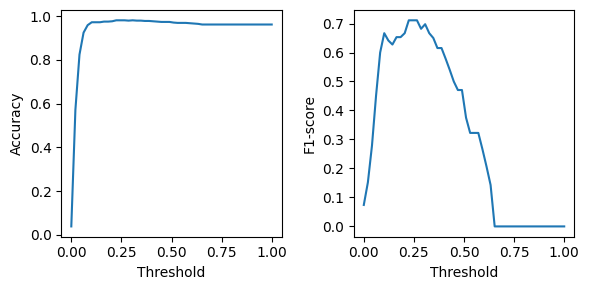

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,3))

# Plot accuracy curves
ax1.plot(thresholds, acc_svm_arr)
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Accuracy')

# Plot F1-score curves
ax2.plot(thresholds, f1_svm_arr)
ax2.set_xlabel('Threshold')
ax2.set_ylabel('F1-score')

# Adjust spacing between subplots
plt.tight_layout()

plt.show()

**Precision-recall curve**

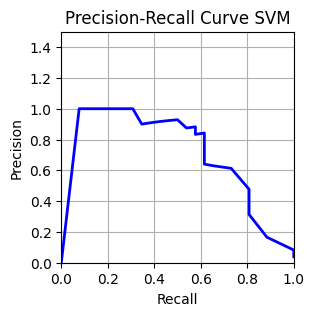

In [ ]:
import matplotlib.pyplot as plt

def plot_precision_recall_curve(recall, precision, title_add=""):
    plt.figure(figsize=(3, 3))
    plt.plot(recall, precision, color='blue', lw=2)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve ' + title_add)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.5])
    plt.grid(True)
    plt.show()

plot_precision_recall_curve(recall_svm_arr[:-1], precision_svm_arr[:-1], "SVM")


**ROC Score**

In [ ]:
from sklearn.metrics import roc_auc_score

roc_au_svm = roc_auc_score(ground_truth, similarity_score_svm)
print('ROC score for SVM : ', round(roc_au_svm,4))

ROC score for SVM :  0.9431


**EER (The equal error rate) thresholds**

In [ ]:
from sklearn.metrics import roc_curve

def compute_fpr_fnr_tpr_from_roc_curve(score, y_true):
    fpr, tpr, threshold = roc_curve(y_true, score, pos_label=None, sample_weight=None)
    fnr = 1 - tpr
    return fpr, fnr, tpr, threshold,

In [ ]:
ground_truth_np = np.array(ground_truth)
similarity_score_svm_np = np.array(similarity_score_svm)

ground_truth_flat = ground_truth_np.reshape(-1)
predicted_flat = similarity_score_svm_np.reshape(-1)

In [ ]:
fpr_roc_svm, fnr_roc_svm, tpr_roc_svm, threshold_roc_svm = compute_fpr_fnr_tpr_from_roc_curve(predicted_flat, ground_truth_flat)
eer_threshold_roc_svm = threshold_roc_svm[np.nanargmin(np.absolute((fnr_roc_svm - fpr_roc_svm)))]
print('EER threshold for svm : ', round(eer_threshold_roc_svm,4))

EER threshold for svm :  0.0453


In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(fpr, tpr, title_add=""):
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')  # Diagonal line (random classifier)
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title("Receiver Operating Characteristic (ROC) curves " + title_add)
    plt.ylim([0, 1.05])
    plt.xlim([-0.05, 1])
    plt.grid(True)
    plt.show()


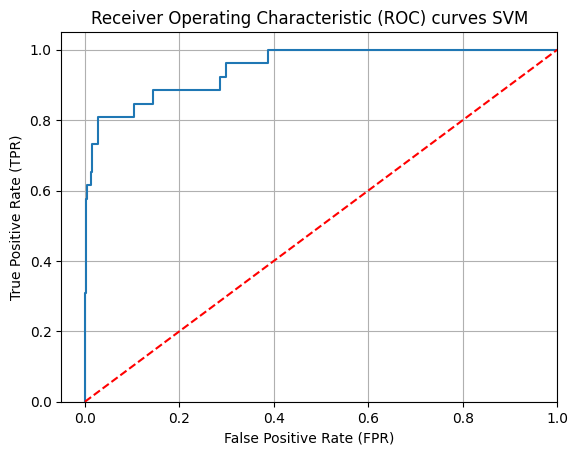

In [ ]:
plot_roc_curve(fpr_roc_svm, tpr_roc_svm, "SVM")

**AUC**

In [ ]:
from sklearn.metrics import auc

def calculate_auc_precision_recall(precision, recall):
    sorted_indices = sorted(range(len(recall)), key=lambda k: recall[k])
    recall_sorted = [recall[i] for i in sorted_indices]
    precision_sorted = [precision[i] for i in sorted_indices]
    auc_score = auc(recall_sorted, precision_sorted)
    print(round(auc_score,4))
    return auc_score

In [ ]:
auc_score_svm = calculate_auc_precision_recall(precision_svm_arr, recall_svm_arr)

0.6917


** Average precision**

In [ ]:
from sklearn.metrics import average_precision_score

average_precision_svm = average_precision_score(ground_truth_np, similarity_score_svm_np)
print('average precision with SVM features:', round(average_precision_svm,4))

average precision with SVM features: 0.8149


Validation as identification system

In [ ]:
def calculate_cmc(smilarity_score_pca, ground_truth_matrix):
    smilarity_score_pca = np.array(smilarity_score_pca)
    ground_truth_matrix = np.array(ground_truth_matrix)

    scores = smilarity_score_pca.flatten()
    labels = ground_truth_matrix.flatten()
    
    # Sort the scores and labels in descending order
    sorted_indices = np.argsort(scores)[::-1]
    sorted_scores = scores[sorted_indices]
    sorted_labels = np.array(labels)[sorted_indices]

    # Calculate the number of genuine matches at each rank
    genuine_matches = np.cumsum(sorted_labels)

    # Calculate the rank-t identification rate R_t for t = 1, 2, ..., N
    identification_rates = (genuine_matches / np.sum(labels)) * 100

    return identification_rates

In [ ]:
ranked_svm = calculate_cmc(similarity_score_svm_np, ground_truth_np)

In [ ]:
import seaborn as sns

def plot_cmc(df, axes, index):
    p = sns.lineplot(data=df, ax=axes)
    p.set(xlabel="Rank", ylabel="Recognition rate",
          title="Cumulative Matching Characteristic Curve for " + index)

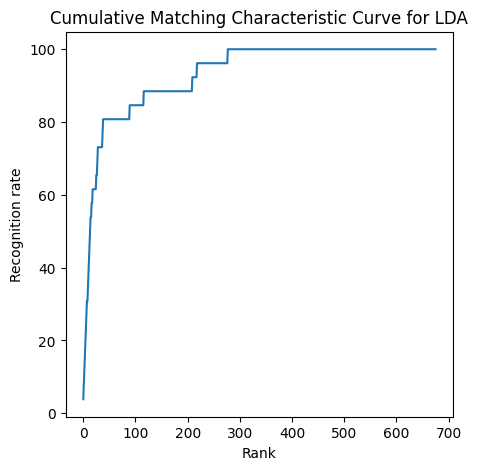

In [ ]:
figure, axes = plt.subplots(1, 1, figsize=(5, 5))
plot_cmc(ranked_svm, axes, "LDA")